this one

# Libraries

In [1]:
# Libraries
import math as ma
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import OrderedDict
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import re
import statistics
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Read data file and make the dataset

In [2]:
data = pd.read_pickle('./data.pkl')

# Creating the model
consts_1 = []
consts_2 = []
consts_3 = []

all_months_1 = []
all_months_2 = []
all_months_3 = []

arch_1 = []
arch_2 = []
arch_3 = []

for y in range(2015, 2020):

    d = data[data["Year"] == str(y)]
    d1 = d.drop(columns=["HJT(W/m^2)", "BC(W/m^2)"], axis=1)
    d1 = d1.dropna().reset_index(drop=True)
    # print(d1)
    d2 = d.drop(columns=["AlBSF(W/m^2)", "BC(W/m^2)"], axis=1)
    d2 = d2.dropna().reset_index(drop=True)
    d3 = d.drop(columns=["AlBSF(W/m^2)", "HJT(W/m^2)"], axis=1)
    d3 = d3.dropna().reset_index(drop=True)

    for month in range(1, 13):
        if month < 10:
            m = '0' + str(month)
        else:
            m = str(month)

        if m in d1["Month"].values:
            Y1 = d1[d1["Month"] == m]["AlBSF(W/m^2)"]

            a1 = Y1
            a1 = a1.rename(m + '/' + str(y)[2:4])
            arch_1.append(a1)

            X = d1[d1["Month"] == m]["Irradiance(W/m^2)"]

            model = sm.OLS(Y1, X)

            results = model.fit()

            c = results.params

            consts_1.append(c)

            all_months_1.append(m + '/' + str(y)[2:4])

        if m in d2["Month"].values:
            Y2 = d2[d2["Month"] == m]["HJT(W/m^2)"]
            a2 = Y2
            a2 = a2.rename(m + '/' + str(y)[2:4])
            arch_2.append(a2)

            X1 = d2[d2["Month"] == m]["Irradiance(W/m^2)"]

            model1 = sm.OLS(Y2, X1)
            results1 = model1.fit()

            c1 = results1.params
            consts_2.append(c1)

            all_months_2.append(m + '/' + str(y)[2:4])

        if m in d3["Month"].values:
            Y3 = d3[d3["Month"] == m]["BC(W/m^2)"]
            a3 = Y3
            a3 = a3.rename(m + '/' + str(y)[2:4])
            arch_3.append(a3)

            X2 = d3[d3["Month"] == m]["Irradiance(W/m^2)"]

            model2 = sm.OLS(Y3, X2)
            results2 = model2.fit()

            c2 = results2.params
            consts_3.append(c2)

            all_months_3.append(m + '/' + str(y)[2:4])

# Scatter Plots
dates = ["1/15", "12/19"]
start, end = [datetime.strptime(_, "%m/%y") for _ in dates]
m_y = OrderedDict(((start + timedelta(_)).strftime(r"%m/%y"), None) for _ in range((end - start).days)).keys()
m_y = list(m_y)
all = m_y

ym = pd.DataFrame(all)
ym = ym.rename(columns={0: "Y/m"})
s1 = pd.DataFrame(consts_1)
s1 = pd.concat([pd.DataFrame(all_months_1), s1], axis=1)
s1 = s1.rename(columns={"Irradiance(W/m^2)": "AlBSF slope", 0: "Y/m"})

s2 = pd.DataFrame(consts_2)
s2 = pd.concat([pd.DataFrame(all_months_2), s2], axis=1)
s2 = s2.rename(columns={"Irradiance(W/m^2)": "HJT slope", 0: "Y/m"})
s3 = pd.DataFrame(consts_3)
s3 = pd.concat([pd.DataFrame(all_months_3), s3], axis=1)
s3 = s3.rename(columns={"Irradiance(W/m^2)": "BC slope", 0: "Y/m"})

d_1 = ym.merge(s1, on=["Y/m"], how='left')
d_2 = d_1.merge(s2, on=["Y/m"], how='left')
df = d_2.merge(s3, on=["Y/m"], how='left')

# Read matlab slopes and make the dataframes
d_3a = pd.read_csv('Solar_Irradiance/csv/monthly_slopes_3a.csv')
d_4a = pd.read_csv('Solar_Irradiance/csv/monthly_slopes_4a.csv')
d_7a = pd.read_csv('Solar_Irradiance/csv/monthly_slopes_7a.csv')

m_3a = all_months_1
m_4a = all_months_2
m_7a = all_months_3

m_3a.remove("11/15")
m_3a.remove("12/15")
m_4a.remove("11/15")
m_4a.remove("12/15")
m_7a.remove("11/15")
m_7a.remove("12/15")

d_3a["Y/m"] = m_3a
d_3a.drop(['Year', 'Month'], axis='columns', inplace=True)
d_3a = d_3a.merge(ym, on=["Y/m"], how='right')
d_4a["Y/m"] = m_4a
d_4a.drop(['Year', 'Month'], axis='columns', inplace=True)
d_4a = d_4a.merge(ym, on=["Y/m"], how='right')
d_7a["Y/m"] = m_7a
d_7a.drop(['Year', 'Month'], axis='columns', inplace=True)
d_7a = d_7a.merge(ym, on=["Y/m"], how='right')
# print(d_4a)
# print(d_7a)


## Model and residuals

In [3]:
# this
t = np.arange(1., 60.)
# X = sm.add_constant(t)
X = pd.DataFrame({})
m = 0 ; k = 0
L = 4 ; K = 4

# Polynomial Trend
for j in range(0, K + 1):
  # print(j)
  X[f't{j}'] = t**j
  k += 1

for i in range(1, L+1):
  X[f's{m}'] = np.cos((2* i* np.pi * X['t1']) / 12)
  X[f's{m+1}'] = np.sin((2* i * np.pi * X['t1']) / 12)
  m += 2

l_col = [col for col in X.columns if col.startswith('t')]
s_col = [col for col in X.columns if col.startswith('s')]

# Albsf
Y3a = df[["AlBSF slope"]]
Y3a = pd.concat([Y3a, X], axis=1).dropna()
y = Y3a["AlBSF slope"]


# Linear
x_linear = Y3a[l_col]

x_seasonal = Y3a[s_col]


c_al, c_hjt, c_bc = [], [], []

# HJT
Y4a = df[["HJT slope"]]
Y4a = pd.concat([Y4a, X], axis=1).dropna()
y4 = Y4a["HJT slope"]

x4_l = Y4a[l_col]
x4_s = Y4a[s_col]

# BC
Y7a = df[["BC slope"]]
Y7a = pd.concat([Y7a, X], axis=1).dropna()
y7 = Y7a["BC slope"]

x7_l = Y7a[l_col]
x7_s = Y7a[s_col]

##########################################################################
# Linear models
c_al, c_hjt, c_bc = [], [], []
al_s_res, hjt_s_res, bc_s_res = [], [], []
for r in range(0, K + 1):
  # AlBSF
  m_c_al = sm.OLS(y, x_linear[l_col[0:r+1]])
  res_c = m_c_al.fit()
  c_c = res_c.params
  # c_al.append(c_c * x_linear[l_col[0:r+1]])
  c_al.append(res_c.resid)

  # HJT
  m4_c = sm.OLS(y4, x4_l[l_col[0:r+1]])
  res4_c = m4_c.fit()
  c4_c = res4_c.params
  # c_hjt.append(c4_c * x_linear[l_col[0:r+1]])
  c_hjt.append(res4_c.resid)

  # BC
  m7_c = sm.OLS(y7, x7_l[l_col[0:r+1]])
  res7_c = m7_c.fit()
  c7_c = res7_c.params
  # c_bc.append(c7_c * x_linear[l_col[0:r+1]])
  c_bc.append(res7_c.resid)

  # Seasonal Models
  for l in range(1, L + K, 2):
    # print(l)
    # AlBSF
    s_data = Y3a[s_col[0:l+1]]
    x_new = pd.concat((Y3a[l_col[0:r+1]], s_data), axis=1)
    model_s = sm.OLS(y, x_new)
    res_s = model_s.fit()
    # al_s_res.append(res_s)
    c_s = res_s.params
    # c_s_al = pd.concat([c_s[l_col] * Y3a[l_col], c_s[s_col[0:l+1]] * Y3a[s_col[0:l+1]]], axis=1)
    al_s_res.append(res_s.resid)
    # print(c_al)

    # HJT
    s4_data = Y4a[s_col[0:l+1]]
    x4_new = pd.concat((Y4a[l_col[0:r+1]], s4_data), axis=1)
    m4_s = sm.OLS(y4, x4_new)
    res4_s = m4_s.fit()
    # hjt_s_res.append(res4_s)
    c4_s = res4_s.params
    # c4_s_al = pd.concat([c4_s[l_col] * Y4a[l_col], c4_s[s_col[0:l+1]] * Y4a[s_col[0:l+1]]], axis=1)
    # c_hjt.append(c4_s_al)
    hjt_s_res.append(res4_s.resid)

    # BC
    s7_data = Y7a[s_col[0:l+1]]
    x7_new = pd.concat((Y7a[l_col[0:r+1]], s7_data), axis=1)
    m7_s = sm.OLS(y7, x7_new)
    res7_s = m7_s.fit()
    # bc_s_res.append(res7_s)
    c7_s = res7_s.params
    # c7_s_al = pd.concat([c7_s[l_col] * Y7a[l_col], c7_s[s_col[0:l+1]] * Y7a[s_col[0:l+1]]], axis=1)
    # c_bc.append(c7_s_al)
    bc_s_res.append(res7_s.resid)

# Plots

In [4]:
def plot_residuals(ax, res, label):
    # Histogram of the residual error
    # print(len(res))
    n, bins, _ = ax.hist(x=res, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label=label)
    # print(sum(n))

    # Plot the PDF
    mu, std = stats.norm.fit(res)
    xmin = min(res)
    xmax = max(res)
    x = np.linspace(xmin, xmax, 100)
    # x = np.linspace(min(bins), max(bins), 100)
    p = stats.norm(loc=mu, scale=std).pdf(x)
    
    # MLE scaling
    p_scaled = p * sum(n) * np.diff(bins)[0]  # Scale PDF by the total counts and bin width


    # Plot vertical lines at the mean and ±1 standard deviation
    ax.axvline(mu, color='green', linestyle='dashed', linewidth=1, label='Mean')
    ax.axvline(mu - std, color='orange', linestyle='dashed', linewidth=1, label='Mean ± 1 std')
    ax.axvline(mu + std, color='orange', linestyle='dashed', linewidth=1)
    
    # Shaded area under the Gaussian PDF
    # ax.fill_between(x, p_scaled, color='red', alpha=0.2)
    ax.plot(x, p_scaled, color='red')
    
    # Confidence interval calculation
    k = 100
    confidence_level = 0.95
    alpha = (1 - confidence_level) / 2
    boot = np.zeros((k, len(bins)-1))
    for i in range(k):
        b_s = np.random.choice(res, size=len(res), replace=True)
        h, _ = np.histogram(b_s, bins=bins)
        boot[i][:] = h

    b = pd.DataFrame(boot)
    bounds_n = b.mean() - b.std() * stats.norm.ppf(1 - alpha)
    bounds_p = b.mean() + b.std() * stats.norm.ppf(1 - alpha)

    # Calculate bin widths and heights
    bin_widths = np.diff(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot error bars with x-error as bin widths and y-error as bin heights
    ax.errorbar(bin_centers, n, xerr=bin_widths / 2, yerr=[abs(n-bounds_n), abs(n-bounds_p)], fmt='o', color='blue', label='Error Bars')

    return mu, std

In [5]:
rows = ['AlBSF_mu', 'HJT_mu', 'BC_mu', 'AlBSF_std', 'HJT_std', 'BC_std']
stats_matrix = pd.DataFrame(index=rows)

## Histograms

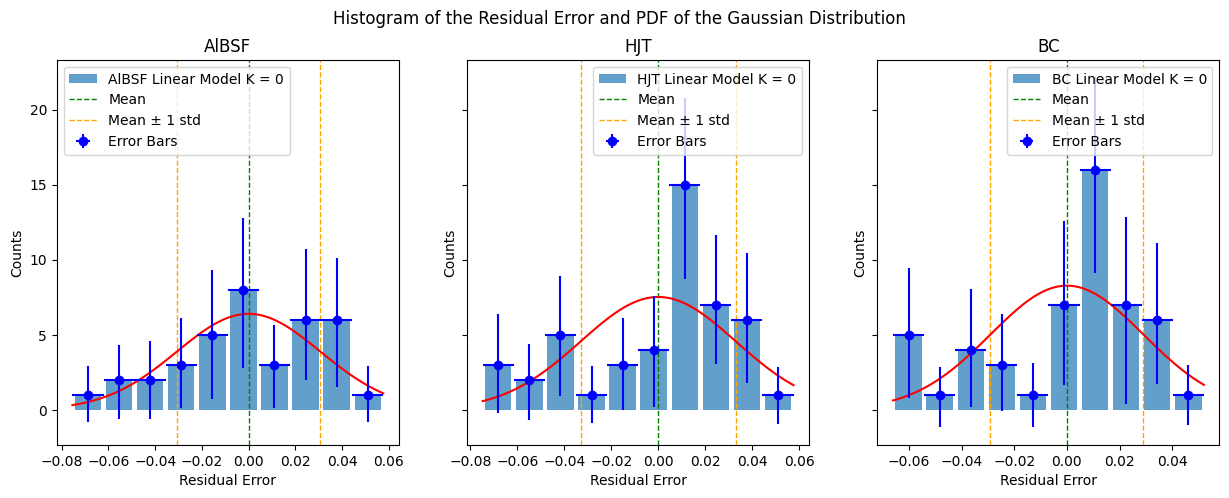

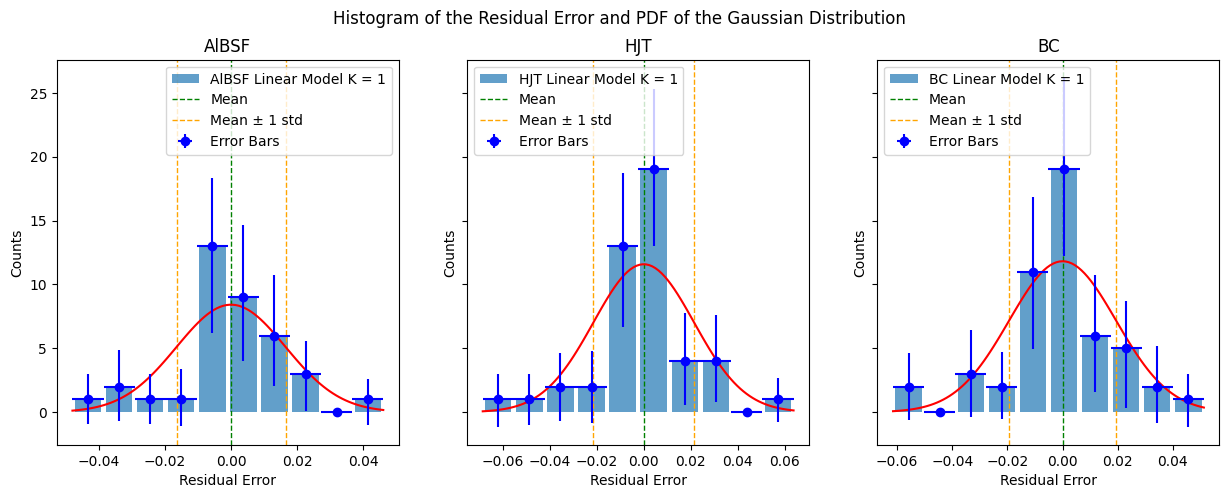

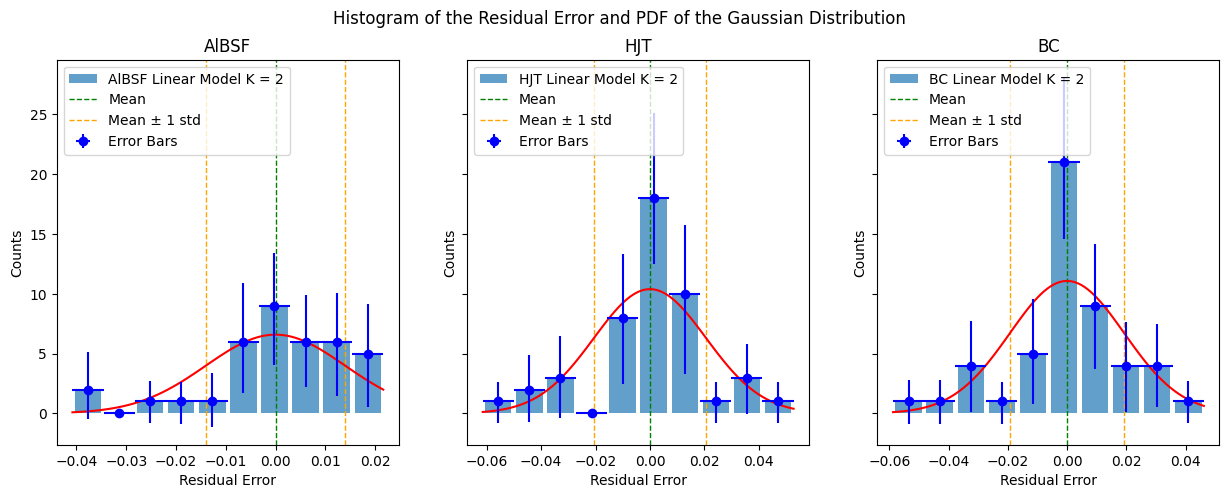

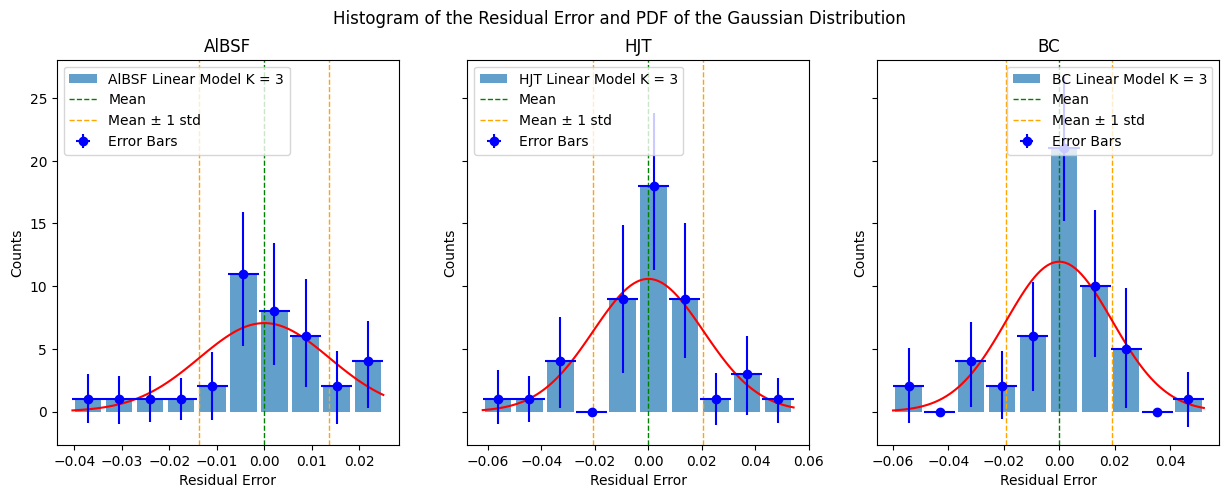

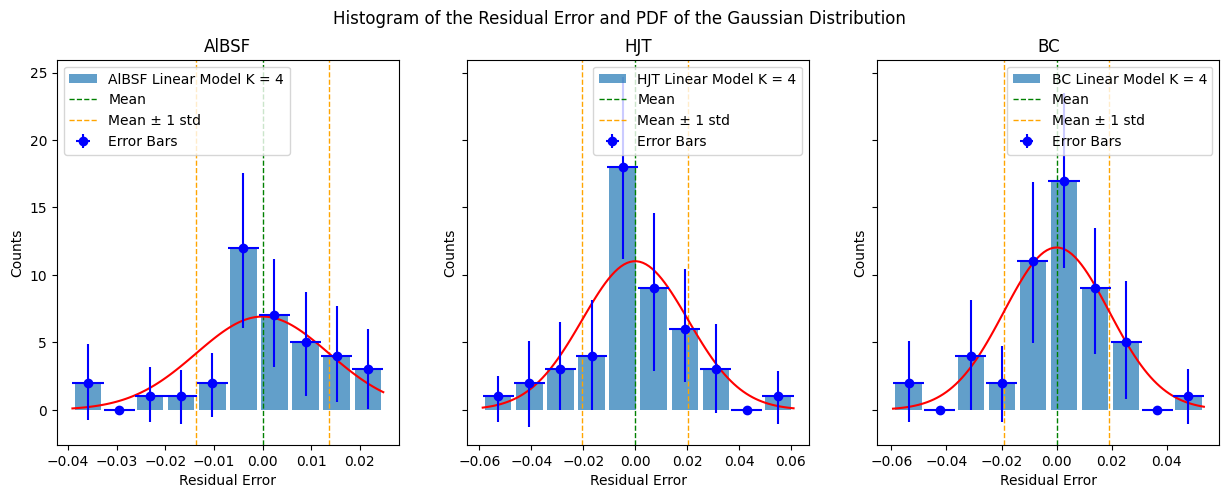

In [6]:
# Linear Models
for i in range(0, len(c_al)):
  # Create subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

  # Plot for AlBSF
  mu, std = plot_residuals(ax1, c_al[i], f'AlBSF Linear Model K = {i}')
  ax1.set_title('AlBSF')

  # Plot for HJT
  mu4, std4 = plot_residuals(ax2, c_hjt[i], f'HJT Linear Model K = {i}')
  ax2.set_title('HJT')

  # Plot for BC
  mu7, std7 = plot_residuals(ax3, c_bc[i], f'BC Linear Model K = {i}')
  ax3.set_title('BC')

  stats_matrix[f'Linear_{i}'] = mu,mu4,mu7, std, std4, std7
  # Set common labels
  for ax in [ax1, ax2, ax3]:
      ax.set_xlabel('Residual Error')
      ax.set_ylabel('Counts')
      ax.legend(loc='best')

  plt.suptitle("Histogram of the Residual Error and PDF of the Gaussian Distribution")
  plt.show()

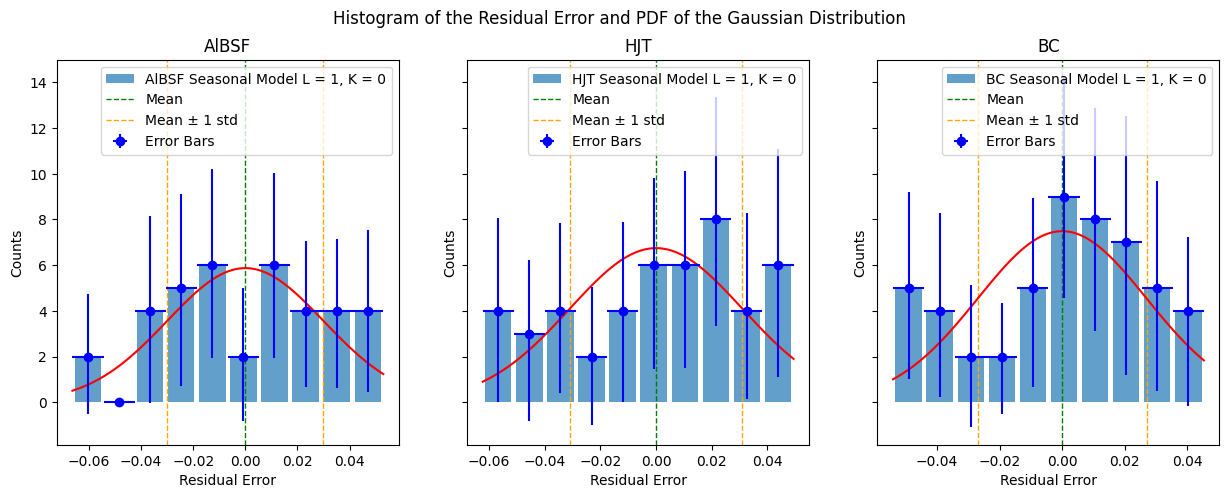

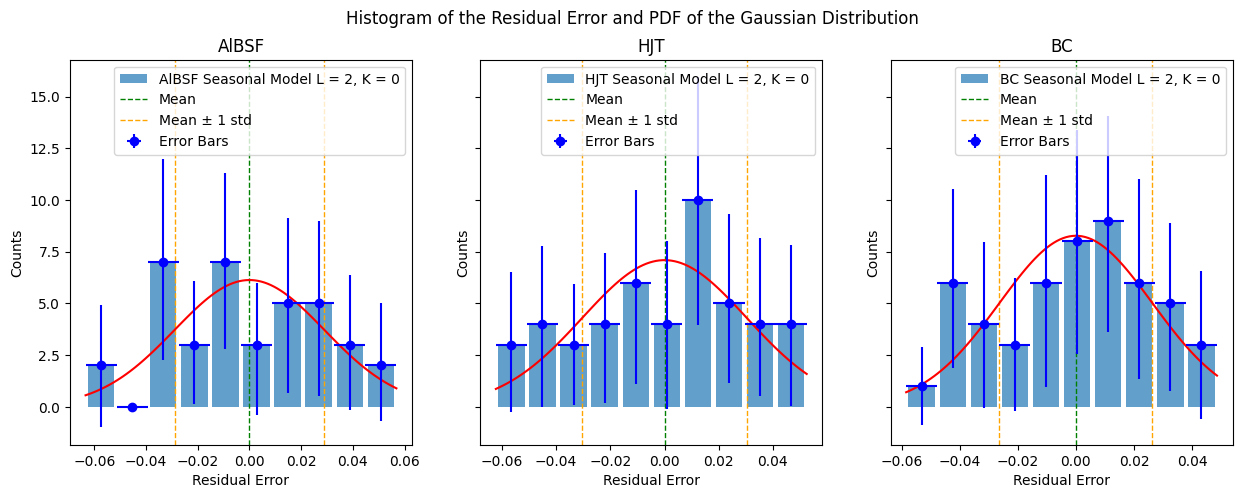

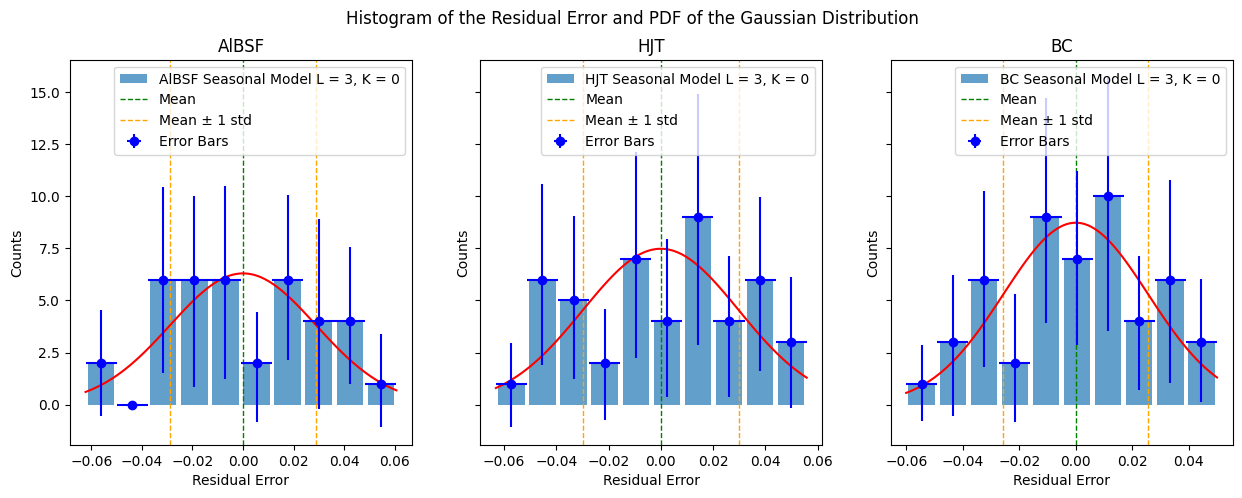

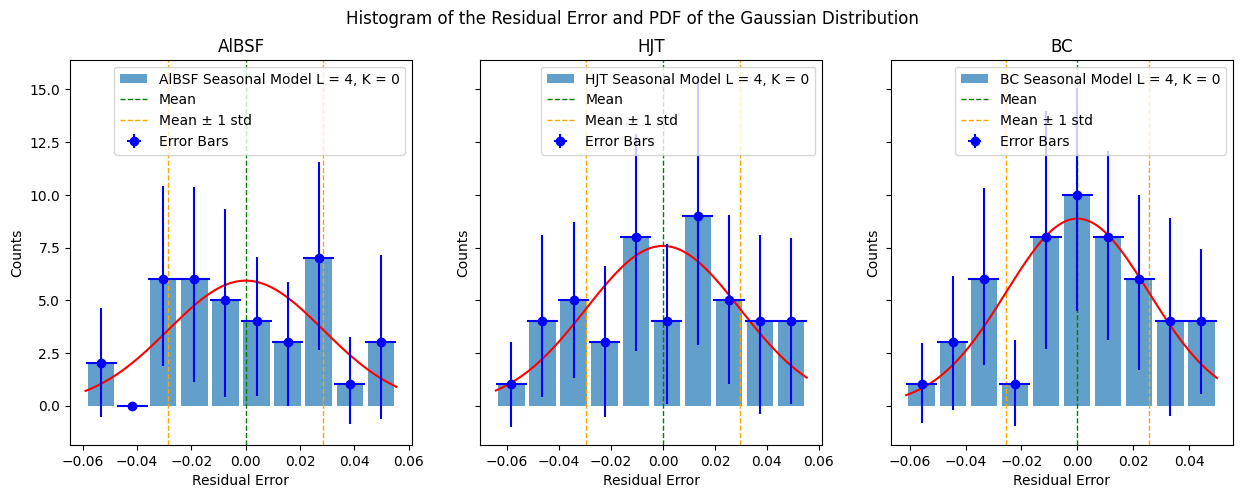

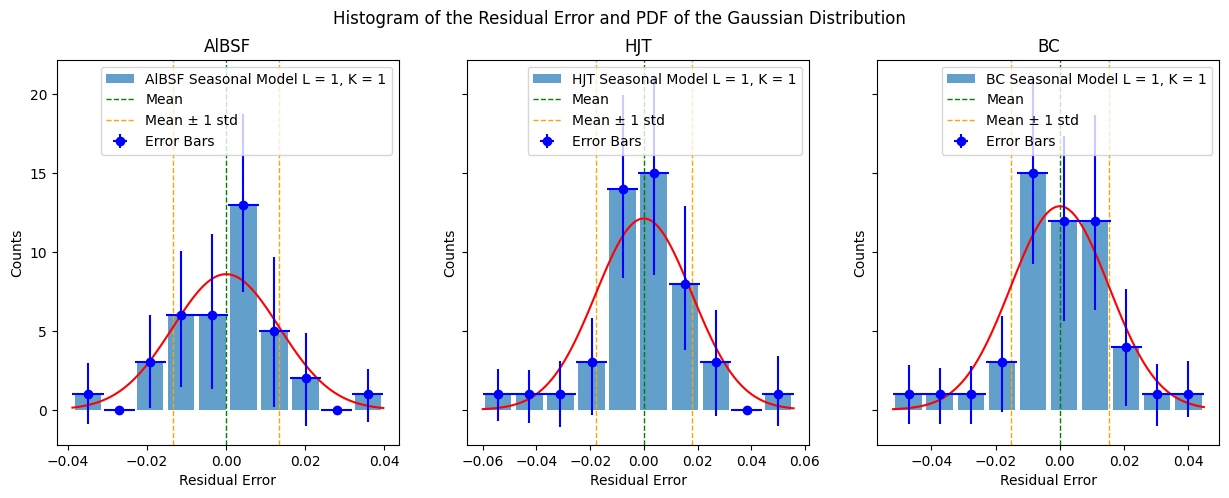

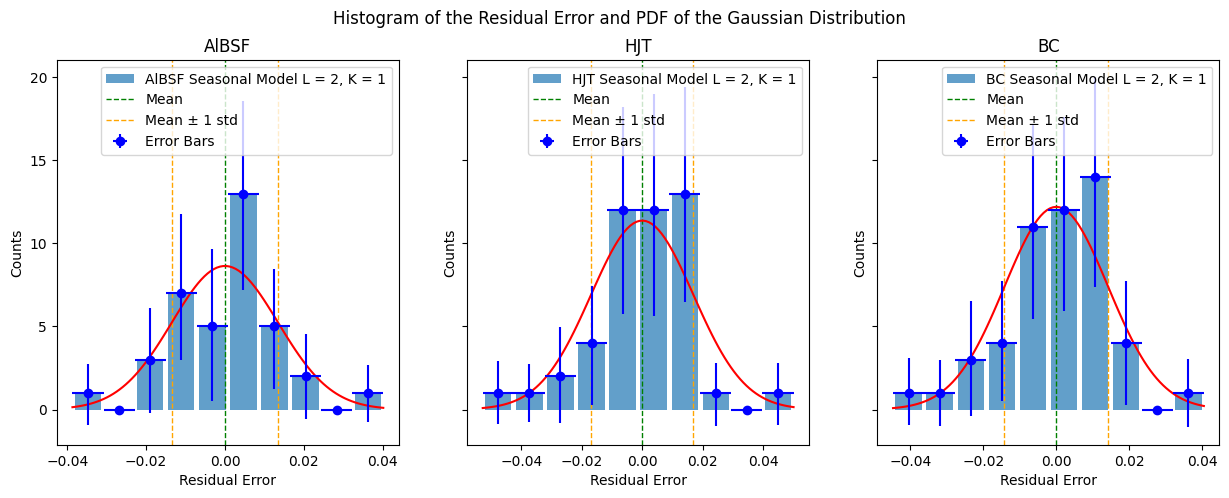

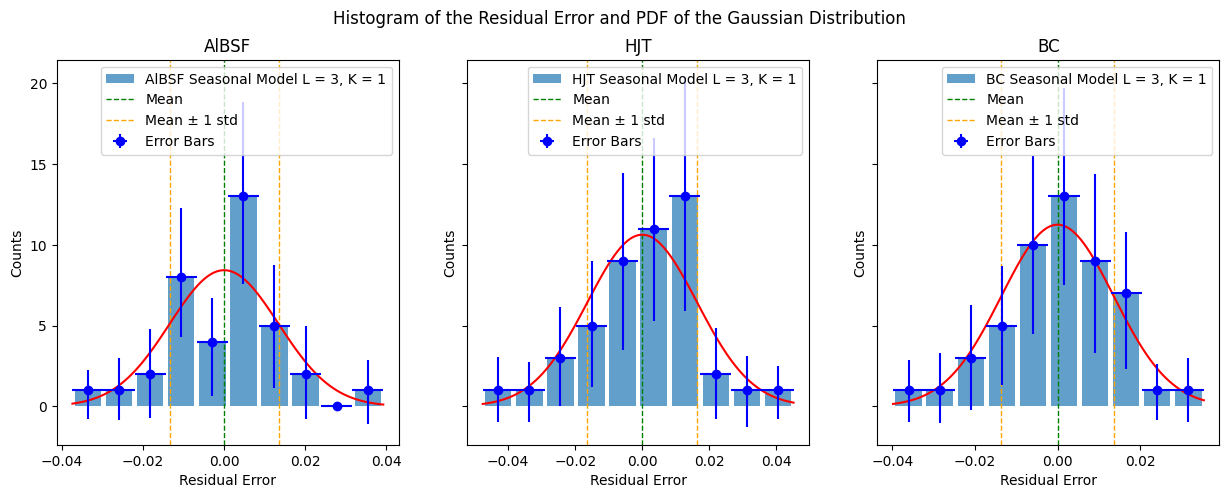

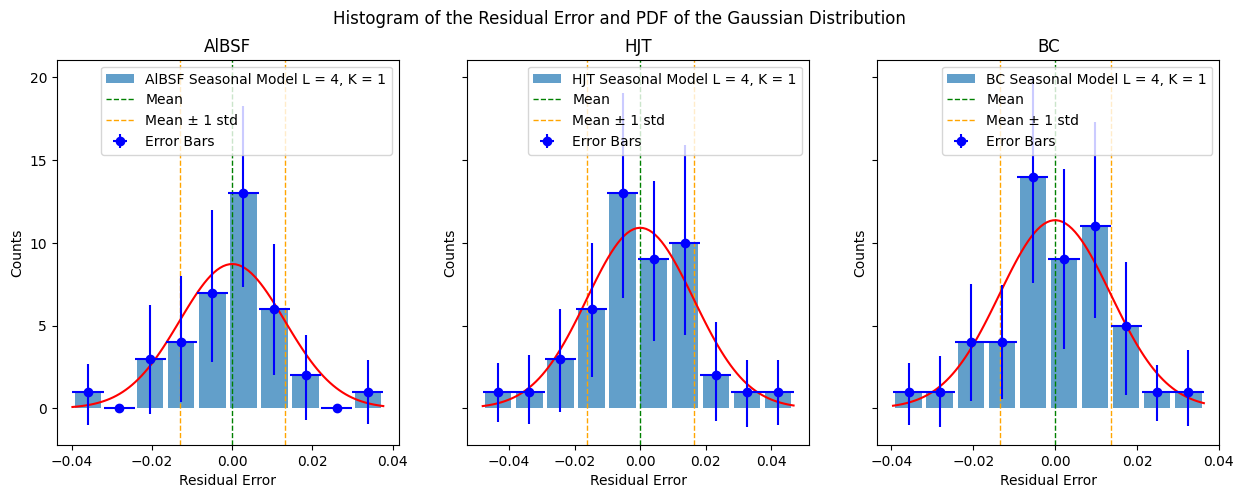

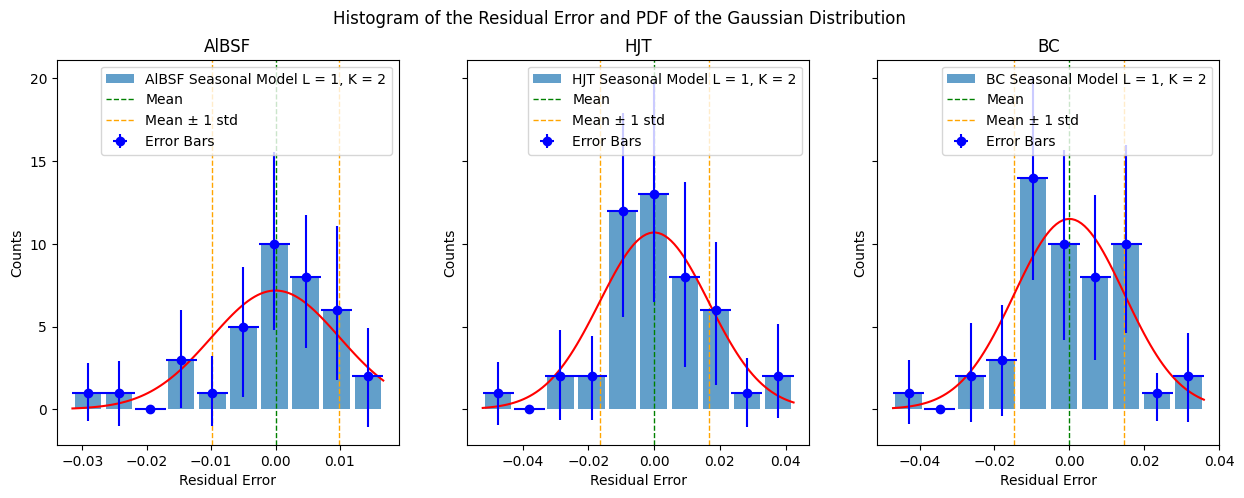

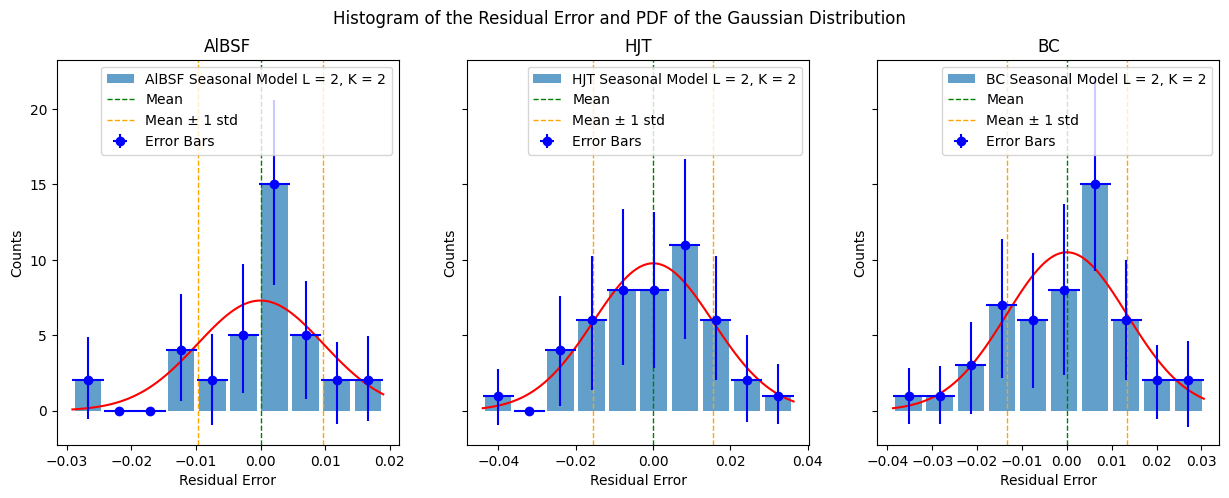

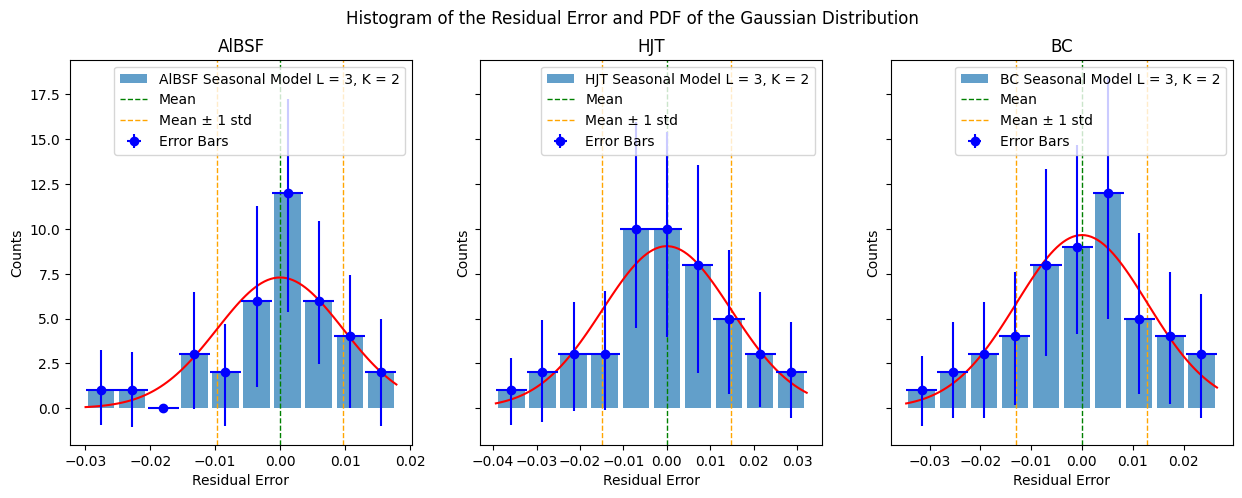

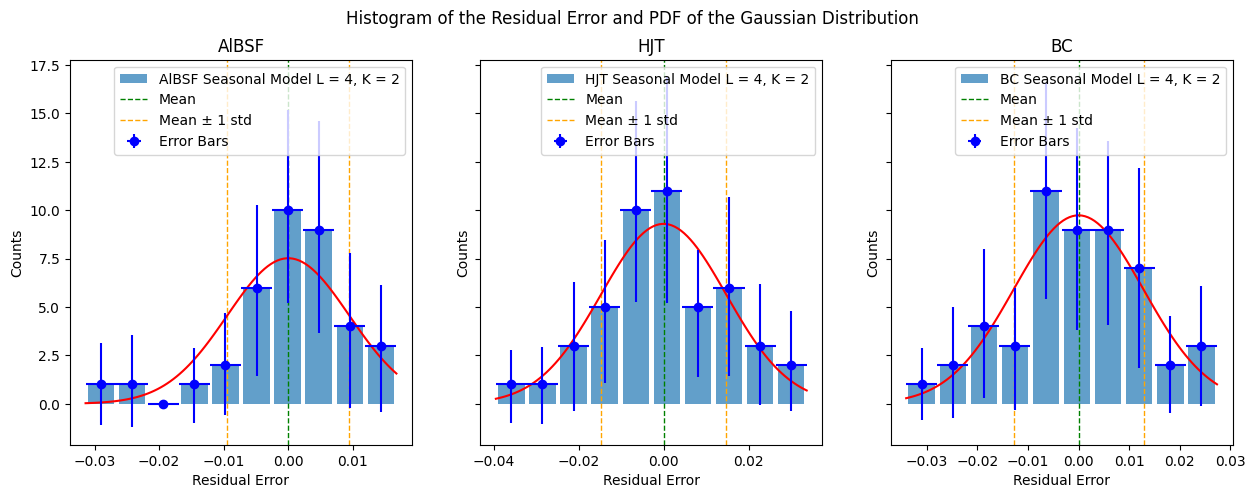

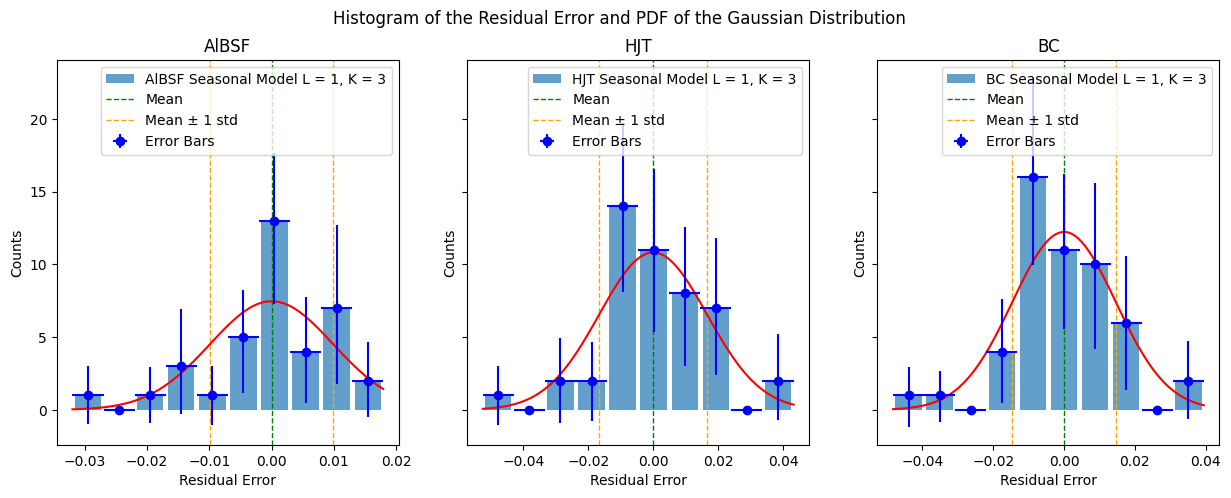

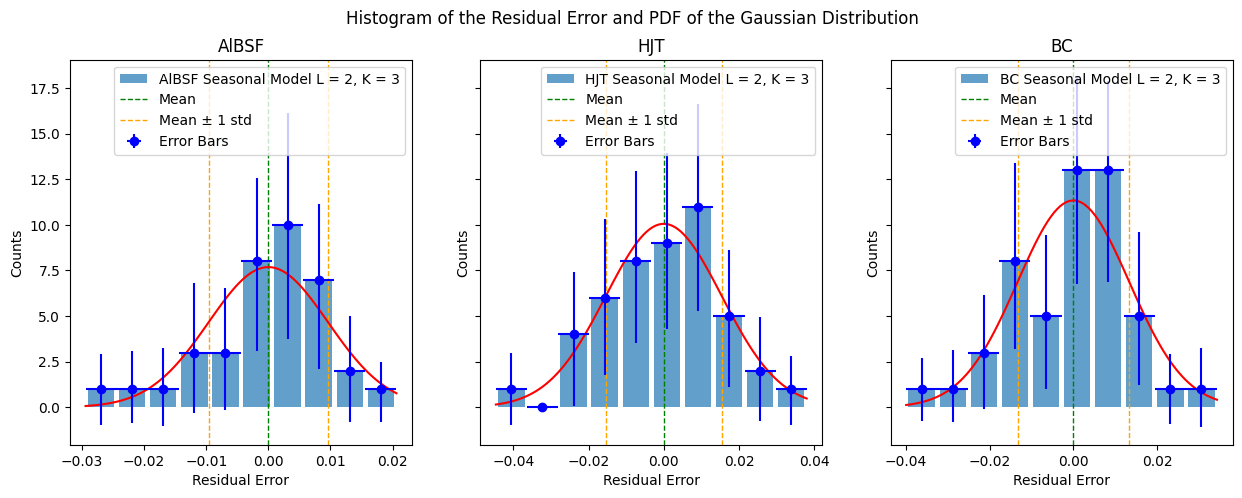

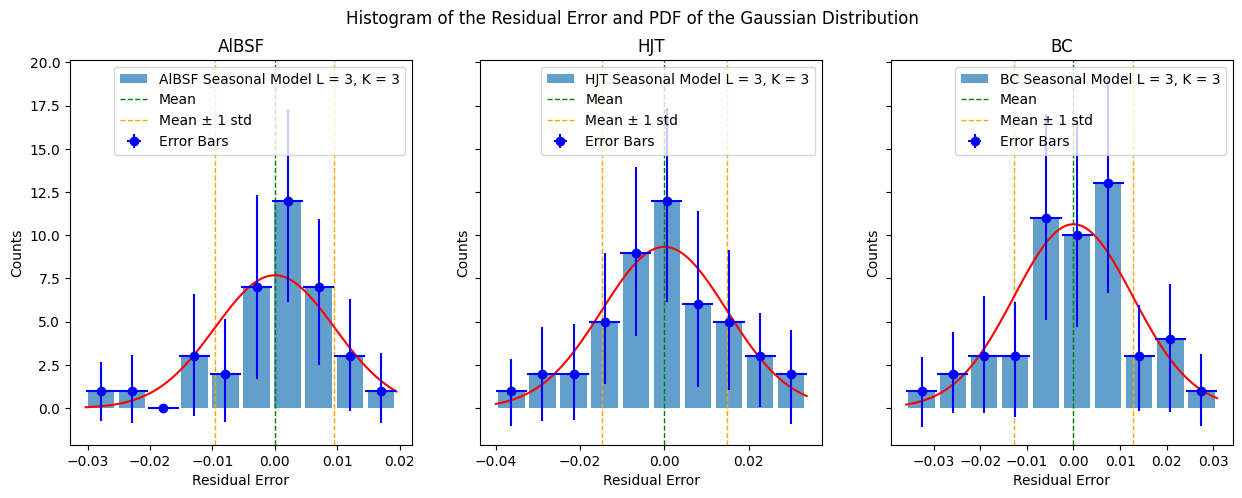

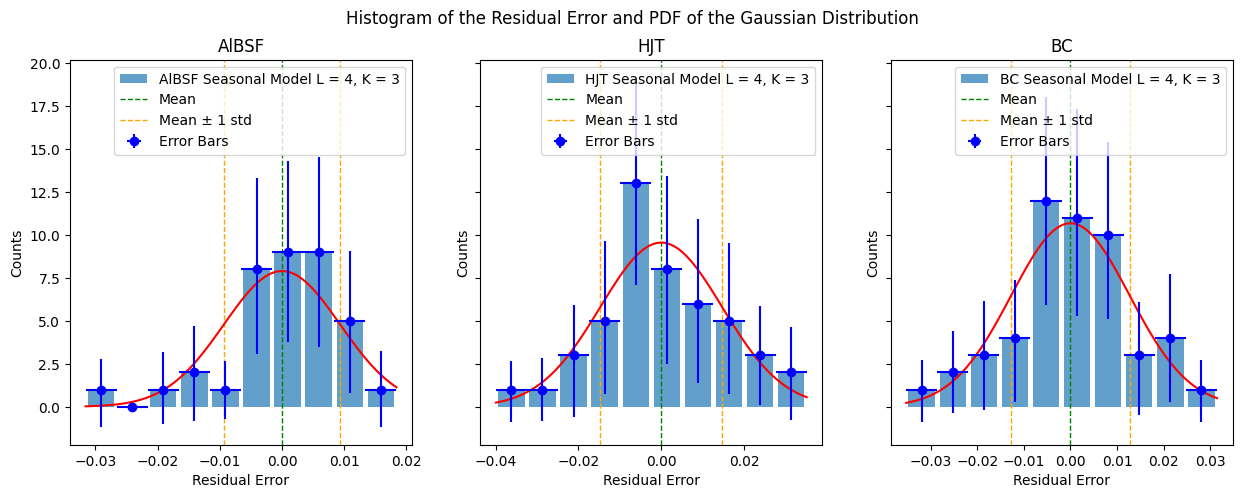

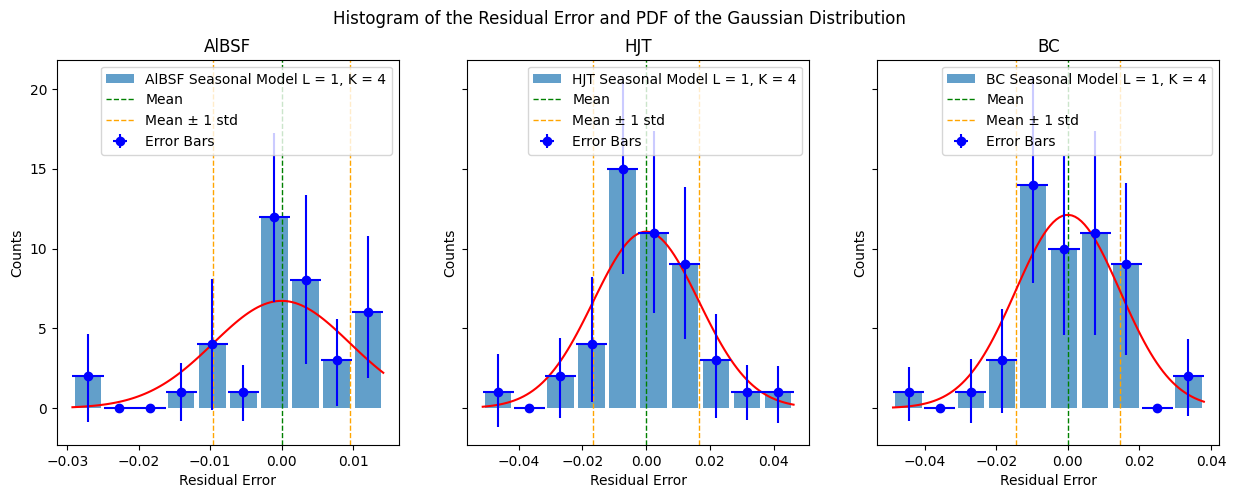

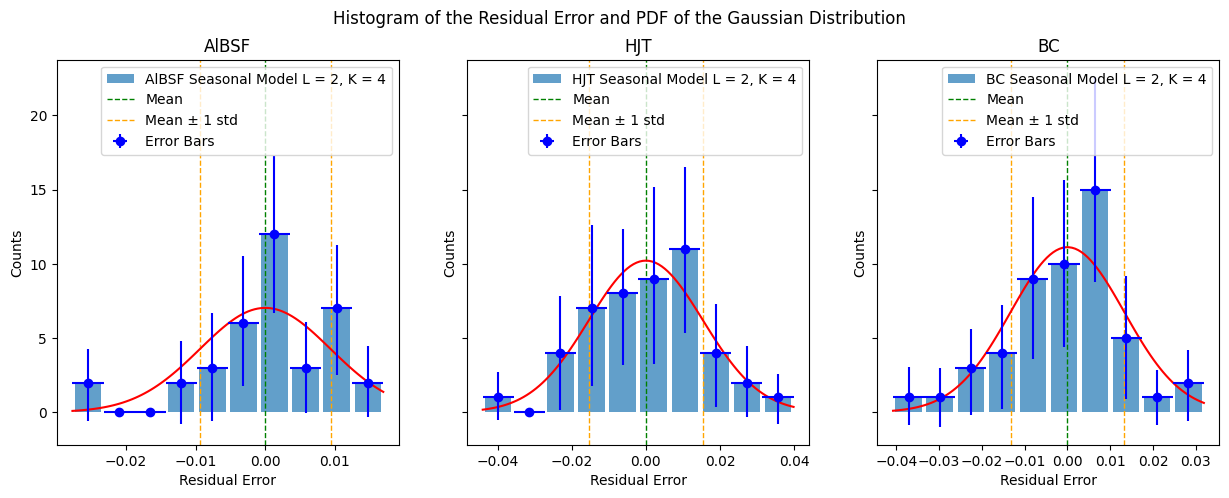

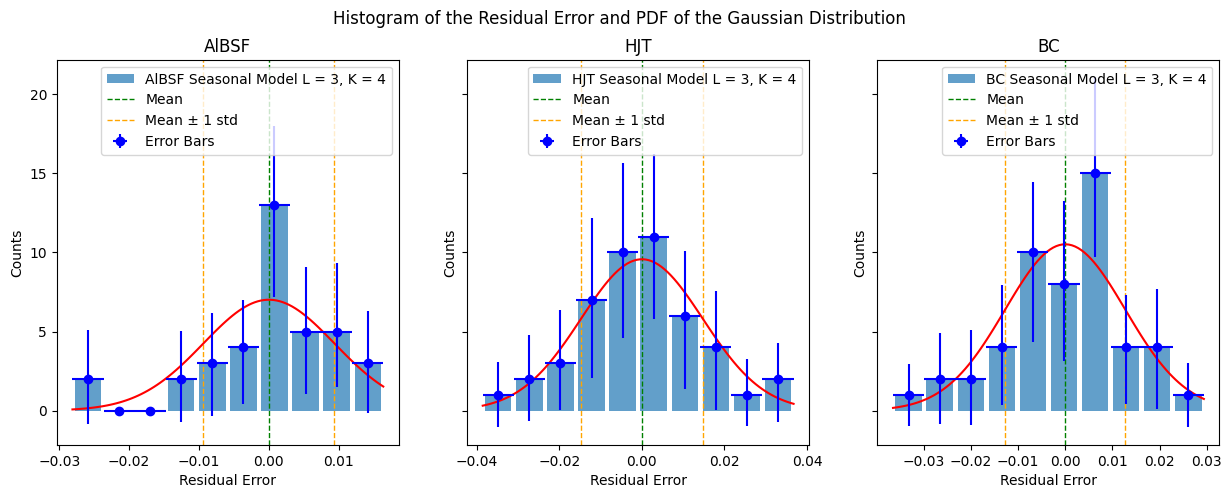

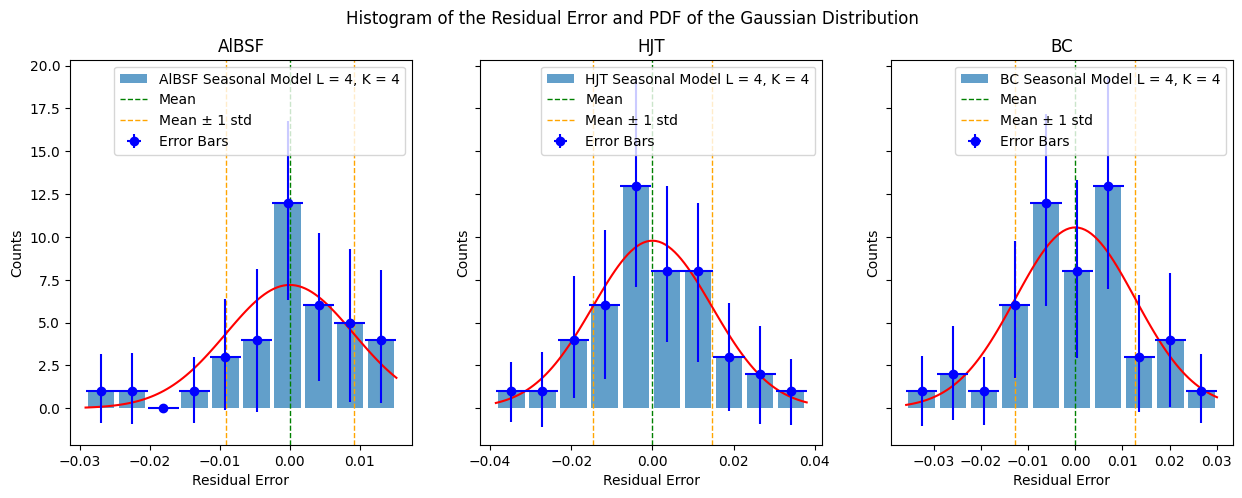

In [7]:
# Seasonal Models
l = 0; k = 0
for i in range(0, len(al_s_res)):
  if l == L: k += 1; l=1
  else: l += 1
  # Create subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

  # Plot for AlBSF
  mu, std = plot_residuals(ax1, al_s_res[i], f'AlBSF Seasonal Model L = {l}, K = {k}')
  ax1.set_title('AlBSF')

  # Plot for HJT
  mu4, std4 = plot_residuals(ax2, hjt_s_res[i], f'HJT Seasonal Model L = {l}, K = {k}')
  ax2.set_title('HJT')

  # Plot for BC
  mu7, std7 = plot_residuals(ax3, bc_s_res[i], f'BC Seasonal Model L = {l}, K = {k}')
  ax3.set_title('BC')

  stats_matrix[f'L_{k}_S_{l}'] = mu,mu4,mu7,std,std4,std7
  # Set common labels
  for ax in [ax1, ax2, ax3]:
      ax.set_xlabel('Residual Error')
      ax.set_ylabel('Counts')
      ax.legend(loc='best')

  plt.suptitle("Histogram of the Residual Error and PDF of the Gaussian Distribution")
  plt.show()

In [8]:
stats_matrix

Linear_0      Linear_1      Linear_2      Linear_3  \
AlBSF_mu  -7.351477e-17 -3.150633e-17  2.971347e-15 -3.577244e-14   
HJT_mu     8.326673e-17  1.647618e-16  2.169659e-15  4.205501e-14   
BC_mu      9.251859e-17 -2.013640e-17  9.943027e-16  2.723812e-13   
AlBSF_std  3.071859e-02  1.647870e-02  1.399381e-02  1.368353e-02   
HJT_std    3.300561e-02  2.142259e-02  2.060472e-02  2.059496e-02   
BC_std     2.905162e-02  1.941940e-02  1.925768e-02  1.909161e-02   

               Linear_4       L_0_S_1       L_0_S_2       L_0_S_3  \
AlBSF_mu   4.366181e-12 -9.226854e-17 -9.901989e-17 -1.725347e-17   
HJT_mu     1.761114e-11  6.436931e-17  1.062979e-16  1.771632e-16   
BC_mu      6.441029e-12  1.469413e-16  6.367456e-17 -1.523836e-17   
AlBSF_std  1.363780e-02  2.999474e-02  2.897575e-02  2.877767e-02   
HJT_std    2.037094e-02  3.105383e-02  3.033832e-02  2.981838e-02   
BC_std     1.908383e-02  2.699607e-02  2.632388e-02  2.566706e-02   

                L_0_S_4       L_1_S_1  ...       L_2_S_3       L_2_S_4  \
AlBSF_mu  -1.245250e-16 -5.176040e-17  ...  5.195994e-14  4.890983e-14   
HJT_mu     2.616111e-16  1.475770e-15  ...  7.187513e-15  1.351756e-15   
BC_mu      7.673600e-17  3.711628e-16  ...  1.502066e-16  5.433562e-15   
AlBSF_std  2.850288e-02  1.347640e-02  ...  9.693083e-03  9.447073e-03   
HJT_std    2.961636e-02  1.789872e-02  ...  1.484530e-02  1.475205e-02   
BC_std     2.548050e-02  1.524292e-02  ...  1.289039e-02  1.285047e-02   

                L_3_S_1       L_3_S_2       L_3_S_3       L_3_S_4  \
AlBSF_mu   3.167961e-14 -7.390935e-14  1.600912e-13 -2.231106e-13   
HJT_mu     4.119341e-14 -9.583528e-14  1.178891e-13  2.037425e-13   
BC_mu     -2.384193e-13 -5.380173e-14 -1.893153e-13 -2.783721e-15   
AlBSF_std  9.862151e-03  9.614001e-03  9.576145e-03  9.339549e-03   
HJT_std    1.659616e-02  1.541768e-02  1.482568e-02  1.473752e-02   
BC_std     1.460351e-02  1.333253e-02  1.275416e-02  1.271489e-02   

                L_4_S_1       L_4_S_2       L_4_S_3       L_4_S_4  
AlBSF_mu   4.577863e-12  6.092397e-12 -1.094919e-11 -1.751639e-12  
HJT_mu    -4.634934e-12 -3.711948e-13  1.564348e-11 -4.465112e-12  
BC_mu      9.085668e-13  2.632702e-11 -8.363983e-12 -2.420149e-11  
AlBSF_std  9.548198e-03  9.380805e-03  9.366372e-03  9.114628e-03  
HJT_std    1.654703e-02  1.539824e-02  1.476384e-02  1.467864e-02  
BC_std     1.459158e-02  1.329670e-02  1.273980e-02  1.270051e-02  

[6 rows x 25 columns]

# Finding the best model

## CV

In [9]:
# Cross-Validation
rows = ['AlBSF', 'HJT', 'BC']
cv_rmse_al = {}; cv_rmse_hjt = {}; cv_rmse_bc = {}
cv_mae_al = {}; cv_mae_hjt = {}; cv_mae_bc = {}
cv_aic_al = {}; cv_aic_hjt = {}; cv_aic_bc = {}
cv_bic_al = {}; cv_bic_hjt = {}; cv_bic_bc = {}

In [10]:
def loocv2(X, y):
    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    rmse_sc, mae_sc = [], []

    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        model = sm.OLS(y_train, X_train).fit()
        y_pr = model.predict(X_test)

        y_true.append(y_test)
        y_pred.append(y_pr)

        rmse_sc.append(np.sqrt(mean_squared_error(y_true, y_pred)))
        mae_sc.append(mean_absolute_error(y_true, y_pred))
    
    # rmse_sc = np.sqrt(rmse_sc)
    return rmse_sc, mae_sc

In [11]:
# this
for r in range(0, K+1):
  # AlBSF
  # Use LOOCV to evaluate model
  rmse_scores, mae_scores = loocv2(x_linear[l_col[0:r+1]].values, y.values)

  cv_rmse_al[f'K_{r}'] = rmse_scores
  cv_mae_al[f'K_{r}'] = mae_scores
  cv_aic_al[f'K_{r}'] = sm.OLS(y, x_linear[l_col[0:r+1]]).fit().aic
  cv_bic_al[f'K_{r}'] = sm.OLS(y, x_linear[l_col[0:r+1]]).fit().bic

  # HJT
  rmse_scores, mae_scores = loocv2(x4_l[l_col[0:r+1]].values, y4.values)

  cv_rmse_hjt[f'K_{r}'] = rmse_scores
  cv_mae_hjt[f'K_{r}'] = mae_scores
  cv_aic_hjt[f'K_{r}'] = sm.OLS(y4, x4_l[l_col[0:r+1]]).fit().aic
  cv_bic_hjt[f'K_{r}'] = sm.OLS(y4, x4_l[l_col[0:r+1]]).fit().bic

  # BC
  rmse_scores, mae_scores = loocv2(x7_l[l_col[0:r+1]].values, y7.values)

  cv_rmse_bc[f'K_{r}'] = rmse_scores
  cv_mae_bc[f'K_{r}'] = mae_scores
  cv_aic_bc[f'K_{r}'] = sm.OLS(y7, x7_l[l_col[0:r+1]]).fit().aic
  cv_bic_bc[f'K_{r}'] = sm.OLS(y7, x7_l[l_col[0:r+1]]).fit().bic

  # Seasonal Models
  f = 1
  for l in range(1, L + K, 2):
    # print(l)
    # AlBSF
    s_data = Y3a[s_col[0:l+1]]
    x_new = pd.concat((Y3a[l_col[0:r+1]], s_data), axis=1)
    model_s = sm.OLS(y, x_new)
    rmse_scores, mae_scores = loocv2(x_new.values, y.values)

    cv_rmse_al[f'K_{r}_L_{f}'] = rmse_scores
    cv_mae_al[f'K_{r}_L_{f}'] = mae_scores
    cv_aic_al[f'K_{r}_L_{f}'] = model_s.fit().aic
    cv_bic_al[f'K_{r}_L_{f}'] = model_s.fit().bic

    # HJT
    s4_data = Y4a[s_col[0:l+1]]
    x4_new = pd.concat((Y4a[l_col[0:r+1]], s4_data), axis=1)
    m4_s = sm.OLS(y4, x4_new)
    rmse_scores, mae_scores = loocv2(x4_new.values, y4.values)

    cv_rmse_hjt[f'K_{r}_L_{f}'] = rmse_scores
    cv_mae_hjt[f'K_{r}_L_{f}'] = mae_scores
    cv_aic_hjt[f'K_{r}_L_{f}'] = m4_s.fit().aic
    cv_bic_hjt[f'K_{r}_L_{f}'] = m4_s.fit().bic

    # BC
    s7_data = Y7a[s_col[0:l+1]]
    x7_new = pd.concat((Y7a[l_col[0:r+1]], s7_data), axis=1)
    m7_s = sm.OLS(y7, x7_new)
    rmse_scores, mae_scores = loocv2(x7_new.values, y7.values)

    cv_rmse_bc[f'K_{r}_L_{f}'] = rmse_scores
    cv_mae_bc[f'K_{r}_L_{f}'] = mae_scores
    cv_aic_bc[f'K_{r}_L_{f}'] = m7_s.fit().aic
    cv_bic_bc[f'K_{r}_L_{f}'] = m7_s.fit().bic
    f+=1

## Plots

In [12]:
# plots
def plots(metric_1, metric_2, metric_3, metric_name, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)

    # Plot AlBSF
    axs[0].plot(metric_1.keys(), metric_1.values(), marker='o', linestyle='-')
    axs[0].set_title('AlBSF')
    axs[0].set_xlabel('Model Complexity')
    axs[0].set_ylabel(metric_name)
    axs[0].grid(True)
    axs[0].set_xticks(range(len(metric_1)))
    axs[0].set_xticklabels(range(1, len(metric_1) + 1))

    # Plot HJT
    axs[1].plot(metric_2.keys(), metric_2.values(), marker='o', linestyle='-')
    axs[1].set_title('HJT')
    axs[1].set_xlabel('Model Complexity')
    axs[1].set_ylabel(metric_name)
    axs[1].grid(True)
    axs[1].set_xticks(range(len(metric_2)))
    axs[1].set_xticklabels(range(1, len(metric_2) + 1))

    # Plot BC
    axs[2].plot(metric_3.keys(), metric_3.values(), marker='o', linestyle='-')
    axs[2].set_title('BC')
    axs[2].set_xlabel('Model Complexity')
    axs[2].set_ylabel(metric_name)
    axs[2].grid(True)
    axs[2].set_xticks(range(len(metric_3)))
    axs[2].set_xticklabels(range(1, len(metric_3) + 1))

    plt.tight_layout()
    plt.show()



In [13]:
def plots2(metric_1, metric_2, metric_3, metric_name, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)

    def plot_metric(ax, metric, title):
        keys = list(metric.keys())
        values = list(metric.values())
        
        # Parse K_numbers
        k_numbers = [key.split('_')[1] for key in keys]
        unique_k_numbers = list(set(k_numbers))
        
        # Create a color map
        colors = plt.cm.jet(np.linspace(0, 1, len(unique_k_numbers)))
        color_dict = {k: colors[i] for i, k in enumerate(unique_k_numbers)}
        
        # Initialize starting point for the segment
        start_idx = 0
        
        # Iterate through the keys and plot segments when K_number changes
        for i in range(1, len(keys)):
            if k_numbers[i] != k_numbers[i - 1]:
                ax.plot(keys[start_idx:i], values[start_idx:i], marker='o', linestyle='-', color=color_dict[k_numbers[i - 1]])
                start_idx = i
        
        # Plot the last segment
        ax.plot(keys[start_idx:], values[start_idx:], marker='o', linestyle='-', color=color_dict[k_numbers[start_idx]])

        ax.set_title(title)
        ax.set_xlabel('Models')
        ax.set_ylabel(metric_name)
        ax.grid(True)
        ax.set_xticks(range(len(metric)))
        ax.set_xticklabels(range(1, len(metric) + 1))

    # Plot AlBSF
    plot_metric(axs[0], metric_1, 'AlBSF')
    
    # Plot HJT
    plot_metric(axs[1], metric_2, 'HJT')
    
    # Plot BC
    plot_metric(axs[2], metric_3, 'BC')

    plt.tight_layout()
    plt.show()

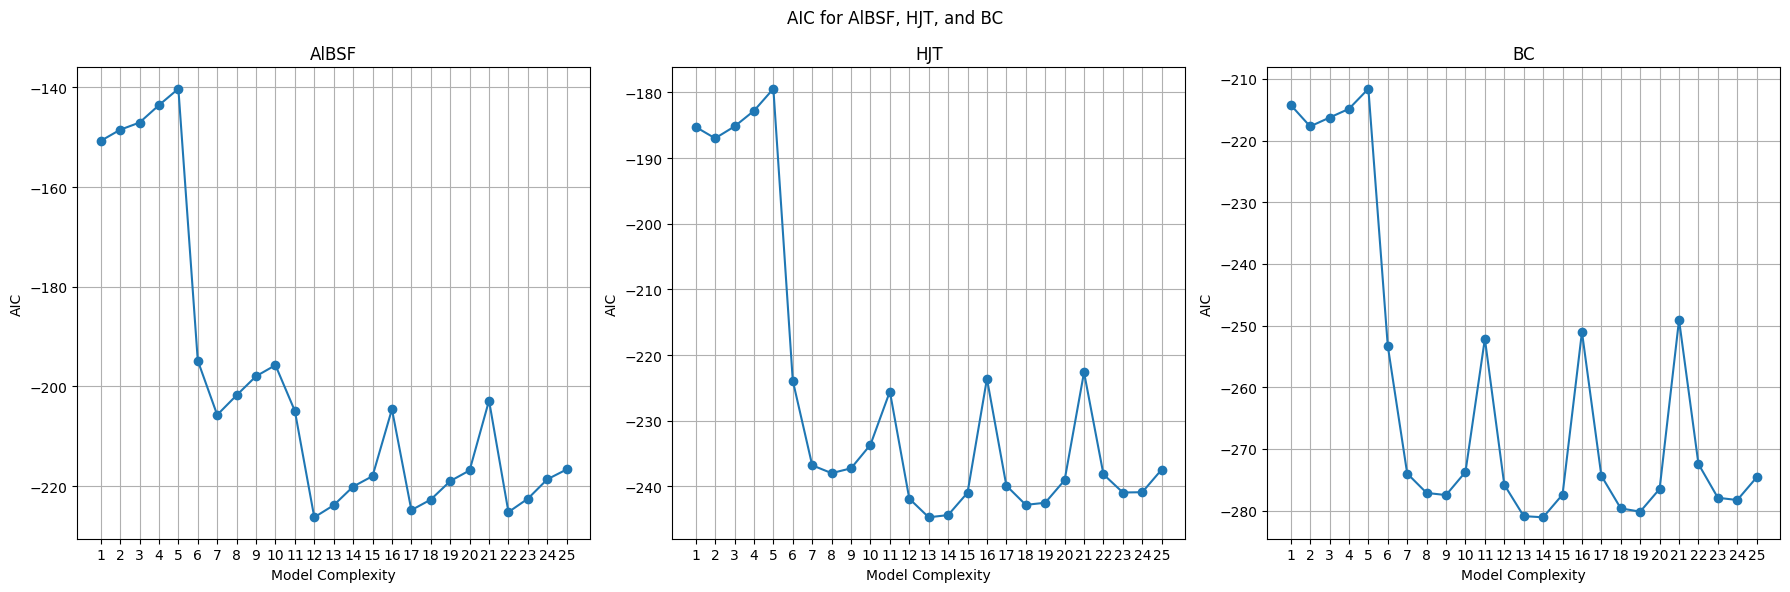

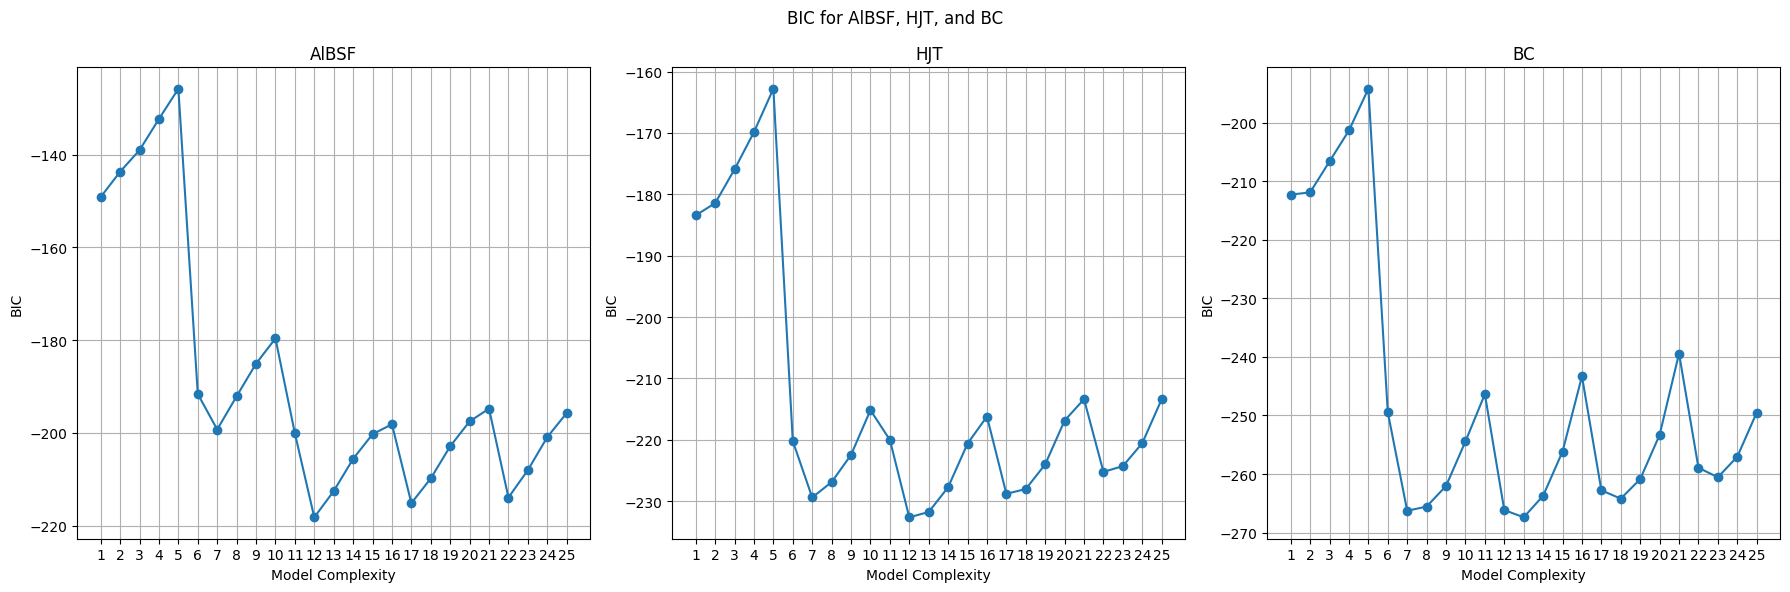

In [14]:
plots(cv_aic_al, cv_aic_hjt, cv_aic_bc, 'AIC', 'AIC for AlBSF, HJT, and BC')
plots(cv_bic_al, cv_bic_hjt, cv_bic_bc, 'BIC', 'BIC for AlBSF, HJT, and BC')

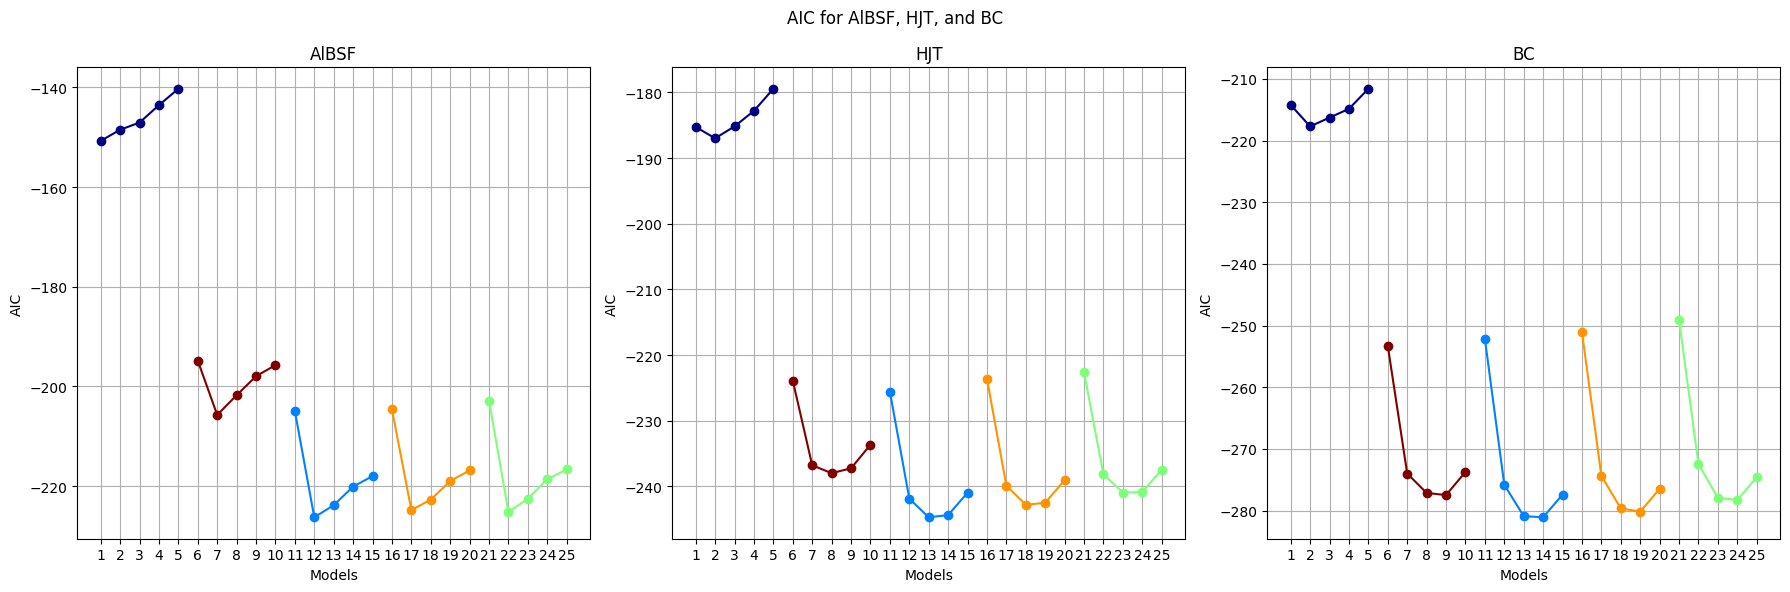

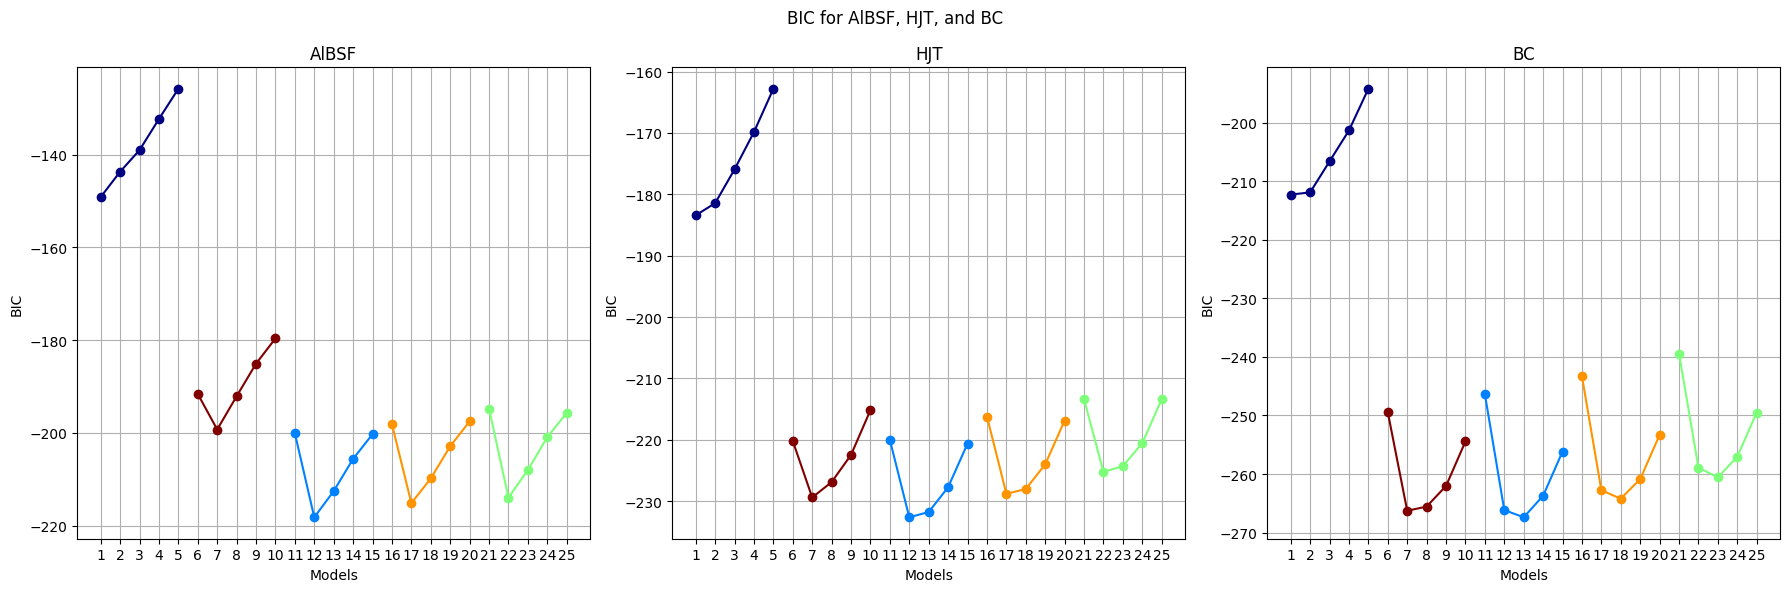

In [15]:
plots2(cv_aic_al, cv_aic_hjt, cv_aic_bc, 'AIC', 'AIC for AlBSF, HJT, and BC')
plots2(cv_bic_al, cv_bic_hjt, cv_bic_bc, 'BIC', 'BIC for AlBSF, HJT, and BC')

In [16]:
cv_rmseal = {key: statistics.mean(values) for key, values in cv_rmse_al.items()}
cv_rmsehjt = {key: statistics.mean(values) for key, values in cv_rmse_hjt.items()}
cv_rmsebc = {key: statistics.mean(values) for key, values in cv_rmse_bc.items()}
cv_maeal = {key: statistics.mean(values) for key, values in cv_mae_al.items()}
cv_maehjt = {key: statistics.mean(values) for key, values in cv_mae_hjt.items()}
cv_maebc = {key: statistics.mean(values) for key, values in cv_mae_bc.items()}

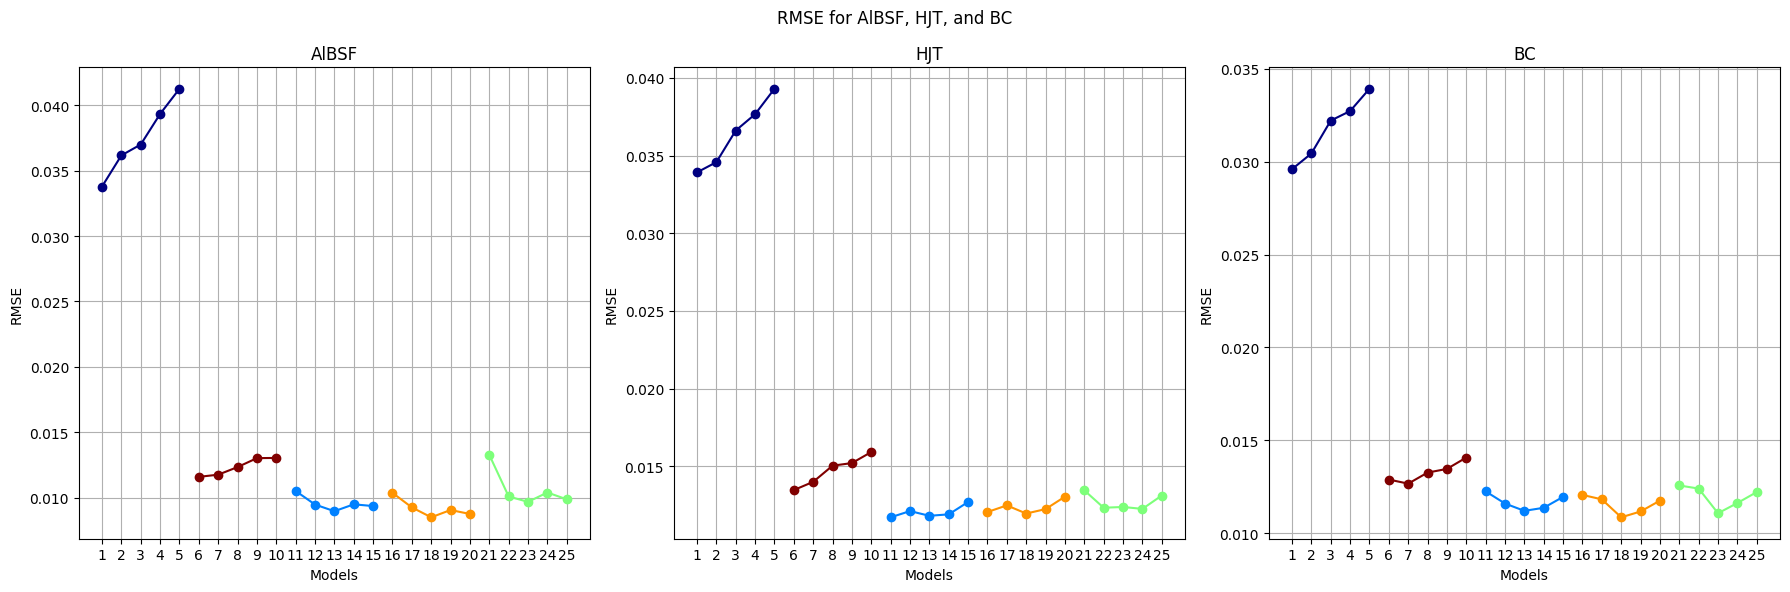

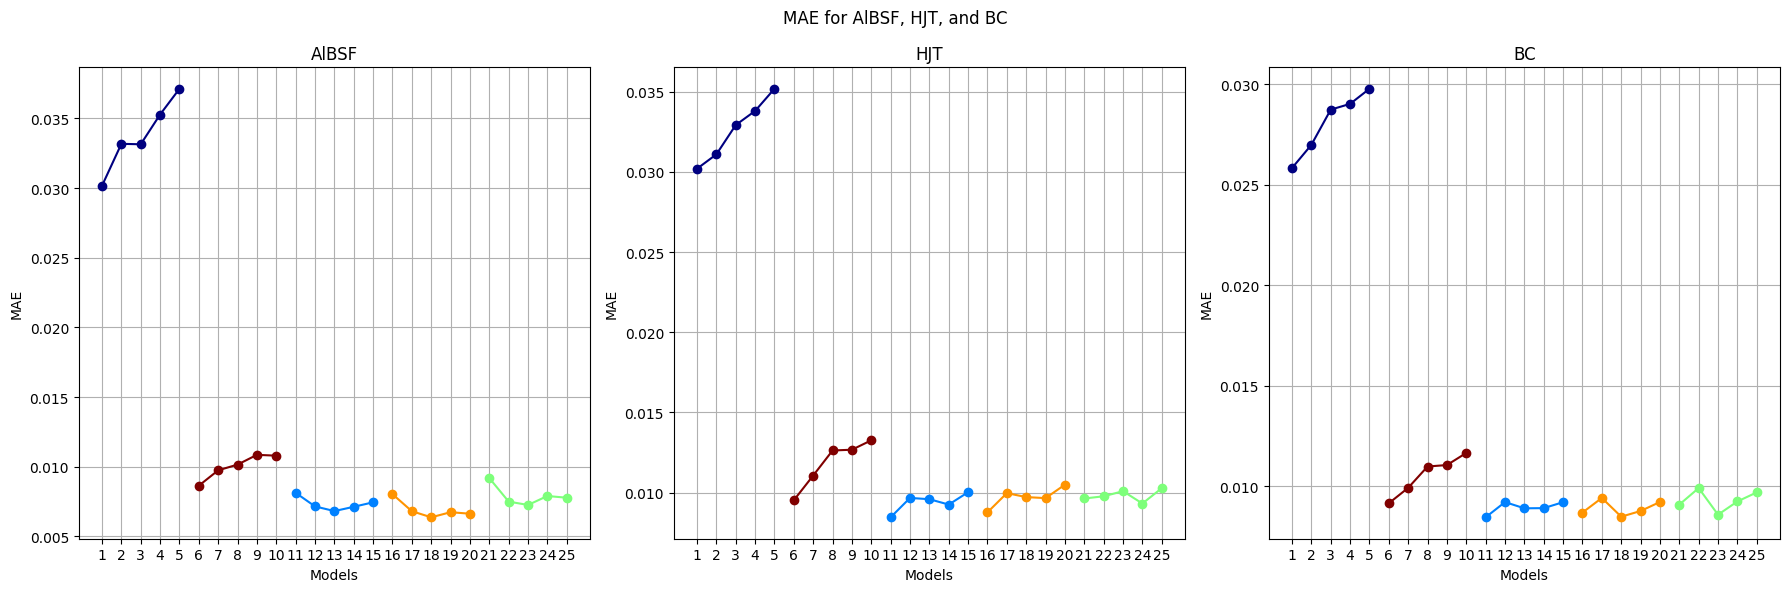

In [17]:
plots2(cv_rmseal, cv_rmsehjt, cv_rmsebc, 'RMSE', 'RMSE for AlBSF, HJT, and BC')
plots2(cv_maeal, cv_maehjt, cv_maebc, 'MAE', 'MAE for AlBSF, HJT, and BC')

In [18]:
def box_plots(metric_1, metric_2, metric_3, metric_name, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)

    # AlBSF
    axs[0].boxplot(list(metric_1.values()), labels=list(metric_1.keys()))
    axs[0].set_title('AlBSF')
    axs[0].set_xlabel('Models')
    axs[0].set_ylabel(metric_name)
    axs[0].set_xticklabels(range(1, len(metric_1) + 1))

    # HJT
    axs[1].boxplot(list(metric_2.values()), labels=list(metric_2.keys()))
    axs[1].set_title('HJT')
    axs[1].set_xlabel('Models')
    axs[1].set_ylabel(metric_name)
    axs[1].set_xticklabels(range(1, len(metric_2) + 1))

    # BC
    axs[2].boxplot(list(metric_3.values()), labels=list(metric_3.keys()))
    axs[2].set_title('BC')
    axs[2].set_xlabel('Models')
    axs[2].set_ylabel(metric_name)
    axs[2].set_xticklabels(range(1, len(metric_3) + 1))

    plt.tight_layout()
    plt.show()


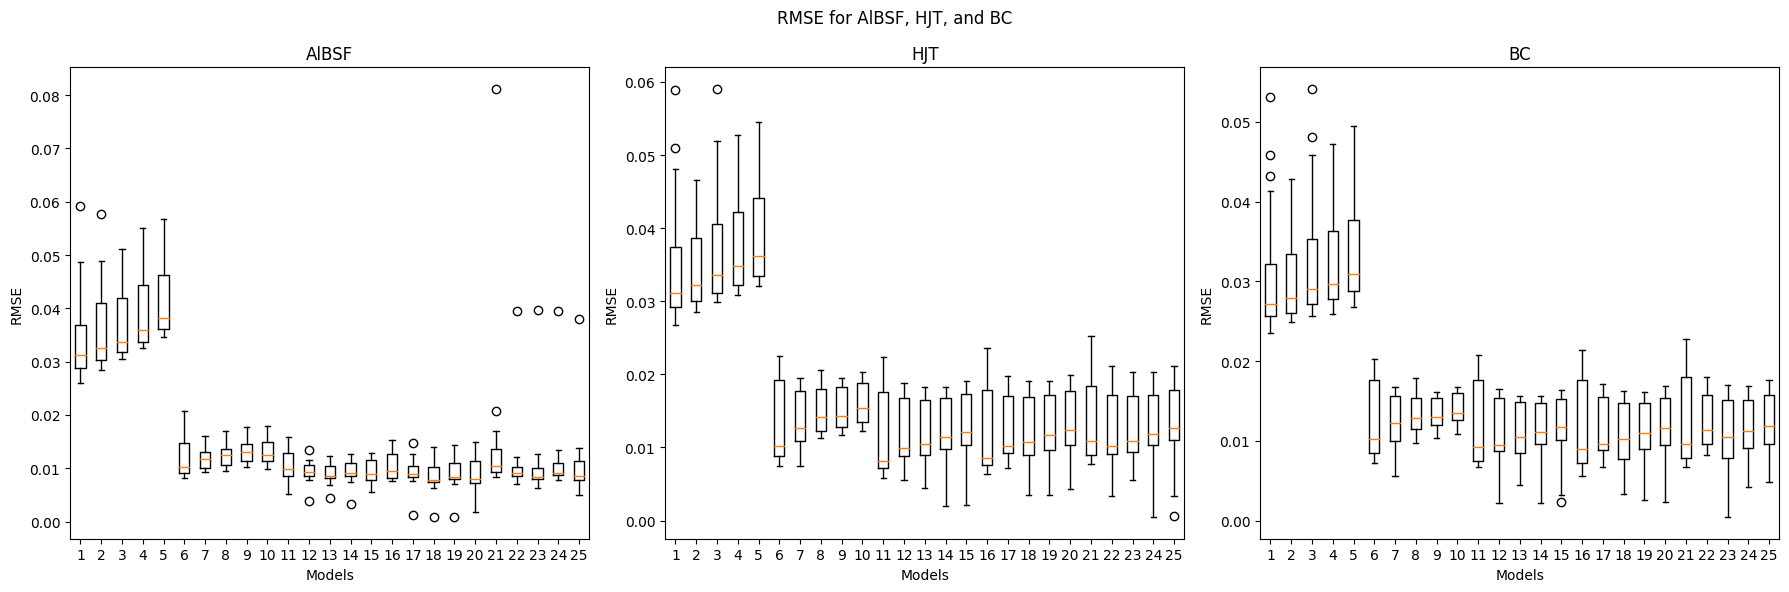

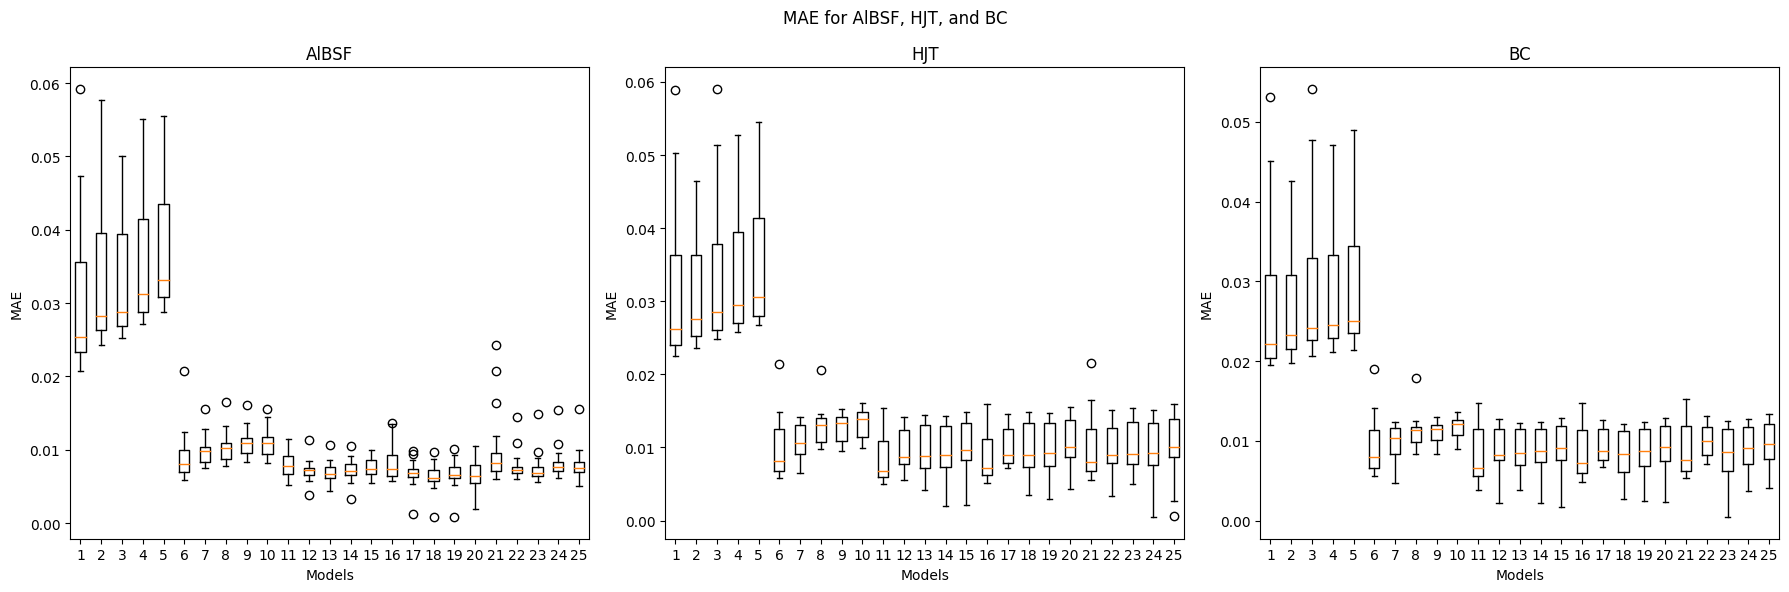

In [19]:
box_plots(cv_rmse_al, cv_rmse_hjt, cv_rmse_bc, 'RMSE', 'RMSE for AlBSF, HJT, and BC')
box_plots(cv_mae_al, cv_mae_hjt, cv_mae_bc, 'MAE', 'MAE for AlBSF, HJT, and BC')

## Best model results

In [20]:
# Results
# AlBSF
keys = list(cv_mae_al.keys())
# AIC
al_aic = list(filter(lambda x: cv_aic_al[x] == min(cv_aic_al.values()), cv_aic_al))[0]
print(al_aic)
# BIC
al_bic = list(filter(lambda x: cv_bic_al[x] == min(cv_bic_al.values()), cv_bic_al))[0]
print(al_bic)
# RMSE
al_rmse = list(filter(lambda x: cv_rmse_al[x] == min(cv_rmse_al.values()), cv_rmse_al))[0]
print(al_rmse)
# MAE
al_mae = list(filter(lambda x: cv_mae_al[x] == min(cv_mae_al.values()), cv_mae_al))[0]
print(al_mae)

K_2_L_1
K_2_L_1
K_3_L_3
K_3_L_3


In [21]:
# HJT
keys = list(cv_mae_hjt.keys())
# AIC
hjt_aic = list(filter(lambda x: cv_aic_hjt[x] == min(cv_aic_hjt.values()), cv_aic_hjt))[0]
print(hjt_aic)
# BIC
hjt_bic = list(filter(lambda x: cv_bic_hjt[x] == min(cv_bic_hjt.values()), cv_bic_hjt))[0]
print(hjt_bic)
# RMSE
hjt_rmse = list(filter(lambda x: cv_rmse_hjt[x] == min(cv_rmse_hjt.values()), cv_rmse_hjt))[0]
print(hjt_rmse)
# MAE
hjt_mae = list(filter(lambda x: cv_mae_hjt[x] == min(cv_mae_hjt.values()), cv_mae_hjt))[0]
print(hjt_mae)

K_2_L_2
K_2_L_1
K_4_L_3
K_4_L_3


In [22]:
# BC
keys = list(cv_rmse_bc.keys())
# AIC
bc_aic = list(filter(lambda x: cv_aic_bc[x] == min(cv_aic_bc.values()), cv_aic_bc))[0]
print(bc_aic)
# BIC
bc_bic = list(filter(lambda x: cv_bic_bc[x] == min(cv_bic_bc.values()), cv_bic_bc))[0]
print(bc_aic)
# RMSE
bc_rmse = list(filter(lambda x: cv_rmse_bc[x] == min(cv_rmse_bc.values()), cv_rmse_bc))[0]
print(bc_rmse)
# MAE
bc_mae = list(filter(lambda x: cv_mae_bc[x] == min(cv_mae_bc.values()), cv_mae_bc))[0]
print(bc_mae)

K_2_L_3
K_2_L_3
K_4_L_2
K_4_L_2


## Plots

In [23]:
def slope_best_model(metric, y_m, Y_m, X=X, l_col=l_col, s_col=s_col, Xnew = None):
    # Extract numerical values from al_rmse using regex
    regex = r'[\d.E+-]+'
    r = [float(x) for x in re.findall(regex, metric)]
    

    # Create x_new based on the extracted values
    if r[1] < r[0]:
        x_new = pd.concat((Y_m[l_col[0:int(r[0])+1]], Y_m[s_col[0:int(r[1])+1]]), axis=1)
        X_bm = pd.concat((X[l_col[0:int(r[0])+1]], X[s_col[0:int(r[1])+1]]), axis=1)

    else:
        x_new = pd.concat((Y_m[l_col[0:int(r[0])+1]], Y_m[s_col[0:int(r[1])+int(r[0])]]), axis=1)
        X_bm = pd.concat((X[l_col[0:int(r[0])+1]], X[s_col[0:int(r[1])+int(r[0])]]), axis=1)
    
    # Fit the OLS model and extract parameters
    bm1 = sm.OLS(y_m, x_new).fit()
    bm = bm1.params
    # print(bm)

    # Calculate c3a_merged
    c_bm = [bm[i] * X_bm[i] for i in x_new.columns]
    c_bm = pd.DataFrame(c_bm).T.sum(axis=1)
    c_bm = pd.DataFrame(c_bm, columns=["Slope"])

    if Xnew is not None:
        b_pre = bm1.get_prediction(Xnew[x_new.columns])
        b_pre_sum = b_pre.summary_frame(alpha=0.05) # 95% prediction interval
        preds = b_pre_sum['mean']
        iv_l = b_pre_sum['mean_ci_lower']
        iv_u = b_pre_sum['mean_ci_upper']
        prstd, iv_l2, iv_u2 = wls_prediction_std(bm1)
        return preds, iv_l, iv_u

    
    return c_bm

In [24]:
# Albsf
b_aic_al = slope_best_model(al_aic, y, Y3a)
b_rmse_al = slope_best_model(al_rmse, y, Y3a)

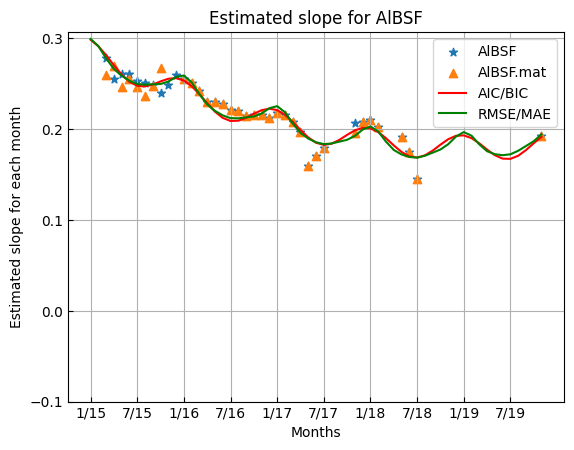

In [25]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], b_aic_al, label="AIC/BIC", color='red')
plt.plot(df["Y/m"], b_rmse_al, label="RMSE/MAE", color='green')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()


In [26]:
# HJT
b_aic_hjt = slope_best_model(hjt_aic, y4, Y4a)
b_bic_hjt = slope_best_model(hjt_bic, y4, Y4a)
b_rmse_hjt = slope_best_model(hjt_rmse, y4, Y4a)

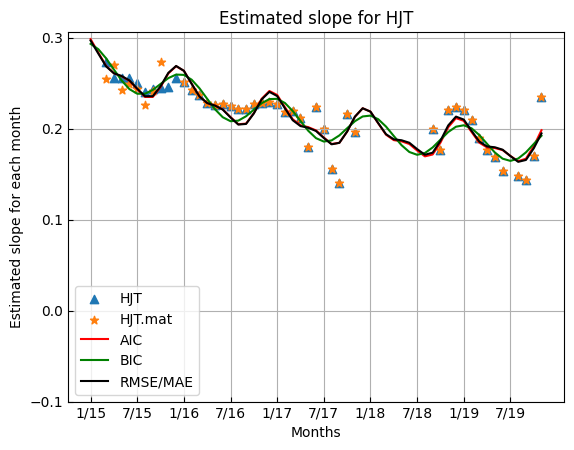

In [27]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], b_aic_hjt, label="AIC", color='red')
plt.plot(df["Y/m"], b_bic_hjt, label="BIC", color='green')
plt.plot(df["Y/m"], b_rmse_hjt, label="RMSE/MAE", color='black')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

In [28]:
# BC
b_aic_bc = slope_best_model(bc_aic, y7, Y7a)
b_rmse_bc = slope_best_model(bc_rmse, y7, Y7a)
b_m = slope_best_model('K_2_L_1', y7, Y7a)

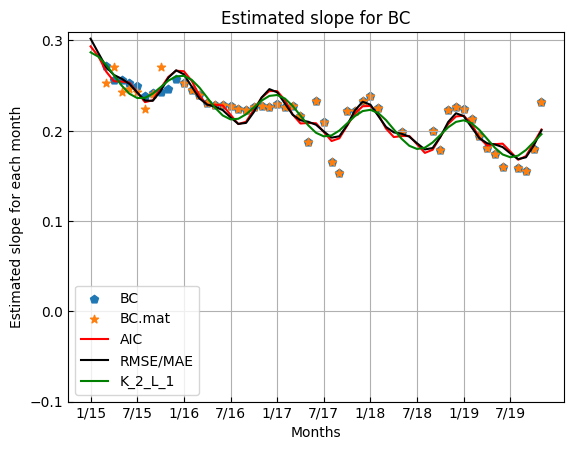

In [29]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], b_aic_bc, label="AIC", color='red')
plt.plot(df["Y/m"], b_rmse_bc, label="RMSE/MAE", color='black')
plt.plot(df["Y/m"], b_m, label="K_2_L_1", color='green')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

# Extrapolation

In [30]:
dates = ["12/19", "12/23"]
start, end = [datetime.strptime(_, "%m/%y") for _ in dates]
m_y = OrderedDict(((start + timedelta(_)).strftime(r"%m/%y"), None) for _ in range((end - start).days)).keys()
m_y = list(m_y)
ym_new = pd.DataFrame(m_y, columns=["Y/m"])


In [31]:
ym_pre = pd.concat([ym, ym_new], axis= 0)
ym_pre

Y/m
0   01/15
1   02/15
2   03/15
3   04/15
4   05/15
..    ...
43  07/23
44  08/23
45  09/23
46  10/23
47  11/23

[107 rows x 1 columns]

In [32]:
df_pre = df.merge(ym_pre, on="Y/m", how='right')
df_pre

Y/m  AlBSF slope  HJT slope  BC slope
0    01/15          NaN        NaN       NaN
1    02/15          NaN        NaN       NaN
2    03/15     0.278236   0.272588  0.271216
3    04/15     0.255023   0.255686  0.255665
4    05/15     0.259999   0.255686  0.256048
..     ...          ...        ...       ...
102  07/23          NaN        NaN       NaN
103  08/23          NaN        NaN       NaN
104  09/23          NaN        NaN       NaN
105  10/23          NaN        NaN       NaN
106  11/23          NaN        NaN       NaN

[107 rows x 4 columns]

In [33]:
d_3a_pre = d_3a.merge(ym_pre, on="Y/m", how='right')
d_4a_pre = d_4a.merge(ym_pre, on="Y/m", how='right')
d_7a_pre = d_7a.merge(ym_pre, on="Y/m", how='right')

In [34]:
# Generate labels up to '7/22'
labels = [f'1/{year:02}' for year in range(15, 24)] + [f'7/{year:02}' for year in range(15, 24)]
labels.sort(key=lambda x: (int(x.split('/')[1]), int(x.split('/')[0])))
# labels.append('12/22')
print(labels)


['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19', '1/20', '7/20', '1/21', '7/21', '1/22', '7/22', '1/23', '7/23']


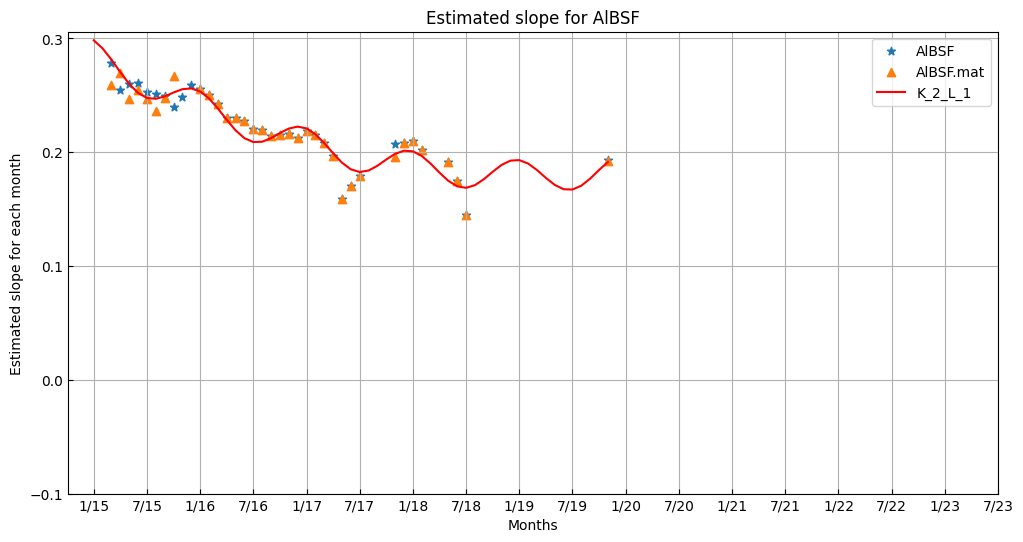

In [35]:
fig1, ax = plt.subplots(figsize=(12, 6))
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a_pre["Y/m"], y=d_3a_pre["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], b_aic_al, label="K_2_L_1", color='red')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

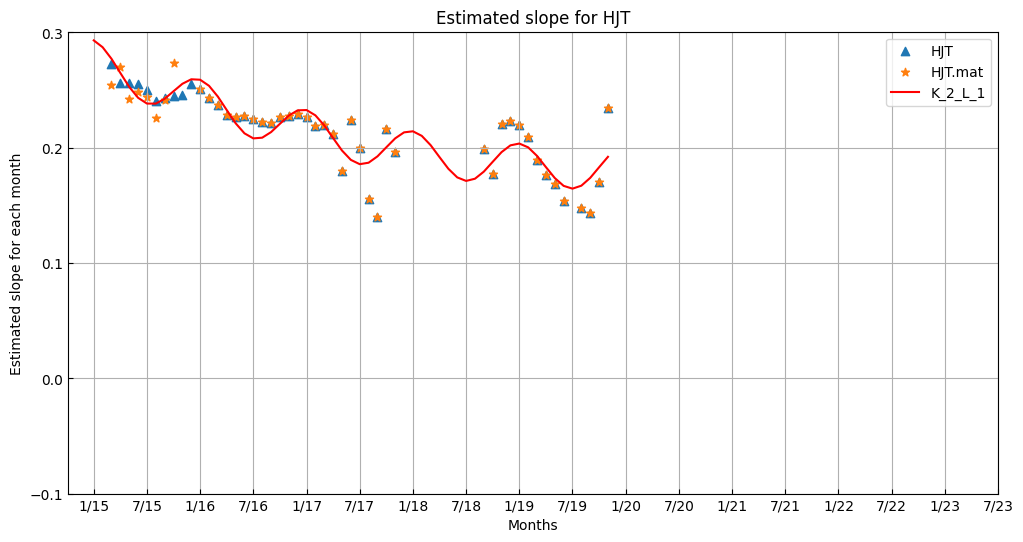

In [36]:
fig2, ax1 = plt.subplots(figsize=(12, 6))
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a_pre["Y/m"], y=d_4a_pre["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], b_bic_hjt, label="K_2_L_1", color='red')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

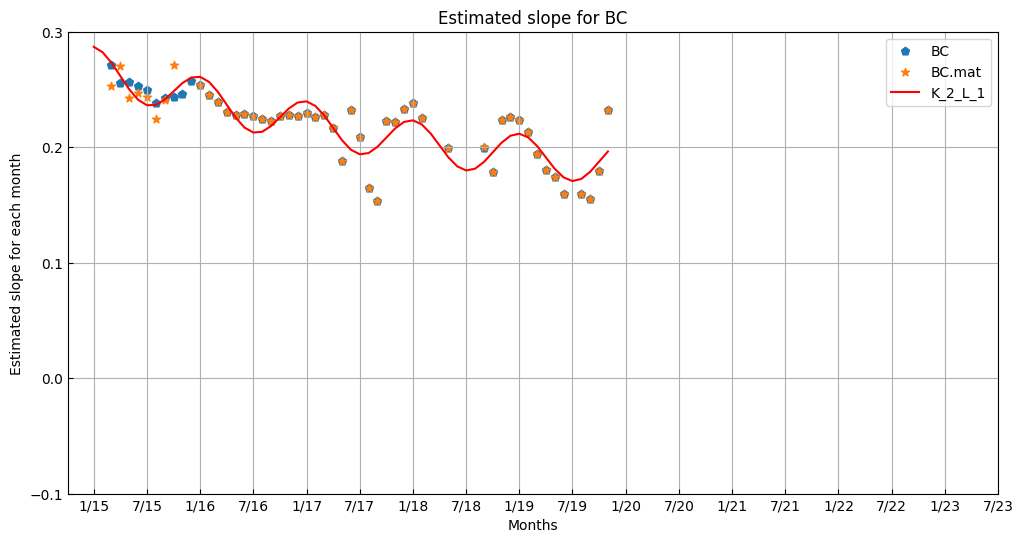

In [37]:
fig3, ax2 = plt.subplots(figsize=(12, 6))
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a_pre["Y/m"], y=d_7a_pre["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], b_m, label="K_2_L_1", color='red')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

In [38]:
t1 = np.arange(60., 108.) #98
X_pre = pd.DataFrame({})
m = 0 ; k = 0
L = 4 ; K = 4

# Polynomial Trend
for j in range(0, K):
  # print(j)
  X_pre[f't{j}'] = t1**j
  k += 1

for i in range(1, L+1):
  X_pre[f's{m}'] = np.cos((2* i* np.pi * X_pre['t1']) / 12)
  X_pre[f's{m+1}'] = np.sin((2* i * np.pi * X_pre['t1']) / 12)
  m += 2


In [39]:
X_m = pd.concat([X, X_pre], axis=0).reset_index(drop=True)
X_m

t0     t1       t2         t3     t4            s0        s1   s2  \
0    1.0    1.0      1.0        1.0    1.0  8.660254e-01  0.500000  0.5   
1    1.0    2.0      4.0        8.0   16.0  5.000000e-01  0.866025 -0.5   
2    1.0    3.0      9.0       27.0   81.0  6.123234e-17  1.000000 -1.0   
3    1.0    4.0     16.0       64.0  256.0 -5.000000e-01  0.866025 -0.5   
4    1.0    5.0     25.0      125.0  625.0 -8.660254e-01  0.500000  0.5   
..   ...    ...      ...        ...    ...           ...       ...  ...   
102  1.0  103.0  10609.0  1092727.0    NaN -8.660254e-01 -0.500000  0.5   
103  1.0  104.0  10816.0  1124864.0    NaN -5.000000e-01 -0.866025 -0.5   
104  1.0  105.0  11025.0  1157625.0    NaN  3.185939e-15 -1.000000 -1.0   
105  1.0  106.0  11236.0  1191016.0    NaN  5.000000e-01 -0.866025 -0.5   
106  1.0  107.0  11449.0  1225043.0    NaN  8.660254e-01 -0.500000  0.5   

               s3            s4            s5   s6            s7  
0    8.660254e-01  6.123234e-17  1.000000e+00 -0.5  8.660254e-01  
1    8.660254e-01 -1.000000e+00  1.224647e-16 -0.5 -8.660254e-01  
2    1.224647e-16 -1.836970e-16 -1.000000e+00  1.0 -2.449294e-16  
3   -8.660254e-01  1.000000e+00 -2.449294e-16 -0.5  8.660254e-01  
4   -8.660254e-01  1.194340e-15  1.000000e+00 -0.5 -8.660254e-01  
..            ...           ...           ...  ...           ...  
102  8.660254e-01 -1.518872e-14 -1.000000e+00 -0.5  8.660254e-01  
103  8.660254e-01  1.000000e+00 -2.057902e-14 -0.5 -8.660254e-01  
104 -6.371877e-15 -2.452389e-15  1.000000e+00  1.0  1.274375e-14  
105 -8.660254e-01 -1.000000e+00  2.937914e-15 -0.5  8.660254e-01  
106 -8.660254e-01 -8.328217e-15 -1.000000e+00 -0.5 -8.660254e-01  

[107 rows x 13 columns]

In [40]:
X_pred = X_m.iloc[58:, :].reset_index(drop=True)

In [41]:
c_b_al, l3, up3 = slope_best_model(al_aic, y, Y3a, Xnew=X_m.iloc[58:, :].reset_index(drop=True))
c_b_hjt, l4, up4  = slope_best_model(hjt_bic, y4, Y4a, Xnew=X_m.iloc[58:, :].reset_index(drop=True))
c_b_bc, l7, up7  = slope_best_model('K_2_L_1', y7, Y7a, Xnew=X_m.iloc[58:, :].reset_index(drop=True))

In [42]:
tr_al = slope_best_model('K_1_L_1', y, Y3a)
tr_hjt = slope_best_model('K_1_L_1', y4, Y4a)
tr_bc = slope_best_model('K_1_L_1', y7, Y7a)

In [43]:
c_al, l3_1, up3_1 = slope_best_model('K_1_L_1', y, Y3a, Xnew=X_m.iloc[58:, :].reset_index(drop=True))
c_hjt,  l4_1, up4_1  = slope_best_model('K_1_L_1', y4, Y4a, Xnew=X_m.iloc[58:, :].reset_index(drop=True))
c_bc, l7_1, up7_1  = slope_best_model('K_1_L_1', y7, Y7a, Xnew=X_m.iloc[58:, :].reset_index(drop=True))

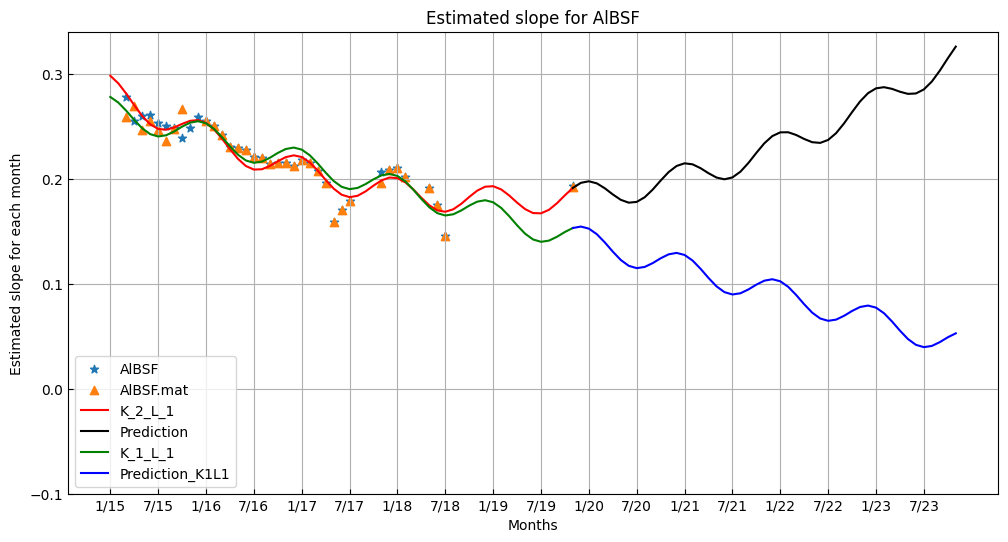

In [44]:
fig1, ax = plt.subplots(figsize=(12, 6))
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a_pre["Y/m"], y=d_3a_pre["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], b_aic_al, label="K_2_L_1", color='red')
plt.plot(df_pre.loc[58:, "Y/m"], c_b_al, label="Prediction", color='black')
plt.plot(df["Y/m"], tr_al, label="K_1_L_1", color='green')
plt.plot(df_pre.loc[58:, "Y/m"], c_al, label="Prediction_K1L1", color='blue')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

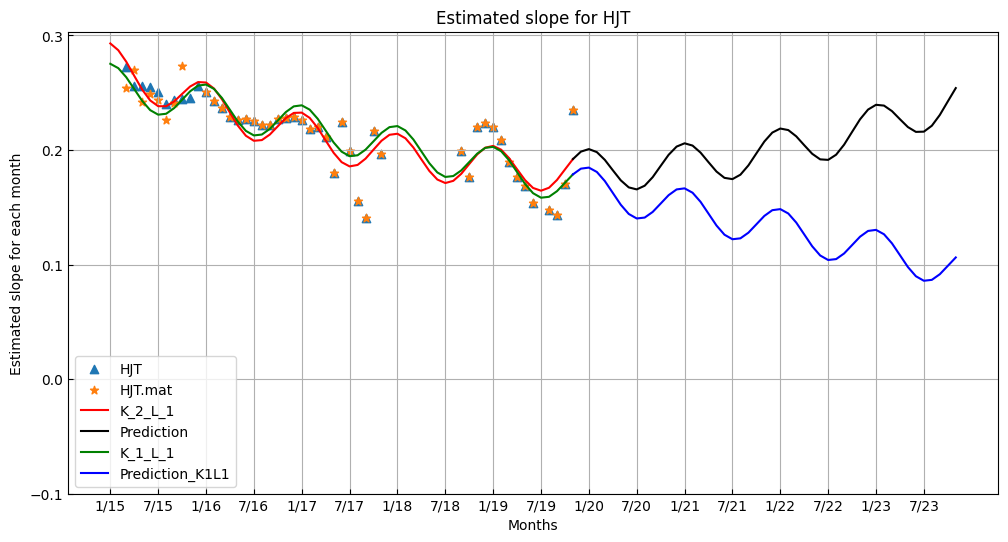

In [45]:
fig2, ax1 = plt.subplots(figsize=(12, 6))
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a_pre["Y/m"], y=d_4a_pre["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], b_bic_hjt, label="K_2_L_1", color='red')
plt.plot(df_pre.loc[58:, "Y/m"], c_b_hjt, label="Prediction", color='black')
plt.plot(df["Y/m"], tr_hjt, label="K_1_L_1", color='green')
plt.plot(df_pre.loc[58:, "Y/m"], c_hjt, label="Prediction_K1L1", color='blue')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

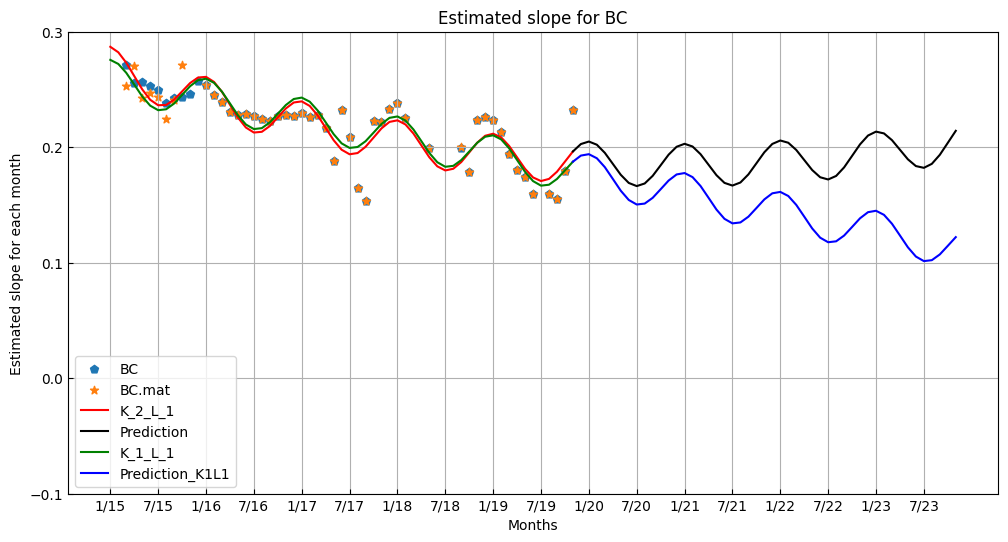

In [46]:
fig3, ax2 = plt.subplots(figsize=(12, 6))
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a_pre["Y/m"], y=d_7a_pre["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], b_m, label="K_2_L_1", color='red')
plt.plot(df_pre.loc[58:, "Y/m"], c_b_bc, label="Prediction", color='black')
plt.plot(df["Y/m"], tr_bc, label="K_1_L_1", color='green')
plt.plot(df_pre.loc[58:, "Y/m"], c_bc, label="Prediction_K1L1", color='blue')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

# Prediction Intervals

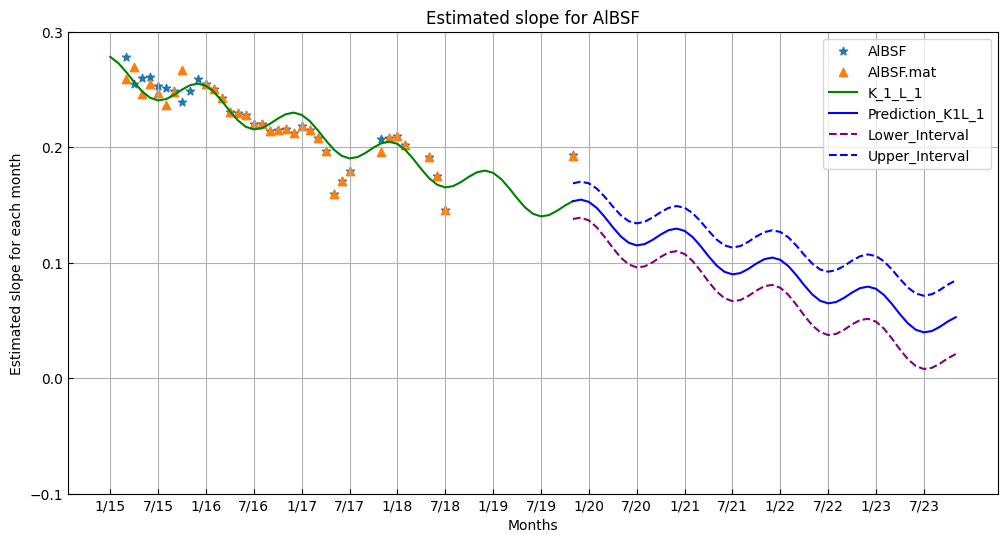

In [47]:
# Prediction Intervals
fig1, ax = plt.subplots(figsize=(12, 6))
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a_pre["Y/m"], y=d_3a_pre["Slope"], marker="^", label="AlBSF.mat")
"""plt.plot(df["Y/m"], b_aic_al, label="K_2_L_1", color='red')
plt.plot(df_pre.loc[58:, "Y/m"], c_b_al, label="Prediction", color='black')
plt.plot(df_pre.loc[58:, "Y/m"], l3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df_pre.loc[58:, "Y/m"], up3, label="Upper_Interval", color='blue', linestyle='--')"""
plt.plot(df["Y/m"], tr_al, label="K_1_L_1", color='green')
plt.plot(df_pre.loc[58:, "Y/m"], c_al, label="Prediction_K1L_1", color='blue')
plt.plot(df_pre.loc[58:, "Y/m"], l3_1, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df_pre.loc[58:, "Y/m"], up3_1, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

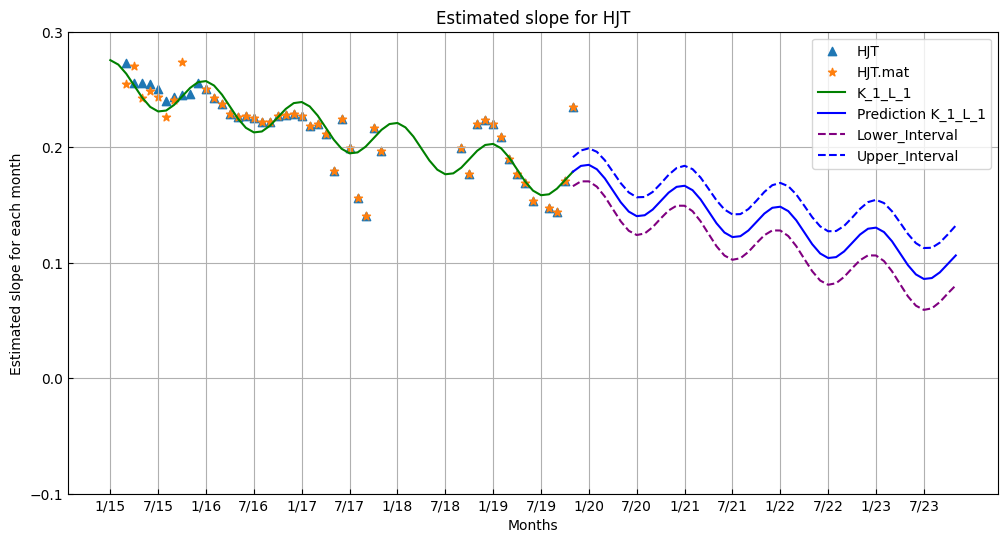

In [48]:
fig2, ax1 = plt.subplots(figsize=(12, 6))
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a_pre["Y/m"], y=d_4a_pre["Slope"], marker="*", label="HJT.mat")
"""plt.plot(df["Y/m"], b_bic_hjt, label="K_2_L_1", color='red')
plt.plot(df_pre.loc[58:, "Y/m"], c_b_hjt, label="Prediction", color='black')
plt.plot(df_pre.loc[58:, "Y/m"], l4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df_pre.loc[58:, "Y/m"], up4, label="Upper_Interval", color='blue', linestyle='--')"""
plt.plot(df["Y/m"], tr_hjt, label="K_1_L_1", color='green')
plt.plot(df_pre.loc[58:, "Y/m"], c_hjt, label="Prediction K_1_L_1", color='blue')
plt.plot(df_pre.loc[58:, "Y/m"], l4_1, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df_pre.loc[58:, "Y/m"], up4_1, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

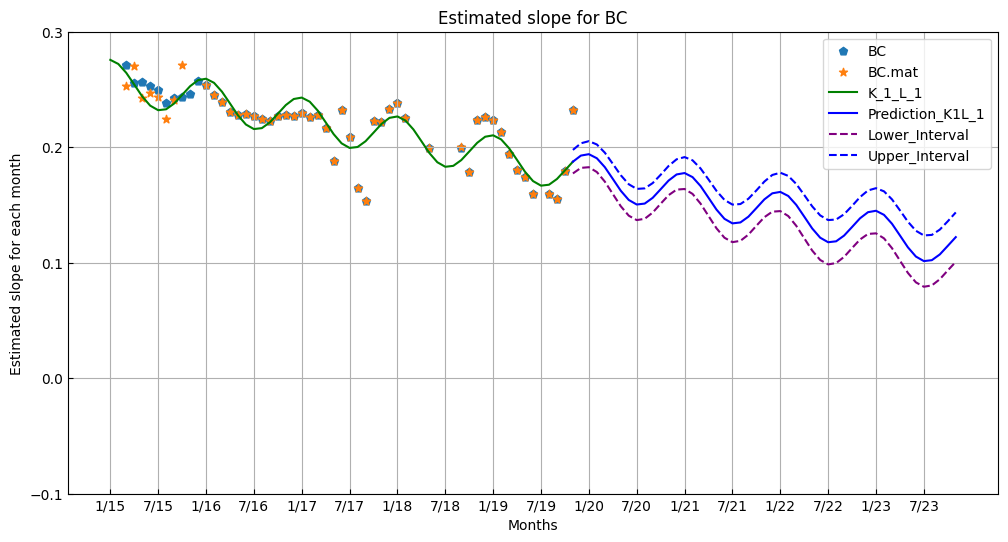

In [49]:
fig3, ax2 = plt.subplots(figsize=(12, 6))
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df_pre["Y/m"], y=df_pre["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a_pre["Y/m"], y=d_7a_pre["Slope"], marker="*", label="BC.mat")
"""plt.plot(df["Y/m"], b_m, label="K_2_L_1", color='red')
plt.plot(df_pre.loc[58:, "Y/m"], c_b_bc, label="Prediction", color='black')
plt.plot(df_pre.loc[58:, "Y/m"], l7, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df_pre.loc[58:, "Y/m"], up7, label="Upper_Interval", color='blue', linestyle='--')"""
plt.plot(df["Y/m"], tr_bc, label="K_1_L_1", color='green')
plt.plot(df_pre.loc[58:, "Y/m"], c_bc, label="Prediction_K1L_1", color='blue')
plt.plot(df_pre.loc[58:, "Y/m"], l7_1, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df_pre.loc[58:, "Y/m"], up7_1, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 108, 6)], labels=labels)
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

In [50]:
data = pd.concat([df, X], axis=1)

## First Case

In [51]:
# First Case: Training Period 1/15 - 12/16
# Testing Period 1/17 - 12/19
idx = data.index[df['Y/m'] == '12/16'].to_list()[0]
case1 = data.iloc[:idx+1, :]
test1 = data.iloc[idx+1: , :]

In [52]:
y_al = case1["AlBSF slope"].dropna().reset_index(drop=True)

In [53]:
# Predictions
p_c_1, c1_l, c1_up = slope_best_model('K_1_L_1', case1["AlBSF slope"].dropna(), case1.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx+1:, :])
p_c_hjt,  c4_l, c4_up  = slope_best_model('K_1_L_1', case1["HJT slope"].dropna(), case1.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx+1:, :])
p_c_bc, c7_l, c7_up  = slope_best_model('K_1_L_1', case1["BC slope"].dropna(), case1.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx+1:, :])

In [54]:
# Albsf
tr_c_1, c1_l_21, c1_up_21 = slope_best_model('K_2_L_1', case1["AlBSF slope"].dropna(), case1.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx+1:, :])
tr_c_hjt,  c4_l_21, c4_up_21  = slope_best_model('K_2_L_1', case1["HJT slope"].dropna(), case1.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx+1:, :])
tr_c_bc, c7_l_21, c7_up_21  = slope_best_model('K_2_L_1', case1["BC slope"].dropna(), case1.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx+1:, :])

In [55]:
# Training
tr_al_c1 = slope_best_model('K_1_L_1',case1["AlBSF slope"].dropna(), case1.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c1 = slope_best_model('K_1_L_1', case1["HJT slope"].dropna(), case1.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c1 = slope_best_model('K_1_L_1', case1["BC slope"].dropna(), case1.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [56]:
tr_al_c2 = slope_best_model('K_2_L_1',case1["AlBSF slope"].dropna(), case1.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c2 = slope_best_model('K_2_L_1', case1["HJT slope"].dropna(), case1.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c2 = slope_best_model('K_2_L_1', case1["BC slope"].dropna(), case1.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

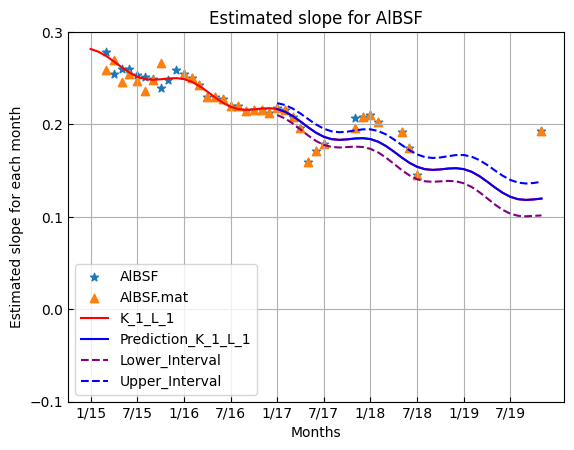

In [57]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c1, label="K_1_L_1", color='red')
plt.plot(df.loc[idx+1:, "Y/m"], p_c_1, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], c1_l, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], c1_up, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()


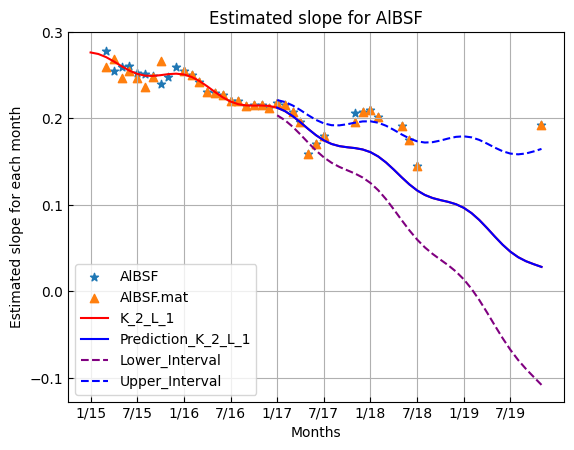

In [58]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c2, label="K_2_L_1", color='red')
plt.plot(df.loc[idx+1:, "Y/m"], tr_c_1, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], c1_l_21, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], c1_up_21, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

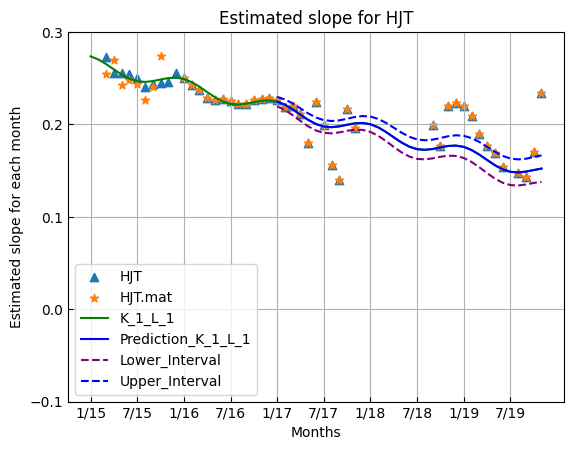

In [59]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c1, label="K_1_L_1", color='green')
plt.plot(df.loc[idx+1:, "Y/m"], p_c_hjt, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], c4_l, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], c4_up, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

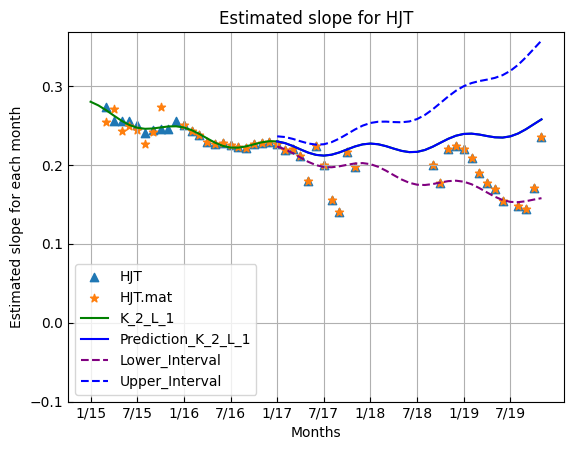

In [60]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c2, label="K_2_L_1", color='green')
plt.plot(df.loc[idx+1:, "Y/m"], tr_c_hjt, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], c4_l_21, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], c4_up_21, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

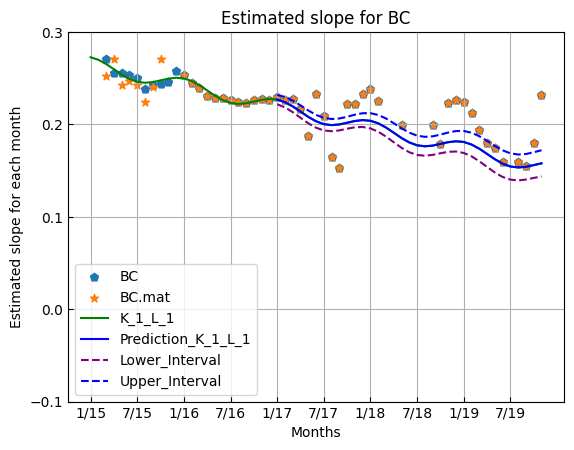

In [61]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c1, label="K_1_L_1", color='green')
plt.plot(df.loc[idx+1:, "Y/m"], p_c_bc, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], c7_l, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], c7_up, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

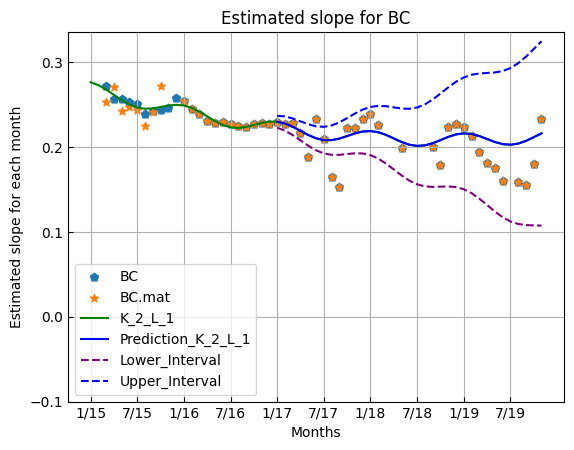

In [62]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c2, label="K_2_L_1", color='green')
plt.plot(df.loc[idx+1:, "Y/m"], tr_c_bc, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], c7_l_21, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], c7_up_21, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

## Mapie Regressor

In [63]:
import warnings
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from mapie.regression import MapieRegressor
from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)


warnings.simplefilter("ignore")

In [64]:
mp_al_tr_1 = case1[["Y/m","AlBSF slope", "t0", "t1", "s0", "s1"]].dropna().reset_index(drop=True)
mp_al_ts_1 = test1[["Y/m","AlBSF slope", "t0", "t1", "s0", "s1"]].dropna().reset_index(drop=True)

In [65]:
sum(test1["AlBSF slope"].isna())

20

In [66]:
mp_x = mp_al_tr_1[["t0", "t1", "s0", "s1"]]
mp_y = mp_al_tr_1[["AlBSF slope"]]
mp_ts_x = mp_al_ts_1[["t0", "t1", "s0", "s1"]]
mp_ts_y = mp_al_ts_1[["AlBSF slope"]]

In [188]:
# Fit the OLS model
mp_model = LinearRegression()
mp_model.fit(mp_x, mp_y)

LinearRegression()

In [189]:
mapie = MapieRegressor(mp_model,method="plus")
mapie.fit(mp_x, mp_y)
y_pred, y_pis = mapie.predict(test1[[ "t0", "t1", "s0", "s1"]].reset_index(drop=True), alpha=0.05)

In [190]:
pr = pd.DataFrame(y_pred, columns=["preds"])
l = pd.DataFrame(y_pis[:, 0], columns=["L"])
u = pd.DataFrame(y_pis[:, 1], columns=["U"])
b_mp = [pr, l, u]
mp = pd.concat(b_mp, axis=1)
# mp

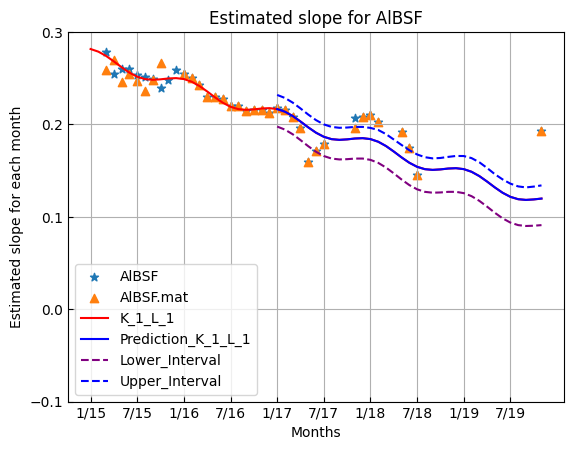

In [191]:
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c1, label="K_1_L_1", color='red')
plt.plot(df.loc[idx+1:, "Y/m"], mp["preds"], label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx+1:, "Y/m"], mp["L"], label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx+1:, "Y/m"], mp["U"], label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

# Second Case 

In [73]:
# Second Case: Training Period 1/15 - 6/17
# Testing Period 7/17 - 12/19
idx2 = data.index[df['Y/m'] == '06/17'].to_list()[0]
case2 = data.iloc[:idx2+1, :]
test2 = data.iloc[idx2+1: , :]

In [74]:
# Training
tr_al_c1_2 = slope_best_model('K_1_L_1',case2["AlBSF slope"].dropna(), case2.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c1_2 = slope_best_model('K_1_L_1', case2["HJT slope"].dropna(), case2.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c1_2 = slope_best_model('K_1_L_1', case2["BC slope"].dropna(), case2.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [75]:
tr_al_c2_2 = slope_best_model('K_2_L_1',case2["AlBSF slope"].dropna(), case2.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c2_2 = slope_best_model('K_2_L_1', case2["HJT slope"].dropna(), case2.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c2_2 = slope_best_model('K_2_L_1', case2["BC slope"].dropna(), case2.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [76]:
# Predictions
p_c_2, c1_l2, c1_up2 = slope_best_model('K_1_L_1', case2["AlBSF slope"].dropna(), case2.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx2+1:, :])
p_c_hjt2,  c4_l2, c4_up2  = slope_best_model('K_1_L_1', case2["HJT slope"].dropna(), case2.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx2+1:, :])
p_c_bc2, c7_l2, c7_up2  = slope_best_model('K_1_L_1', case2["BC slope"].dropna(), case2.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx2+1:, :])

In [77]:
# Predictions
p_c_2_2, c1_l2_2, c1_up2_2 = slope_best_model('K_2_L_1', case2["AlBSF slope"].dropna(), case2.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx2+1:, :])
p_c_hjt2_2,  c4_l2_2, c4_up2_2  = slope_best_model('K_2_L_1', case2["HJT slope"].dropna(), case2.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx2+1:, :])
p_c_bc2_2, c7_l2_2, c7_up2_2  = slope_best_model('K_2_L_1', case2["BC slope"].dropna(), case2.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx2+1:, :])

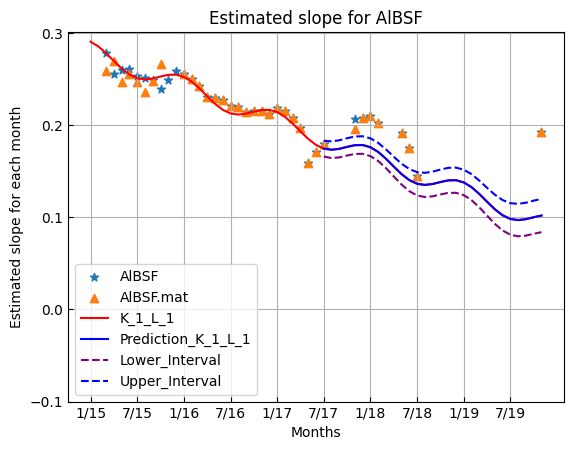

In [78]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c1_2, label="K_1_L_1", color='red')
plt.plot(df.loc[idx2+1:, "Y/m"], p_c_2, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], c1_l2, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], c1_up2, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

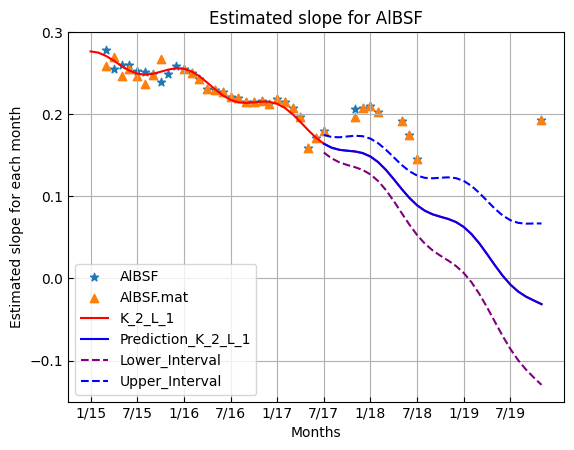

In [79]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c2_2, label="K_2_L_1", color='red')
plt.plot(df.loc[idx2+1:, "Y/m"], p_c_2_2, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], c1_l2_2, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], c1_up2_2, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()


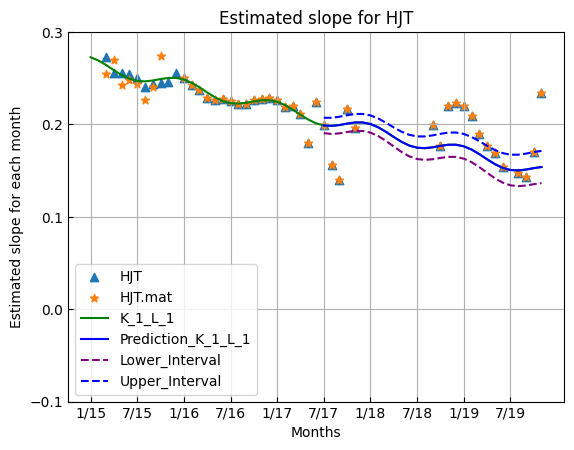

In [80]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c1_2, label="K_1_L_1", color='green')
plt.plot(df.loc[idx2+1:, "Y/m"], p_c_hjt2, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], c4_l2, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], c4_up2, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

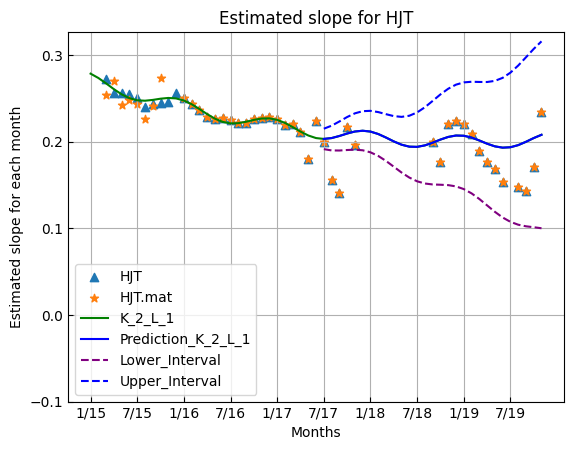

In [81]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c2_2, label="K_2_L_1", color='green')
plt.plot(df.loc[idx2+1:, "Y/m"], p_c_hjt2_2, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], c4_l2_2, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], c4_up2_2, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

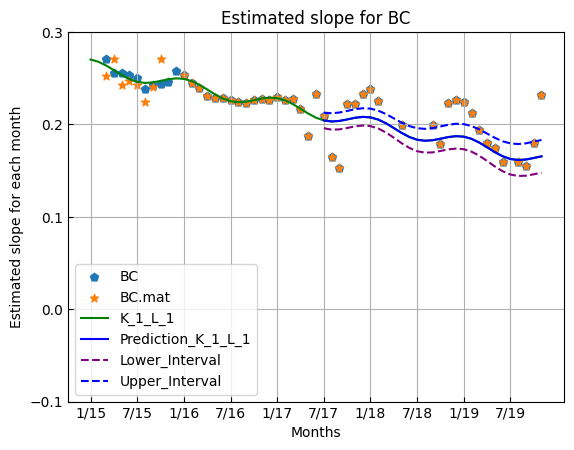

In [82]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c1_2, label="K_1_L_1", color='green')
plt.plot(df.loc[idx2+1:, "Y/m"], p_c_bc2, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], c7_l2, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], c7_up2, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

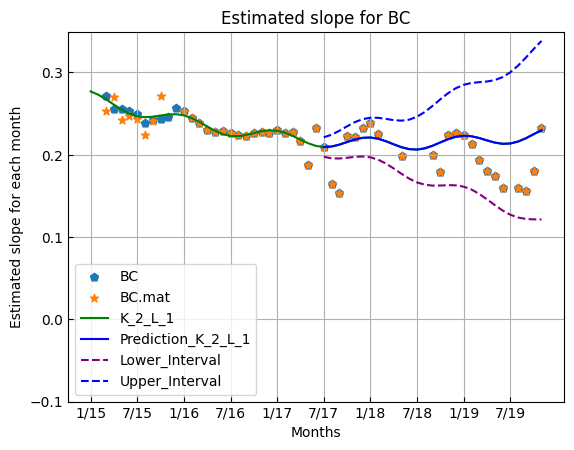

In [83]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c2_2, label="K_2_L_1", color='green')
plt.plot(df.loc[idx2+1:, "Y/m"], p_c_bc2_2, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], c7_l2_2, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], c7_up2_2, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

### Mapie Regressor

In [115]:
mp_al_tr_2 = case2[["Y/m","AlBSF slope", "t0", "t1", "s0", "s1"]].dropna().reset_index(drop=True)
mp_al_ts_2 = test2[["Y/m","AlBSF slope", "t0", "t1", "s0", "s1"]].dropna().reset_index(drop=True)

In [192]:
mp_x_2 = mp_al_tr_2[["t0", "t1", "s0", "s1"]]
mp_y_2 = mp_al_tr_2[["AlBSF slope"]]
mp_ts_x_2 = mp_al_ts_2[["t0", "t1", "s0", "s1"]]
mp_ts_y_2 = mp_al_ts_2[["AlBSF slope"]]

In [205]:
# Fit the OLS model
mp_model2 = LinearRegression()
mp_model2.fit(mp_x_2, mp_y_2)

LinearRegression()

In [206]:
mapie2 = MapieRegressor(mp_model2,method="minmax", cv=-1)
mapie2.fit(mp_x_2, mp_y_2)
y_pred_2, y_pis_2 = mapie2.predict(test2[[ "t0", "t1", "s0", "s1"]].reset_index(drop=True), alpha=0.05)

In [207]:
pr2 = pd.DataFrame(y_pred_2, columns=["preds"])
l2 = pd.DataFrame(y_pis_2[:, 0], columns=["L"])
u2 = pd.DataFrame(y_pis_2[:, 1], columns=["U"])
b_mp2 = [pr2, l2, u2]
mp2 = pd.concat(b_mp2, axis=1)

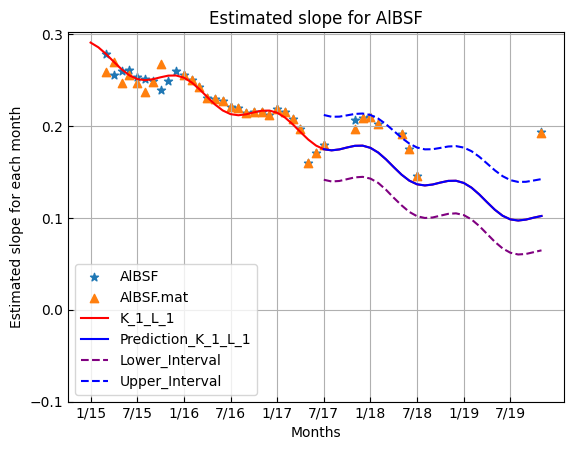

In [208]:
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c1_2, label="K_1_L_1", color='red')
plt.plot(df.loc[idx2+1:, "Y/m"], mp2["preds"], label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx2+1:, "Y/m"], mp2["L"], label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx2+1:, "Y/m"], mp2["U"], label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

## Third Case

In [84]:
# Third Case: Training Period 1/15 - 12/17
# Testing Period 1/18 - 12/19
idx3 = data.index[df['Y/m'] == '12/17'].to_list()[0]
case3 = data.iloc[:idx3+1, :]
test3 = data.iloc[idx3+1: , :]

In [85]:
# Training
tr_al_c1_3 = slope_best_model('K_1_L_1',case3["AlBSF slope"].dropna(), case3.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c1_3 = slope_best_model('K_1_L_1', case3["HJT slope"].dropna(), case3.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c1_3 = slope_best_model('K_1_L_1', case3["BC slope"].dropna(), case3.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [86]:
tr_al_c2_3 = slope_best_model('K_2_L_1',case3["AlBSF slope"].dropna(), case3.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c2_3 = slope_best_model('K_2_L_1', case3["HJT slope"].dropna(), case3.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c2_3 = slope_best_model('K_2_L_1', case3["BC slope"].dropna(), case3.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [87]:
# Predictions
p_c_3, c1_l3, c1_up3 = slope_best_model('K_1_L_1', case3["AlBSF slope"].dropna(), case3.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx3+1:, :])
p_c_hjt3,  c4_l3, c4_up3  = slope_best_model('K_1_L_1', case3["HJT slope"].dropna(), case3.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx3+1:, :])
p_c_bc3, c7_l3, c7_up3  = slope_best_model('K_1_L_1', case3["BC slope"].dropna(), case3.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx3+1:, :])

In [88]:
# Predictions
p_c_2_3, c1_l2_3, c1_up2_3 = slope_best_model('K_2_L_1', case3["AlBSF slope"].dropna(), case3.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx3+1:, :])
p_c_hjt2_3,  c4_l2_3, c4_up2_3  = slope_best_model('K_2_L_1', case3["HJT slope"].dropna(), case3.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx3+1:, :])
p_c_bc2_3, c7_l2_3, c7_up2_3  = slope_best_model('K_2_L_1', case3["BC slope"].dropna(), case3.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx3+1:, :])

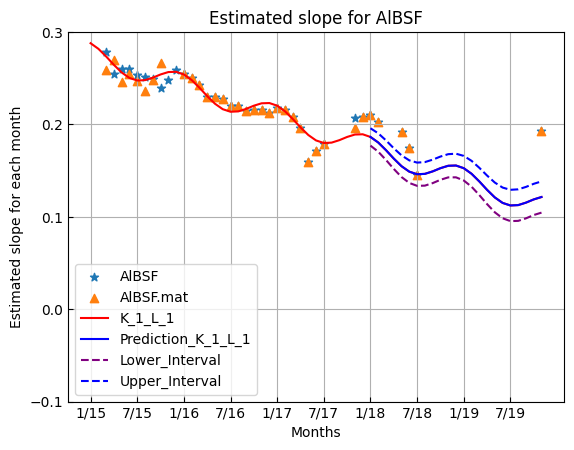

In [89]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c1_3, label="K_1_L_1", color='red')
plt.plot(df.loc[idx3+1:, "Y/m"], p_c_3, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx3+1:, "Y/m"], c1_l3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx3+1:, "Y/m"], c1_up3, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

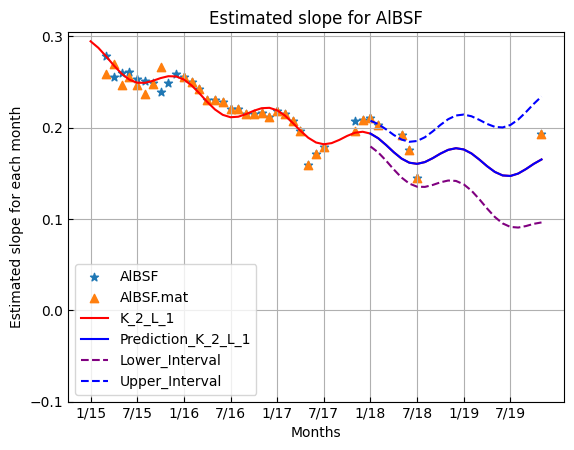

In [90]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c2_3, label="K_2_L_1", color='red')
plt.plot(df.loc[idx3+1:, "Y/m"], p_c_2_3, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx3+1:, "Y/m"], c1_l2_3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx3+1:, "Y/m"], c1_up2_3, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()


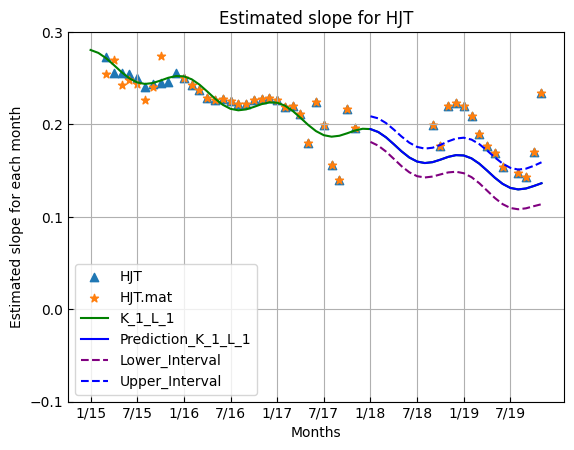

In [91]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c1_3, label="K_1_L_1", color='green')
plt.plot(df.loc[idx3+1:, "Y/m"], p_c_hjt3, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx3+1:, "Y/m"], c4_l3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx3+1:, "Y/m"], c4_up3, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

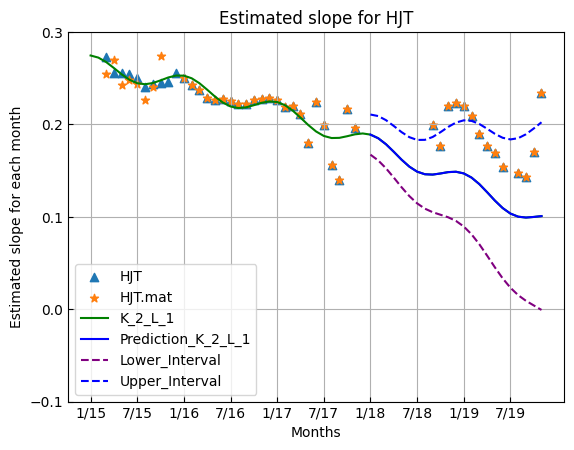

In [92]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c2_3, label="K_2_L_1", color='green')
plt.plot(df.loc[idx3+1:, "Y/m"], p_c_hjt2_3, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx3+1:, "Y/m"], c4_l2_3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx3+1:, "Y/m"], c4_up2_3, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

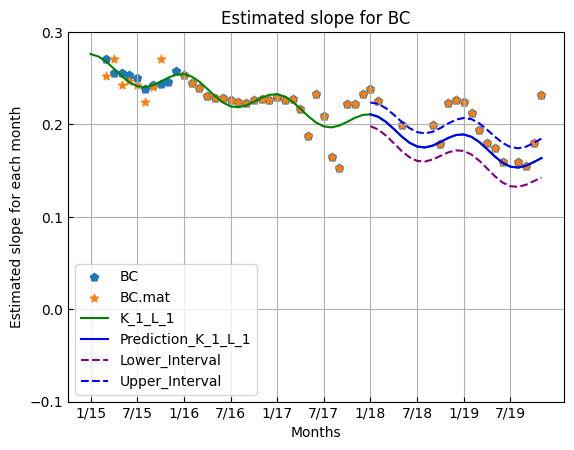

In [93]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c1_3, label="K_1_L_1", color='green')
plt.plot(df.loc[idx3+1:, "Y/m"], p_c_bc3, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx3+1:, "Y/m"], c7_l3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx3+1:, "Y/m"], c7_up3, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

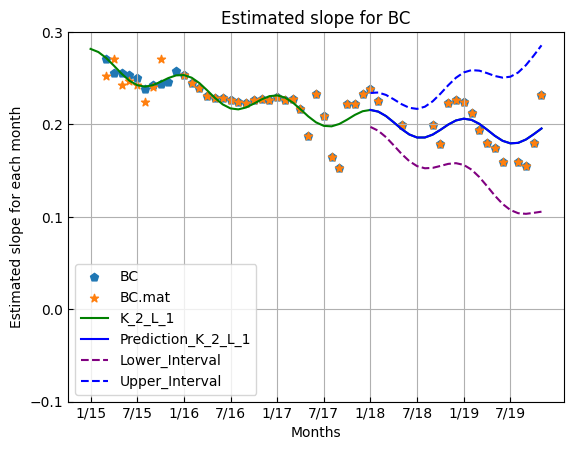

In [94]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c2_3, label="K_2_L_1", color='green')
plt.plot(df.loc[idx3+1:, "Y/m"], p_c_bc2_3, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx3+1:, "Y/m"], c7_l2_3, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx3+1:, "Y/m"], c7_up2_3, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

In [95]:
# Forth Case: Training Period 1/15 - 6/18
# Testing Period 7/18 - 12/19
idx4 = data.index[df['Y/m'] == '06/18'].to_list()[0]
case4 = data.iloc[:idx4+1, :]
test4 = data.iloc[idx4+1: , :]

In [96]:
# Training
tr_al_c1_4 = slope_best_model('K_1_L_1',case4["AlBSF slope"].dropna(), case4.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c1_4 = slope_best_model('K_1_L_1', case4["HJT slope"].dropna(), case4.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c1_4 = slope_best_model('K_1_L_1', case4["BC slope"].dropna(), case4.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [97]:
tr_al_c2_4 = slope_best_model('K_2_L_1',case4["AlBSF slope"].dropna(), case4.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna())
tr_hjt_c2_4 = slope_best_model('K_2_L_1', case4["HJT slope"].dropna(), case4.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna())
tr_bc_c2_4 = slope_best_model('K_2_L_1', case4["BC slope"].dropna(), case4.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna())

In [98]:
# Predictions
p_c_4, c1_l4, c1_up4 = slope_best_model('K_1_L_1', case4["AlBSF slope"].dropna(), case4.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx4+1:, :])
p_c_hjt4,  c4_l4, c4_up4  = slope_best_model('K_1_L_1', case4["HJT slope"].dropna(), case4.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx4+1:, :])
p_c_bc4, c7_l4, c7_up4  = slope_best_model('K_1_L_1', case4["BC slope"].dropna(), case4.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx4+1:, :])

In [99]:
# Predictions
p_c_2_4, c1_l2_4, c1_up2_4 = slope_best_model('K_2_L_1', case4["AlBSF slope"].dropna(), case4.drop(["Y/m","HJT slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx4+1:, :])
p_c_hjt2_4,  c4_l2_4, c4_up2_4  = slope_best_model('K_2_L_1', case4["HJT slope"].dropna(), case4.drop(["Y/m","AlBSF slope", "BC slope"], axis=1).dropna(), Xnew=X.iloc[idx4+1:, :])
p_c_bc2_4, c7_l2_4, c7_up2_4  = slope_best_model('K_2_L_1', case4["BC slope"].dropna(), case4.drop(["Y/m","HJT slope", "AlBSF slope"], axis=1).dropna(), Xnew=X.iloc[idx4+1:, :])

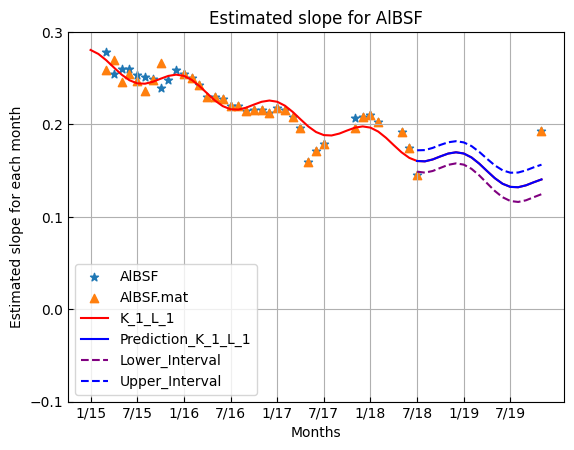

In [100]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c1_4, label="K_1_L_1", color='red')
plt.plot(df.loc[idx4+1:, "Y/m"], p_c_4, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx4+1:, "Y/m"], c1_l4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx4+1:, "Y/m"], c1_up4, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

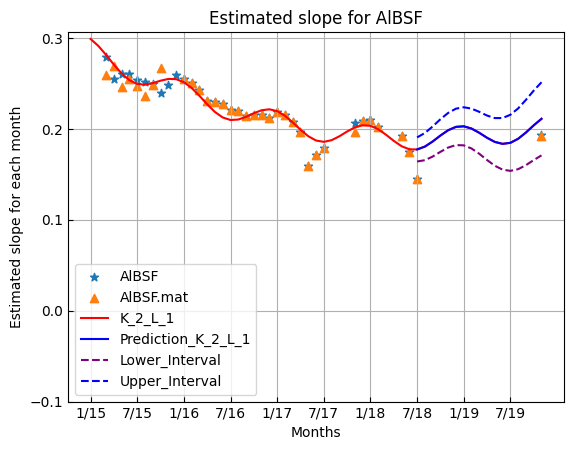

In [101]:
# Best fit with slopes
fig1, ax = plt.subplots()
ax = plt.gca()
plt.title("Estimated slope for AlBSF")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["AlBSF slope"], marker="*", label="AlBSF")
plt.scatter(x=d_3a["Y/m"], y=d_3a["Slope"], marker="^", label="AlBSF.mat")
plt.plot(df["Y/m"], tr_al_c2_4, label="K_2_L_1", color='red')
plt.plot(df.loc[idx4+1:, "Y/m"], p_c_2_4, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx4+1:, "Y/m"], c1_l2_4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx4+1:, "Y/m"], c1_up2_4, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()


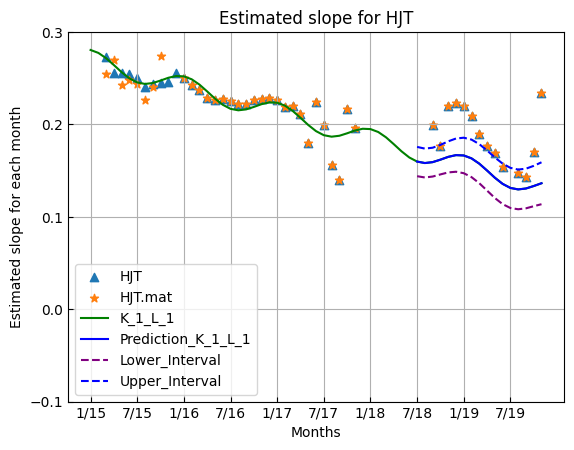

In [102]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c1_4, label="K_1_L_1", color='green')
plt.plot(df.loc[idx4+1:, "Y/m"], p_c_hjt4, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx4+1:, "Y/m"], c4_l4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx4+1:, "Y/m"], c4_up4, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

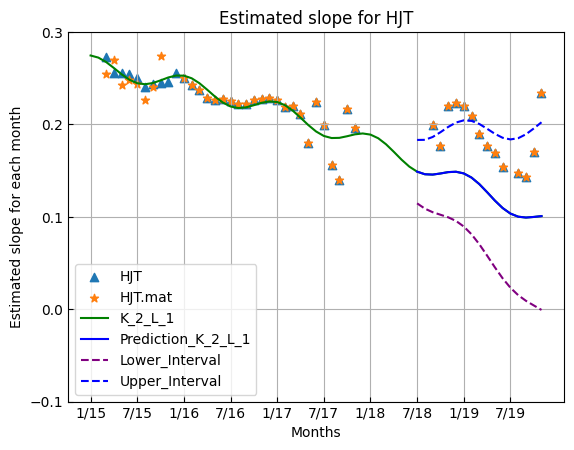

In [103]:
fig2, ax1 = plt.subplots()
ax1 = plt.gca()
plt.title("Estimated slope for HJT")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["HJT slope"], marker="^", label="HJT")
plt.scatter(x=d_4a["Y/m"], y=d_4a["Slope"], marker="*", label="HJT.mat")
plt.plot(df["Y/m"], tr_hjt_c2_4, label="K_2_L_1", color='green')
plt.plot(df.loc[idx4+1:, "Y/m"], p_c_hjt2_4, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx4+1:, "Y/m"], c4_l2_4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx4+1:, "Y/m"], c4_up2_4, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

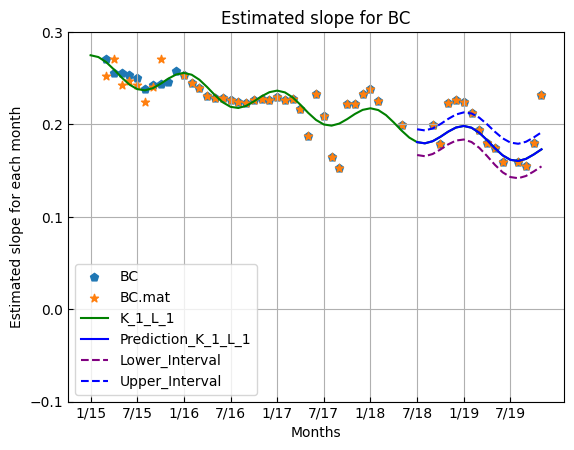

In [104]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c1_4, label="K_1_L_1", color='green')
plt.plot(df.loc[idx4+1:, "Y/m"], p_c_bc4, label="Prediction_K_1_L_1", color='blue')
plt.plot(df.loc[idx4+1:, "Y/m"], c7_l4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx4+1:, "Y/m"], c7_up4, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

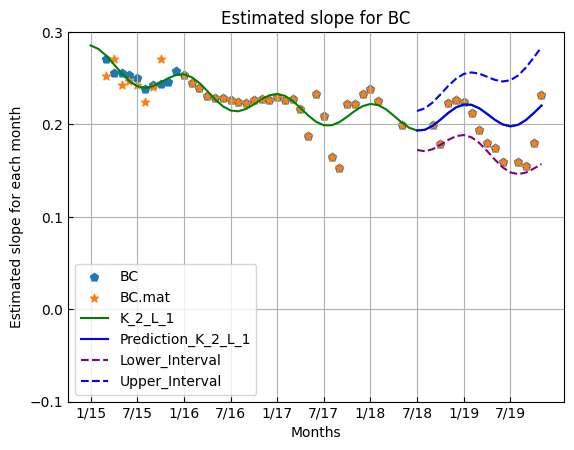

In [105]:
fig3, ax2 = plt.subplots()
ax2 = plt.gca()
plt.title("Estimated slope for BC")
plt.xlabel("Months")
plt.ylabel("Estimated slope for each month")
plt.scatter(x=df["Y/m"], y=df["BC slope"], marker="p", label="BC")
plt.scatter(x=d_7a["Y/m"], y=d_7a["Slope"], marker="*", label="BC.mat")
plt.plot(df["Y/m"], tr_bc_c2_4, label="K_2_L_1", color='green')
plt.plot(df.loc[idx4+1:, "Y/m"], p_c_bc2_4, label="Prediction_K_2_L_1", color='blue')
plt.plot(df.loc[idx4+1:, "Y/m"], c7_l2_4, label="Lower_Interval", color='purple', linestyle='--')
plt.plot(df.loc[idx4+1:, "Y/m"], c7_up2_4, label="Upper_Interval", color='blue', linestyle='--')
plt.legend(loc='best')
plt.grid(True)
plt.yticks([-0.1, 0, 0.1, 0.2, 0.3])
plt.xticks(ticks=[i for i in range(0, 60, 6)], labels=['1/15', '7/15', '1/16', '7/16', '1/17', '7/17', '1/18', '7/18', '1/19', '7/19'])
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')
plt.show()

In [106]:
#################################################################################

In [107]:
for i in range(k):
  print(i)
  # K
  for j in range(K):
    # Albsf
    # i ** 2 + 50
    x3_tr, x3_ts, y3_tr, y3_ts = train_test_split(x_linear[l_col[0:j+1]], y, test_size=0.3, random_state=i * 50)
    m3_l = sm.OLS(y3_tr, x3_tr).fit()
    pred3 = m3_l.predict(x3_ts)
    mse3 = mean_squared_error(y3_ts, pred3)
    mae3 = mean_absolute_error(y3_ts, pred3)
    cv_rmse[f'k_{i}_K_{j}_rmse'] = np.sqrt(mse3)
    cv_mae[f'k_{i}_K_{j}_mae'] = mae3
    cv_aic[f'k_{i}_K_{j}_aic'] = m3_l.aic
    cv_bic[f'k_{i}_K_{j}_bic'] = m3_l.bic

0


NameError: name 'cv_rmse' is not defined

In [ ]:
# Cross-Validation
k = 10
rmse3_res = {'constant': [], 'linear': [], 'seasonal_1': [], 'seasonal_2': [], 'seasonal_3': [], 'seasonal_4': []}
mae3_res = {'constant': [], 'linear': [], 'seasonal_1': [], 'seasonal_2': [], 'seasonal_3': [], 'seasonal_4': []}
rmse4_res = {'constant': [], 'linear': [], 'seasonal_1': [], 'seasonal_2': [], 'seasonal_3': [], 'seasonal_4': []}
mae4_res = {'constant': [], 'linear': [], 'seasonal_1': [], 'seasonal_2': [], 'seasonal_3': [], 'seasonal_4': []}
rmse7_res = {'constant': [], 'linear': [], 'seasonal_1': [], 'seasonal_2': [], 'seasonal_3': [], 'seasonal_4': []}
mae7_res = {'constant': [], 'linear': [], 'seasonal_1': [], 'seasonal_2': [], 'seasonal_3': [], 'seasonal_4': []}

In [ ]:
for i in range(k):
  print(i)
  # Constant
  # Albsf
  # i ** 2 + 50
  x3c_tr, x3c_ts, y3c_tr, y3c_ts = train_test_split(x_linear[0], y, test_size=0.3, random_state=i * 50)
  m3c_l = sm.OLS(y3c_tr, x3c_tr).fit()
  pred3c = m3c_l.predict(x3c_ts)
  mse3c = mean_squared_error(y3c_ts, pred3c)
  mae3c = mean_absolute_error(y3c_ts, pred3c)
  rmse3_res['constant'].append(np.sqrt(mse3c))
  mae3_res['constant'].append(mae3c)

  # HJT
  x4c_tr, x4c_ts, y4c_tr, y4c_ts = train_test_split(x4_l[0], y4, test_size=0.3, random_state=i * 50)
  m4c_l = sm.OLS(y4c_tr, x4c_tr).fit()
  pred4c = m4c_l.predict(x4c_ts)
  mse4c = mean_squared_error(y4c_ts, pred4c)
  mae4c = mean_absolute_error(y4c_ts, pred4c)
  rmse4_res['constant'].append(np.sqrt(mse4c))
  mae4_res['constant'].append(mae4c)

  #BC
  x7c_tr, x7c_ts, y7c_tr, y7c_ts = train_test_split(x7_l[0], y7, test_size=0.3, random_state=i * 100)
  m7c_l = sm.OLS(y7c_tr, x7c_tr).fit()
  pred7c = m7c_l.predict(x7c_ts)
  mse7c = mean_squared_error(y7c_ts, pred7c)
  mae7c = mean_absolute_error(y7c_ts, pred7c)
  rmse7_res['constant'].append(np.sqrt(mse7c))
  mae7_res['constant'].append(mae7c)

  # Linear
  # Albsf
  x3_tr, x3_ts, y3_tr, y3_ts = train_test_split(x_linear, y, test_size=0.3, random_state=i * 100)
  m3_l = sm.OLS(y3_tr, x3_tr).fit()
  pred3 = m3_l.predict(x3_ts)
  mse3 = mean_squared_error(y3_ts, pred3)
  mae3 = mean_absolute_error(y3_ts, pred3)
  rmse3_res['linear'].append(np.sqrt(mse3))
  mae3_res['linear'].append(mae3)

  #HJT
  x4_tr, x4_ts, y4_tr, y4_ts = train_test_split(x4_l, y4, test_size=0.3, random_state=i * 100)
  m4_l = sm.OLS(y4_tr, x4_tr).fit()
  pred4 = m4_l.predict(x4_ts)
  mse4 = mean_squared_error(y4_ts, pred4)
  mae4 = mean_absolute_error(y4_ts, pred4)
  rmse4_res['linear'].append(np.sqrt(mse4))
  mae4_res['linear'].append(mae4)

  #BC
  x7_tr, x7_ts, y7_tr, y7_ts = train_test_split(x7_l, y7, test_size=0.3, random_state=i * 100)
  m7_l = sm.OLS(y7_tr, x7_tr).fit()
  pred7 = m7_l.predict(x7_ts)
  mse7 = mean_squared_error(y7_ts, pred7)
  mae7 = mean_absolute_error(y7_ts, pred7)
  rmse7_res['linear'].append(np.sqrt(mse7))
  mae7_res['linear'].append(mae7)


  # Seasonal
  # L+1
  for l in range(1, L + 1):
    # AlBSF
    x3s_tr, x3s_ts, y3s_tr, y3s_ts = train_test_split(x_seasonal[l-1], y, test_size=0.3, random_state=i * 100 + l * 10 )
    m3_s = sm.OLS(y3s_tr, x3s_tr).fit()
    pred3_s = m3_s.predict(x3s_ts)
    mse3_s = mean_squared_error(y3s_ts, pred3_s)
    mae3_s = mean_absolute_error(y3s_ts, pred3_s)
    # print(mse3_s)
    # print(mae3_s)
    rmse3_res[f'seasonal_{l}'].append(np.sqrt(mse3_s))
    mae3_res[f'seasonal_{l}'].append(mae3_s)

    # HJT
    x4s_tr, x4s_ts, y4s_tr, y4s_ts = train_test_split(x4_s[l-1], y4, test_size=0.3, random_state=i * 100 + l * 10)
    m4_s = sm.OLS(y4s_tr, x4s_tr).fit()
    pred4_s = m4_s.predict(x4s_ts)
    mse4_s = mean_squared_error(y4s_ts, pred4_s)
    mae4_s = mean_absolute_error(y4s_ts, pred4_s)
    rmse4_res[f'seasonal_{l}'].append(np.sqrt(mse4_s))
    mae4_res[f'seasonal_{l}'].append(mae4_s)

    # BC
    x7s_tr, x7s_ts, y7s_tr, y7s_ts = train_test_split(x7_s[l-1], y7, test_size=0.3, random_state=i * 100 + l * 10)
    m7_s = sm.OLS(y7s_tr, x7s_tr).fit()
    pred7_s = m7_s.predict(x7s_ts)
    mse7_s = mean_squared_error(y7s_ts, pred7_s)
    mae7_s = mean_absolute_error(y7s_ts, pred7_s)
    rmse7_res[f'seasonal_{l}'].append(np.sqrt(mse7_s))
    mae7_res[f'seasonal_{l}'].append(mae7_s)


0


KeyError: 0

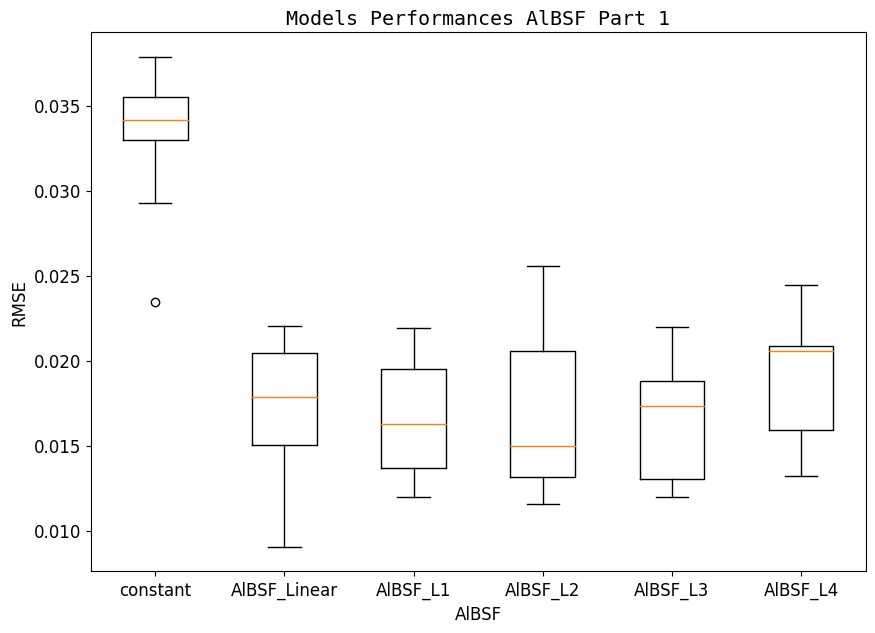

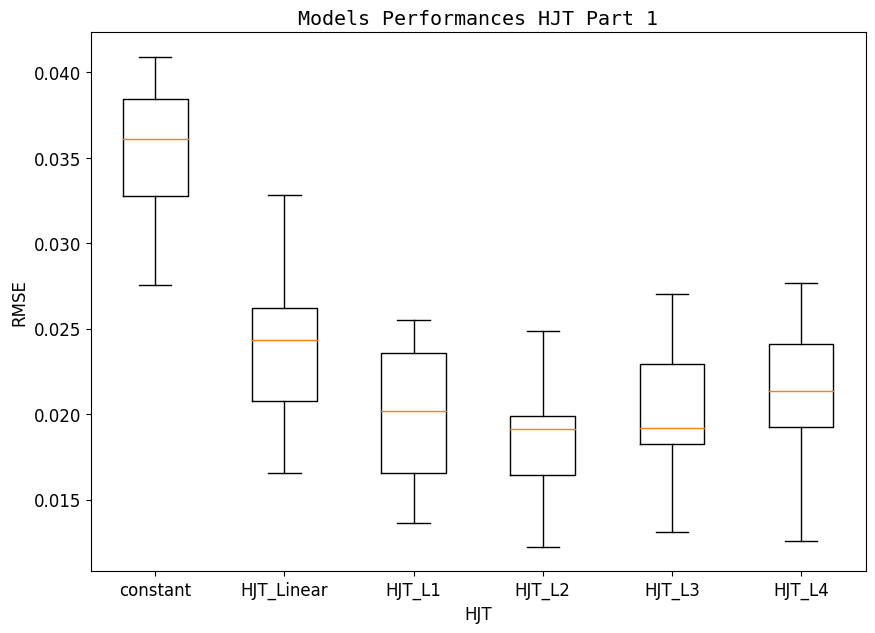

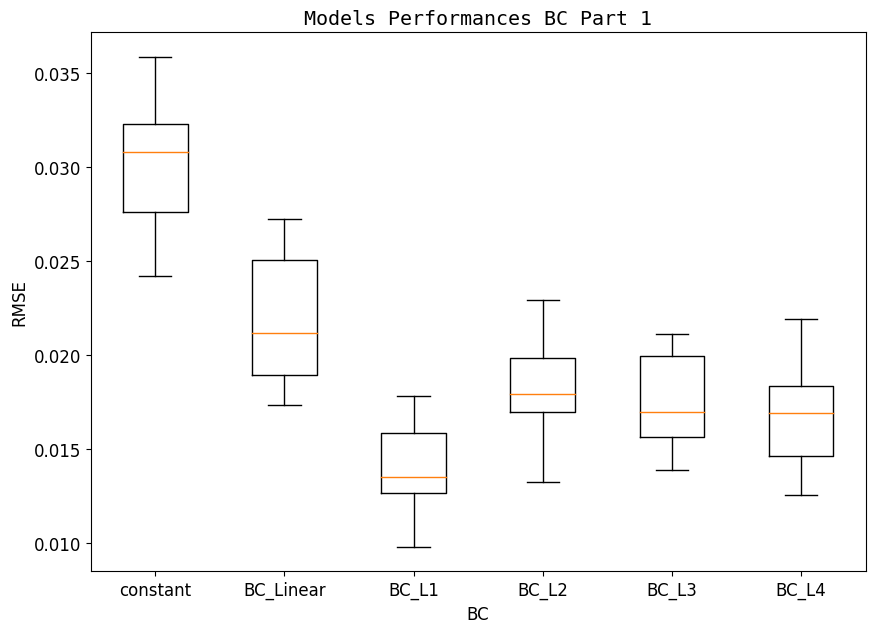

In [ ]:
# CV plots
# Linear
# RMSE
# AlBSF
fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot([rmse3_res['constant'], rmse3_res['linear'], rmse3_res['seasonal_1'], rmse3_res['seasonal_2'], rmse3_res['seasonal_3'], rmse3_res['seasonal_4']])

# x-axis labels
ax.set_xticklabels(['constant', 'AlBSF_Linear', 'AlBSF_L1', 'AlBSF_L2', 'AlBSF_L3', 'AlBSF_L4'])
ax.set_xlabel('AlBSF')
ax.set_ylabel('RMSE')

# Adding title
plt.title("Models Performances AlBSF Part 1", fontname = 'monospace')
plt.rcParams['font.size'] = 12

# show plot
plt.show()

# HJT
fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot([rmse4_res['constant'], rmse4_res['linear'], rmse4_res['seasonal_1'], rmse4_res['seasonal_2'], rmse4_res['seasonal_3'], rmse4_res['seasonal_4']])

# x-axis labels
ax.set_xticklabels(['constant', 'HJT_Linear', 'HJT_L1', 'HJT_L2', 'HJT_L3', 'HJT_L4'])
ax.set_xlabel('HJT')
ax.set_ylabel('RMSE')

# Adding title
plt.title("Models Performances HJT Part 1", fontname = 'monospace')
plt.rcParams['font.size'] = 12

# Show plot
plt.show()

# BC
fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot([rmse7_res['constant'], rmse7_res['linear'], rmse7_res['seasonal_1'], rmse7_res['seasonal_2'], rmse7_res['seasonal_3'], rmse7_res['seasonal_4']])

# x-axis labels
ax.set_xticklabels(['constant', 'BC_Linear', 'BC_L1', 'BC_L2', 'BC_L3', 'BC_L4'])
ax.set_xlabel('BC')
ax.set_ylabel('RMSE')

# Adding title
plt.title("Models Performances BC Part 1", fontname = 'monospace')
plt.rcParams['font.size'] = 12

# show plot
plt.show()

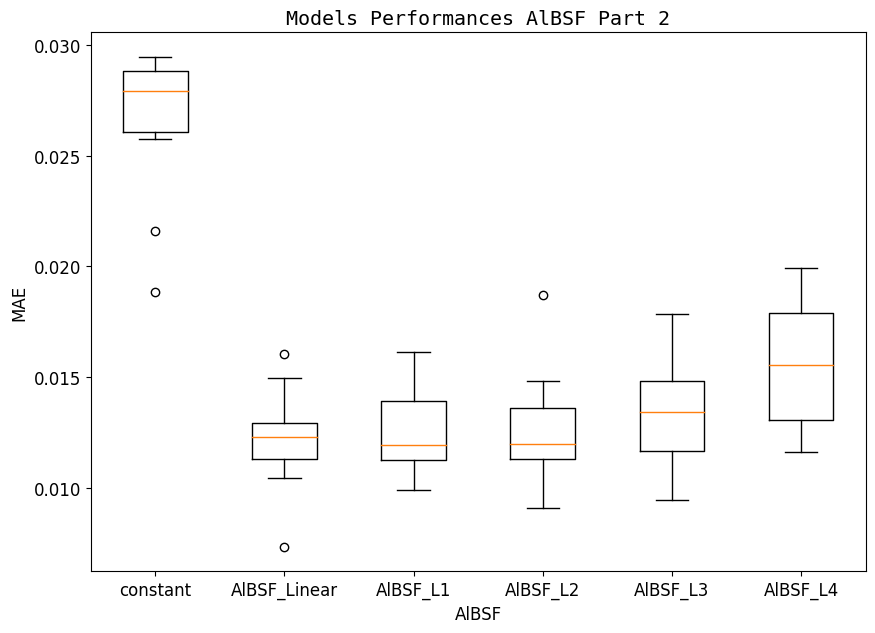

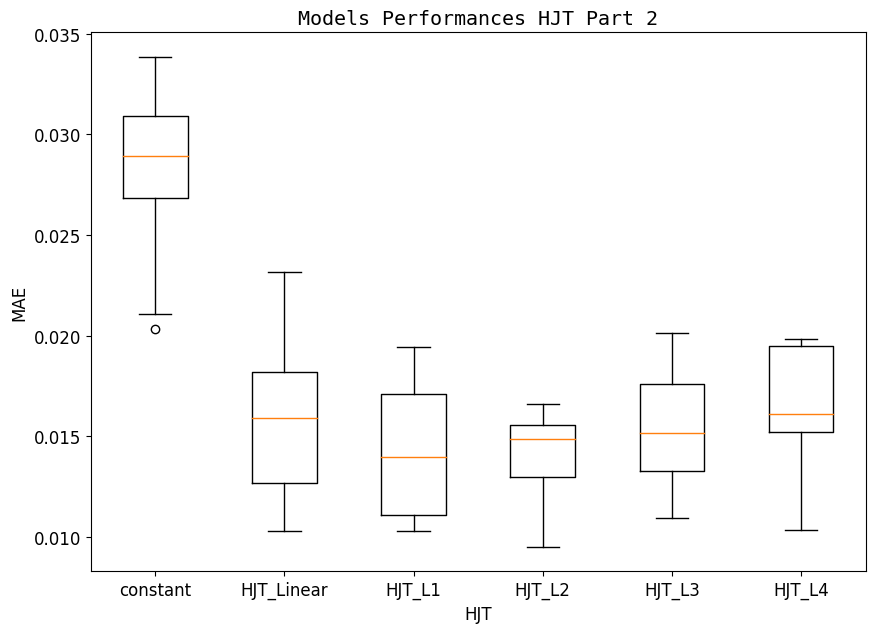

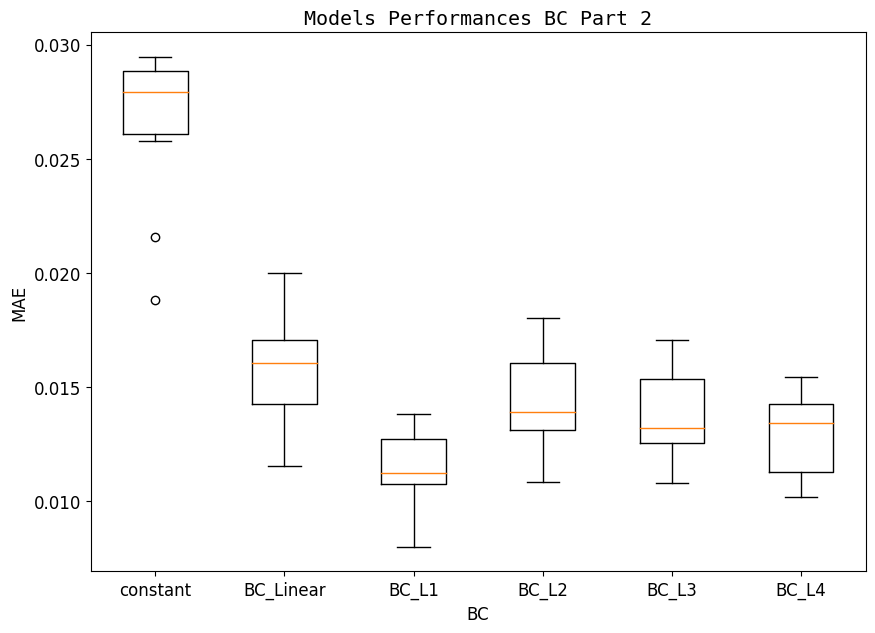

In [ ]:
# CV plots
# Linear
# MAE
# AlBSF
fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot([mae3_res['constant'], mae3_res['linear'], mae3_res['seasonal_1'], mae3_res['seasonal_2'], mae3_res['seasonal_3'], mae3_res['seasonal_4']])

# x-axis labels
ax.set_xticklabels(['constant', 'AlBSF_Linear', 'AlBSF_L1', 'AlBSF_L2', 'AlBSF_L3', 'AlBSF_L4'])
ax.set_xlabel('AlBSF')
ax.set_ylabel('MAE')

# Adding title
plt.title("Models Performances AlBSF Part 2", fontname = 'monospace')
plt.rcParams['font.size'] = 12

# show plot
plt.show()

# HJT
fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot([mae4_res['constant'], mae4_res['linear'], mae4_res['seasonal_1'], mae4_res['seasonal_2'], mae4_res['seasonal_3'], mae4_res['seasonal_4']])

# x-axis labels
ax.set_xticklabels(['constant', 'HJT_Linear', 'HJT_L1', 'HJT_L2', 'HJT_L3', 'HJT_L4'])
ax.set_xlabel('HJT')
ax.set_ylabel('MAE')

# Adding title
plt.title("Models Performances HJT Part 2", fontname = 'monospace')
plt.rcParams['font.size'] = 12

# show plot
plt.show()

# BC
fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot([mae3_res['constant'], mae7_res['linear'], mae7_res['seasonal_1'], mae7_res['seasonal_2'], mae7_res['seasonal_3'], mae7_res['seasonal_4']])

# x-axis labels
ax.set_xticklabels(['constant', 'BC_Linear', 'BC_L1', 'BC_L2', 'BC_L3', 'BC_L4'])
ax.set_xlabel('BC')
ax.set_ylabel('MAE')

# Adding title
plt.title("Models Performances BC Part 2", fontname = 'monospace')
plt.rcParams['font.size'] = 12

# show plot
plt.show()

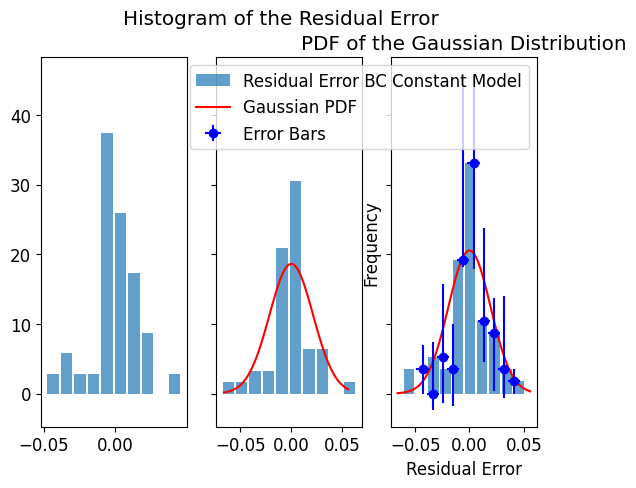

In [ ]:
# no
# Residual Plots
# Constant Model
# AlBSF
c_al_er = res_c.resid
mu, std = stats.norm.fit(c_al_er)

# HJT
c_hjt_er = res4_c.resid
mu4, std4 = stats.norm.fit(c_hjt_er)

# BC
c_bc_er = res7_c.resid
mu7, std7 = stats.norm.fit(c_bc_er)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# Histogram of the residual error
n, bins, _ = ax1.hist(x=c_al_er, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label='Residual Error AlBSF Constant Model')
n, bins4, _ = ax2.hist(x=c_hjt_er, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label='Residual Error HJT Constant Model')
n, bins7, _ = ax3.hist(x=c_bc_er, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label='Residual Error BC Constant Model')

# Plot the PDF.
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p2 = stats.norm(loc=mu4, scale=std4).pdf(x)
p3 = stats.norm(loc=mu7, scale=std7).pdf(x)
ax2.plot(x, p2, color='red', label='Gaussian PDF')
ax3.plot(x, p3, color='red', label='Gaussian PDF')

# Confidence interval calculation
k = 100
confidence_level = 0.95
alpha = (1 - confidence_level) / 2
boot4, boot7 = np.zeros((k, 10)), np.zeros((k, 10))
for i in range(0, k):
  b_s4 = np.random.choice(c_hjt_er, size=len(c_hjt_er), replace=True)
  b_s7 = np.random.choice(c_bc_er, size=len(c_bc_er), replace=True)
  h4, _ = np.histogram(b_s4, density=True, bins=bins)
  h7, _ = np.histogram(b_s7, density=True, bins=bins)
  boot4[i][:] = h4
  boot7[i][:] = h7


# bounds = ci_m - ci_std * stats.norm.ppf(1 - alpha)
b7 = pd.DataFrame(boot7)
bounds_n7 = b7.mean() - b7.std() * stats.norm.ppf(1 - alpha)
bounds_p7 = b7.mean() + b7.std() * stats.norm.ppf(1 - alpha)


# Calculate bin widths and heights
bin_widths = np.diff(bins7)
bin_heights = n

# Plot error bars with x-error as bin widths and y-error as bin heights
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.errorbar(bin_centers, n, xerr=bin_widths / 2, yerr=[abs(n-bounds_n7), abs(n-bounds_p7)], fmt='o', color='blue', label='Error Bars')


plt.suptitle("Histogram of the Residual Error")
plt.title("PDF of the Gaussian Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.rcParams['font.size'] = 12

plt.show()



In [ ]:
# no
t = np.arange(1, 60)
X = sm.add_constant(t)
X = pd.DataFrame(X)
m = 2
L = 4

for i in range(1, L+1):
  # print(i)
  X[f'{m}'] = np.cos((2* i* np.pi * X[1]) / 12)
  X[f'{m+1}'] = np.sin((2* i * np.pi * X[1]) / 12)
  m += 2

# print(X)
columns = [j for j in range(0, m)]
print(columns)

# Albsf
Y3a = df[["AlBSF slope"]]
Y3a = pd.concat([Y3a, X], axis=1).dropna()
y = Y3a["AlBSF slope"]

x_linear = Y3a[[0, 1]]

print([columns[:2*l + 2] for l in range(1, L + 1)])
x_seasonal = [Y3a.iloc[:, 1:(2*(l) + 3)] for l in range(1, L + 1)]
# print(x_seasonal[1])

c_al, c_hjt, c_bc = [], [], []

# HJT
Y4a = df[["HJT slope"]]
Y4a = pd.concat([Y4a, X], axis=1).dropna()
y4 = Y4a["HJT slope"]

x4_l = Y4a[[0, 1]]
x4_s = [Y4a.iloc[:, 1:(2*(l) + 3)] for l in range(1, L + 1)]

# BC
Y7a = df[["BC slope"]]
Y7a = pd.concat([Y7a, X], axis=1).dropna()
y7 = Y7a["BC slope"]

x7_l = Y7a[[0, 1]]
x7_s = [Y7a.iloc[:, 1:(2*(l) + 3)] for l in range(1, L + 1)]
# print(x7_s)

# Constant Model
# AlBSF
m_c_al = sm.OLS(y, x_linear[0])
res_c = m_c_al.fit()
c_c = res_c.params
c_al.append(c_c)

# HJT
m4_c = sm.OLS(y4, x4_l[0])
res4_c = m4_c.fit()
c4_c = res4_c.params
c_hjt.append(c4_c)

# BC
m7_c = sm.OLS(y7, x7_l[0])
res7_c = m7_c.fit()
c7_c = res7_c.params
c_bc.append(c7_c)


# Linear Model
# AlBSF
model_l = sm.OLS(y, x_linear)
res_l = model_l.fit()
c_l = res_l.params
c_al.append(c_l[0] + c_l[1] * X[1])

# HJT
model4_l = sm.OLS(y4, x4_l)
res4_l = model4_l.fit()
c4_l = res4_l.params
c_hjt.append(c4_l[0] + c4_l[1] * X[1])

# BC
model7_l = sm.OLS(y7, x7_l)
res7_l = model7_l.fit()
c7_l = res7_l.params
c_bc.append(c7_l[0] + c7_l[1] * X[1])


# Seasonal Models
al_s_res, hjt_s_res, bc_s_res = [], [], []
for l in range(1, L + 1):
  print(l)
  # AlBSF
  model_s = sm.OLS(y, x_seasonal[l-1])
  res_s = model_s.fit()
  al_s_res.append(res_s)
  c_s = res_s.params
  c_al.append(c_s[0] + [c_s[i] * X.iloc[: ,columns[1:2*i+2]]] for i in range(1, l))

  # HJT
  m4_s = sm.OLS(y4, x4_s[l-1])
  res4_s = m4_s.fit()
  hjt_s_res.append(res4_s)
  c4_s = res4_s.params
  c_hjt.append(c4_s[0] + [c4_s[i] * X.iloc[: ,columns[1:2*i+2]]] for i in range(1, l))

  # BC
  m7_s = sm.OLS(y7, x7_s[l-1])
  res7_s = m7_s.fit()
  bc_s_res.append(res7_s)
  c7_s = res7_s.params
  c_bc.append(c7_s[0] + [c7_s[i] * X.iloc[: ,columns[1:2*i+2]]] for i in range(1, l))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[0, 1, 2, 3], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
1
2
3
4


In [ ]:
# no
columns = ['Constant', 'Linear', 'Seasonal_L1', 'Seasonal_L2', 'Seasonal_L3', 'Seasonal_L4']
rows = ['AlBSF_mu', 'HJT_mu', 'BC_mu', 'AlBSF_std', 'HJT_std', 'BC_std']
statistics = pd.DataFrame([[mu, mu_l, 0.0, 0.0, 0.0, 0.0], [mu4, mu4_l, 0.0, 0.0, 0.0, 0.0], [mu7, mu7_l, 0.0, 0.0, 0.0, 0.0], [std, std_l, 0.0, 0.0, 0.0, 0.0], [std7, std7_l, 0.0, 0.0, 0.0, 0.0], [std4, std4_l, 0.0, 0.0, 0.0, 0.0]], columns= columns, index= rows)
statistics

Constant        Linear  Seasonal_L1  Seasonal_L2  Seasonal_L3  \
AlBSF_mu  -4.275859e-17 -2.850573e-17          0.0          0.0          0.0   
HJT_mu     7.440856e-17  1.311008e-16          0.0          0.0          0.0   
BC_mu      6.476301e-17  4.136125e-17          0.0          0.0          0.0   
AlBSF_std  3.071859e-02  1.647870e-02          0.0          0.0          0.0   
HJT_std    2.905162e-02  1.941940e-02          0.0          0.0          0.0   
BC_std     3.300561e-02  2.142259e-02          0.0          0.0          0.0   

           Seasonal_L4  
AlBSF_mu           0.0  
HJT_mu             0.0  
BC_mu              0.0  
AlBSF_std          0.0  
HJT_std            0.0  
BC_std             0.0

NameError: name 'res_l' is not defined

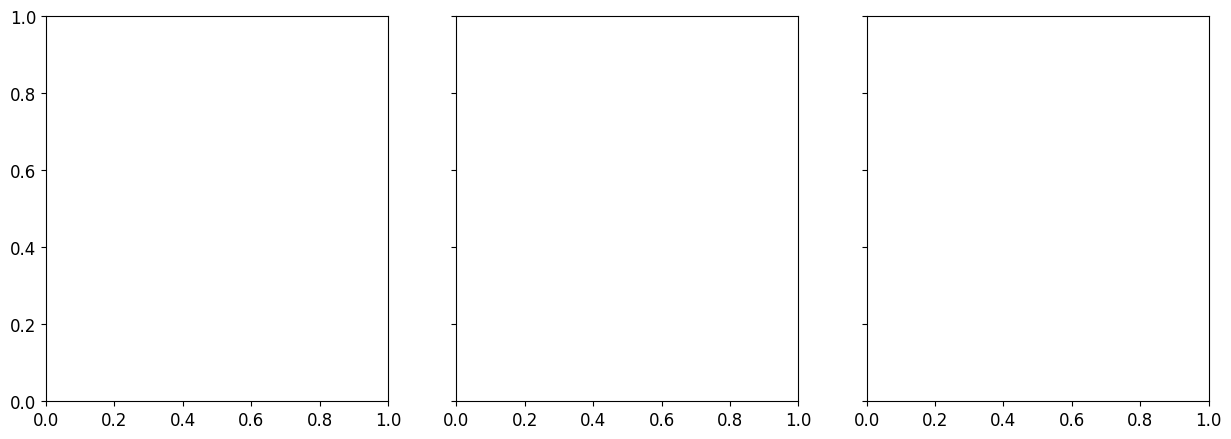

In [ ]:
# no
# Residual Plots
# Linear Models
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

# Plot for AlBSF
plot_residuals(ax1, res_l.resid, 'Residual Error AlBSF Linear Model')
ax1.set_title('AlBSF')

# Plot for HJT
plot_residuals(ax2, res4_l.resid, 'Residual Error HJT Linear Model')
ax2.set_title('HJT')

# Plot for BC
plot_residuals(ax3, res7_l.resid, 'Residual Error BC Linear Model')
ax3.set_title('BC')

# Set common labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Residual Error')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

plt.suptitle("Histogram of the Residual Error and PDF of the Gaussian Distribution")
plt.show()

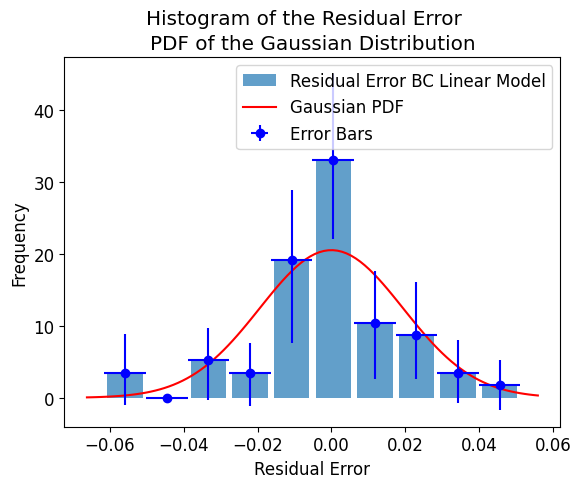

In [ ]:
# no
# Residual Plots
# Linear Model
# AlBSF
al_er_l = res_l.resid
mu_l, std_l = stats.norm.fit(al_er_l)

# HJT
hjt_er_l = res4_l.resid
mu4_l, std4_l = stats.norm.fit(hjt_er_l)

# BC
bc_er_l = res7_l.resid
mu7_l, std7_l = stats.norm.fit(bc_er_l)

# Histogram of the residual error
# n, bins, _ = plt.hist(x=al_er_l, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label='Residual Error AlBSF Linear Model')
# n, bins, _ = plt.hist(x=hjt_er_l, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label='Residual Error HJT Linear Model')
n, bins, _ = plt.hist(x=bc_er_l, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label='Residual Error BC Linear Model')

# Plot the PDF.
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm(loc=mu7_l, scale=std7_l).pdf(x)
plt.plot(x, p, color='red', label='Gaussian PDF')


# Confidence interval calculation
k = 100
confidence_level = 0.95
alpha = (1 - confidence_level) / 2
boot = np.zeros((k, 10))
for i in range(0, k):
  b_s = np.random.choice(bc_er_l, size=len(bc_er_l), replace=True)
  h, _ = np.histogram(b_s, density=True, bins=bins)
  boot[i][:] = h


# bounds = ci_m - ci_std * stats.norm.ppf(1 - alpha)
b = pd.DataFrame(boot)
bounds_n = b.mean() - b.std() * stats.norm.ppf(1 - alpha)
bounds_p = b.mean() + b.std() * stats.norm.ppf(1 - alpha)

# Calculate bin widths and heights
bin_widths = np.diff(bins)
bin_heights = n

# Plot error bars with x-error as bin widths and y-error as bin heights
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.errorbar(bin_centers, n, xerr=bin_widths / 2, yerr=[abs(n-bounds_n), abs(n-bounds_p)], fmt='o', color='blue', label='Error Bars')


plt.suptitle("Histogram of the Residual Error")
plt.title("PDF of the Gaussian Distribution")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.rcParams['font.size'] = 12

plt.show()

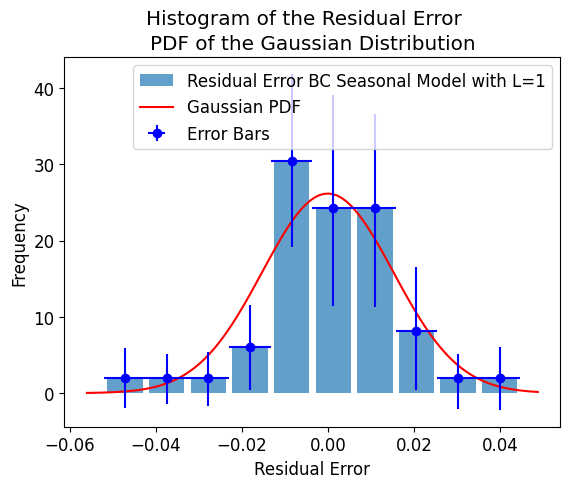

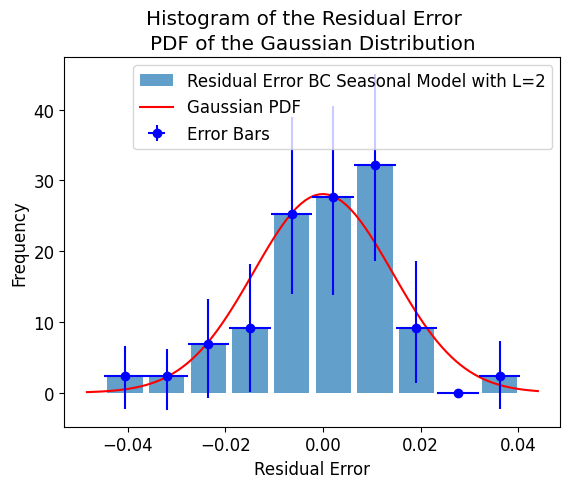

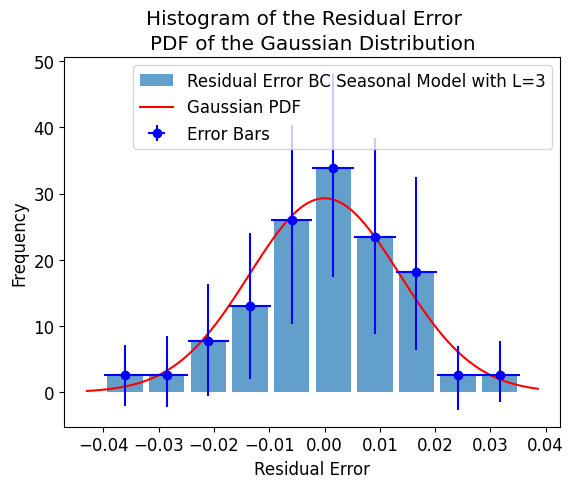

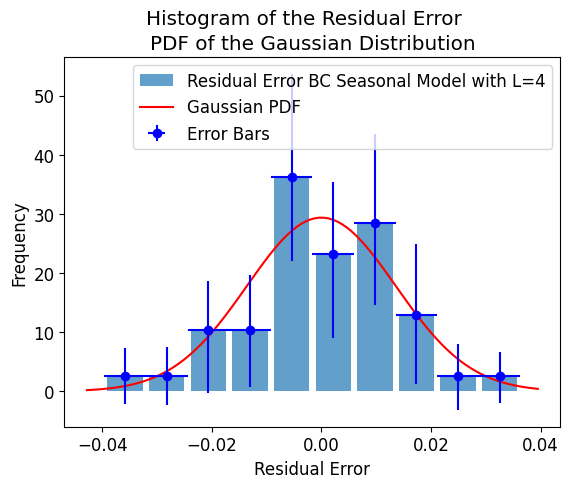

In [ ]:
# no
# Seasonal models
for i in range(L):
  # Albsf
  s_al_er = al_s_res[i].resid
  mu_s, std_s = stats.norm.fit(s_al_er)

  # HJT
  s_hjt_er = hjt_s_res[i].resid
  mu4_s, std4_s = stats.norm.fit(s_hjt_er)

  # BC
  s_bc_er = bc_s_res[i].resid
  mu7_s, std7_s = stats.norm.fit(s_bc_er)

  # update Statistics table
  statistics[f'Seasonal_L{str(i+1)}'] = mu_s, mu4_s, mu7_s, std_s,  std4_s, std7_s


  # Histogram of the residual error
  # n, bins, _ = plt.hist(x=s_al_er, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label=f'Residual Error AlBSF Seasonal Model with L={i+1}')
  # n, bins, _ = plt.hist(x=s_hjt_er, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label=f'Residual Error HJT Seasonal Model with L={i+1}')
  n, bins, _ = plt.hist(x=s_bc_er, density=True, linewidth=0, bins=10, alpha=0.7, rwidth=0.85, label=f'Residual Error BC Seasonal Model with L={i+1}')

  # Plot the PDF.
  xmin, xmax = plt.xlim() # the maximum x values from the histogram above
  x = np.linspace(xmin, xmax, 100) # generate some x values
  p = stats.norm(loc=mu7_s, scale=std7_s).pdf(x)
  plt.plot(x, p, color='red', label='Gaussian PDF')


  # Confidence interval calculation
  k = 100
  confidence_level = 0.95
  alpha = (1 - confidence_level) / 2
  boot = np.zeros((k, 10))
  for i in range(0, k):
    b_s = np.random.choice(s_bc_er, size=len(s_bc_er), replace=True)
    h, _ = np.histogram(b_s, density=True, bins=bins)
    boot[i][:] = h


  # bounds = ci_m - ci_std * stats.norm.ppf(1 - alpha)
  b = pd.DataFrame(boot)
  bounds_n = b.mean() - b.std() * stats.norm.ppf(1 - alpha)
  bounds_p = b.mean() + b.std() * stats.norm.ppf(1 - alpha)

  # Calculate bin widths and heights
  bin_widths = np.diff(bins)
  bin_heights = n

  # Plot error bars with x-error as bin widths and y-error as bin heights
  bin_centers = 0.5 * (bins[:-1] + bins[1:])
  plt.errorbar(bin_centers, n, xerr=bin_widths / 2, yerr=[abs(n-bounds_n), abs(n-bounds_p)], fmt='o', color='blue', label='Error Bars')


  plt.suptitle("Histogram of the Residual Error")
  plt.title("PDF of the Gaussian Distribution")
  plt.xlabel("Residual Error")
  plt.ylabel("Frequency")
  plt.legend(loc='best')
  plt.rcParams['font.size'] = 12

  plt.show()
